# Polystyrene Stress Relaxation

Fit polystyrene relaxation at selectable temperature.

**Data:** examples/data/pyRheo/polystyrene/stressrelaxation_ps130_data.csv (swap for other temps)


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.pipeline.base import Pipeline

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)

def load_tab_file(path):
    df = pd.read_csv(path, sep='	')
    df.columns = df.columns.str.strip()
    df = df.dropna()
    df.iloc[:,0] = pd.to_numeric(df.iloc[:,0], errors='coerce')
    df.iloc[:,1] = pd.to_numeric(df.iloc[:,1], errors='coerce')
    df = df.dropna()
    return df
import arviz as az


INFO:2025-12-07 17:36:58,055:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load relaxation data (select temperature file)

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyRheo' / 'polystyrene'
file = DATA_DIR / 'stressrelaxation_ps130_data.csv'  # swap for other temps
df = load_tab_file(file)
t = df.iloc[:,0].to_numpy()
G = df.iloc[:,1].to_numpy()


## Fit relaxation models

In [4]:
gm = GeneralizedMaxwell(n_modes=5, modulus_type='tensile')
gm.fit(t, G, test_mode='relaxation', use_log_residuals=True, use_multi_start=True)
gm_pred = gm.predict(t)
gm_r2 = gm.score(t, G)

fm = FractionalMaxwellModel()
fm.fit(t, G, test_mode='relaxation', use_log_residuals=True)
fm_pred = fm.predict(t, test_mode='relaxation')
fm_r2 = r2_complex(G, fm_pred)

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.391517s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=38 | final_cost=4.990510e+08 | time=1.392s | final_gradient_norm=3959414.512507904


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.385672s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=38 | final_cost=4.990510e+08 | time=0.386s | final_gradient_norm=3959414.512507904


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.718520s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=21 | final_cost=2.307751e+09 | time=0.719s | final_gradient_norm=2064677008738.3274


Element minimization: early termination at n_modes=4 (R²=0.999043 < threshold=0.999690)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


[WARNING] Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Timer: optimization took 1.382957s


Convergence: reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=3.562471e+03 | time=1.383s | final_gradient_norm=nan


NLSQ hit inner iteration limit; retrying with SciPy least_squares for stability.


{'gm_r2': 0.9997930896304674, 'fm_r2': -1.7359000485480842}


## Plot relaxation fits

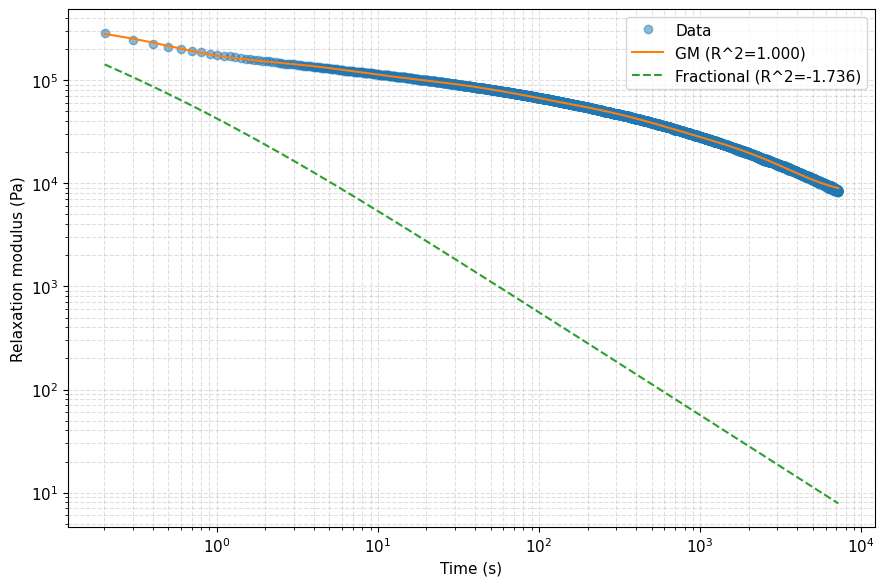

In [5]:
fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(t, G, 'o', label='Data', alpha=0.5)
ax.loglog(t, gm_pred, '-', label=f'GM (R^2={gm_r2:.3f})')
ax.loglog(t, fm_pred, '--', label=f'Fractional (R^2={fm_r2:.3f})')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Relaxation modulus (Pa)')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.387045s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=38 | final_cost=4.990510e+08 | time=0.387s | final_gradient_norm=3959414.512507904


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.383605s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=38 | final_cost=4.990510e+08 | time=0.384s | final_gradient_norm=3959414.512507904


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.251590s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=21 | final_cost=2.307751e+09 | time=0.252s | final_gradient_norm=2064677008738.3274


Element minimization: early termination at n_modes=4 (R²=0.999043 < threshold=0.999690)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


[WARNING] Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Timer: optimization took 0.791007s


Convergence: reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=3.562471e+03 | time=0.791s | final_gradient_norm=nan


NLSQ hit inner iteration limit; retrying with SciPy least_squares for stability.


Model ranking (R²): [('gm', 1.0), ('fm', -1.736)]


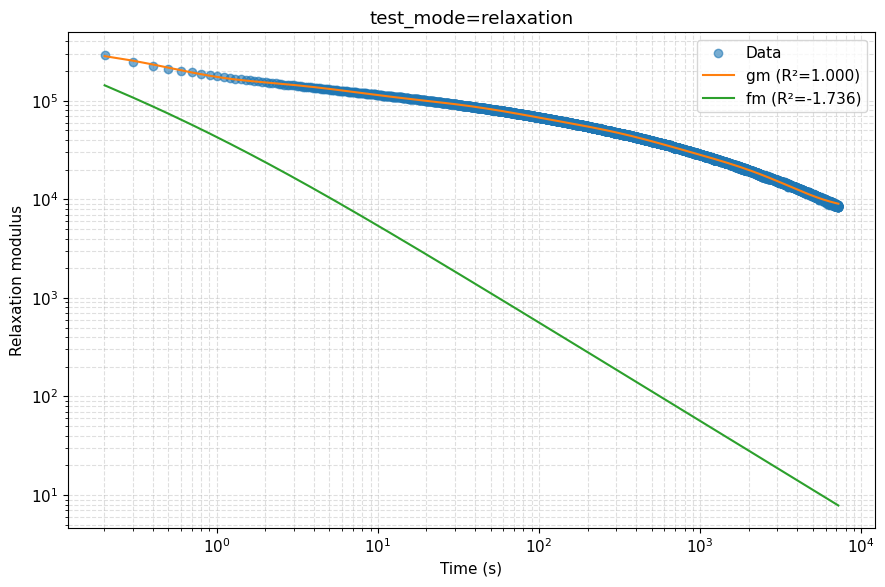

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<1:00:33,  1.10it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   2%|▏         | 62/4000 [00:01<00:47, 83.62it/s, 15 steps of size 3.88e-04. acc. prob=0.73]

warmup:   2%|▏         | 98/4000 [00:01<01:01, 63.85it/s, 3 steps of size 1.03e-04. acc. prob=0.74] 

warmup:   3%|▎         | 120/4000 [00:02<01:17, 49.96it/s, 63 steps of size 1.46e-02. acc. prob=0.76]

warmup:   3%|▎         | 135/4000 [00:02<01:19, 48.34it/s, 63 steps of size 1.74e-02. acc. prob=0.76]

warmup:   4%|▎         | 146/4000 [00:03<01:23, 46.39it/s, 87 steps of size 7.85e-03. acc. prob=0.76]

warmup:   4%|▍         | 155/4000 [00:03<01:19, 48.51it/s, 383 steps of size 8.42e-03. acc. prob=0.76]

warmup:   4%|▍         | 163/4000 [00:03<01:23, 46.16it/s, 511 steps of size 7.62e-03. acc. prob=0.76]

warmup:   4%|▍         | 170/4000 [00:03<01:29, 42.87it/s, 127 steps of size 5.47e-02. acc. prob=0.77]

warmup:   4%|▍         | 176/4000 [00:03<01:32, 41.36it/s, 767 steps of size 8.03e-03. acc. prob=0.77]

warmup:   5%|▍         | 181/4000 [00:03<01:30, 42.06it/s, 127 steps of size 2.15e-02. acc. prob=0.77]

warmup:   5%|▍         | 187/4000 [00:03<01:24, 44.94it/s, 255 steps of size 1.85e-02. acc. prob=0.77]

warmup:   5%|▍         | 194/4000 [00:04<01:17, 49.29it/s, 63 steps of size 2.64e-02. acc. prob=0.77] 

warmup:   5%|▌         | 200/4000 [00:04<01:25, 44.38it/s, 511 steps of size 1.27e-02. acc. prob=0.77]

warmup:   5%|▌         | 205/4000 [00:04<01:27, 43.44it/s, 255 steps of size 1.03e-02. acc. prob=0.77]

warmup:   5%|▌         | 211/4000 [00:04<01:21, 46.42it/s, 127 steps of size 2.23e-02. acc. prob=0.77]

warmup:   5%|▌         | 218/4000 [00:04<01:14, 51.02it/s, 255 steps of size 1.10e-02. acc. prob=0.77]

warmup:   6%|▌         | 226/4000 [00:04<01:05, 58.01it/s, 63 steps of size 3.31e-02. acc. prob=0.77] 

warmup:   6%|▌         | 233/4000 [00:04<01:24, 44.79it/s, 255 steps of size 1.76e-02. acc. prob=0.77]

warmup:   6%|▌         | 239/4000 [00:05<01:24, 44.56it/s, 191 steps of size 2.15e-02. acc. prob=0.77]

warmup:   6%|▌         | 245/4000 [00:05<01:22, 45.29it/s, 255 steps of size 1.57e-02. acc. prob=0.77]

warmup:   6%|▋         | 254/4000 [00:05<01:17, 48.31it/s, 511 steps of size 5.73e-03. acc. prob=0.77]

warmup:   6%|▋         | 260/4000 [00:05<01:28, 42.15it/s, 511 steps of size 6.50e-03. acc. prob=0.77]

warmup:   7%|▋         | 265/4000 [00:05<01:26, 43.32it/s, 47 steps of size 6.15e-03. acc. prob=0.77] 

warmup:   7%|▋         | 270/4000 [00:05<01:32, 40.35it/s, 63 steps of size 3.33e-02. acc. prob=0.77]

warmup:   7%|▋         | 275/4000 [00:05<01:30, 41.06it/s, 191 steps of size 4.61e-02. acc. prob=0.78]

warmup:   7%|▋         | 281/4000 [00:06<01:25, 43.68it/s, 127 steps of size 2.58e-02. acc. prob=0.78]

warmup:   7%|▋         | 288/4000 [00:06<01:14, 49.77it/s, 127 steps of size 4.19e-02. acc. prob=0.78]

warmup:   7%|▋         | 294/4000 [00:06<01:20, 46.14it/s, 127 steps of size 3.27e-02. acc. prob=0.78]

warmup:   8%|▊         | 301/4000 [00:06<01:11, 51.95it/s, 63 steps of size 4.49e-02. acc. prob=0.78] 

warmup:   8%|▊         | 307/4000 [00:06<01:12, 50.62it/s, 127 steps of size 1.58e-02. acc. prob=0.78]

warmup:   8%|▊         | 315/4000 [00:06<01:05, 56.44it/s, 127 steps of size 4.55e-02. acc. prob=0.78]

warmup:   8%|▊         | 323/4000 [00:06<01:02, 58.53it/s, 255 steps of size 1.46e-02. acc. prob=0.78]

warmup:   8%|▊         | 329/4000 [00:06<01:07, 54.20it/s, 255 steps of size 1.37e-02. acc. prob=0.78]

warmup:   8%|▊         | 335/4000 [00:07<01:07, 54.10it/s, 31 steps of size 4.00e-02. acc. prob=0.78] 

warmup:   9%|▊         | 344/4000 [00:07<00:58, 62.76it/s, 63 steps of size 1.68e-02. acc. prob=0.78]

warmup:   9%|▉         | 352/4000 [00:07<00:54, 66.91it/s, 127 steps of size 1.52e-02. acc. prob=0.78]

warmup:   9%|▉         | 359/4000 [00:07<01:05, 55.98it/s, 511 steps of size 1.66e-02. acc. prob=0.78]

warmup:   9%|▉         | 365/4000 [00:07<01:04, 56.53it/s, 31 steps of size 4.58e-02. acc. prob=0.78] 

warmup:   9%|▉         | 373/4000 [00:07<00:58, 62.18it/s, 63 steps of size 2.87e-02. acc. prob=0.78]

warmup:  10%|▉         | 380/4000 [00:07<00:57, 63.28it/s, 143 steps of size 2.77e-02. acc. prob=0.78]

warmup:  10%|▉         | 387/4000 [00:07<00:58, 62.15it/s, 255 steps of size 1.68e-02. acc. prob=0.78]

warmup:  10%|▉         | 394/4000 [00:08<01:06, 53.89it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  10%|█         | 400/4000 [00:08<01:05, 54.99it/s, 127 steps of size 2.74e-02. acc. prob=0.78]

warmup:  10%|█         | 409/4000 [00:08<00:56, 63.55it/s, 127 steps of size 3.61e-02. acc. prob=0.78]

warmup:  10%|█         | 418/4000 [00:08<00:51, 69.83it/s, 127 steps of size 3.74e-02. acc. prob=0.78]

warmup:  11%|█         | 426/4000 [00:08<00:53, 66.42it/s, 127 steps of size 3.35e-02. acc. prob=0.78]

warmup:  11%|█         | 436/4000 [00:08<00:47, 74.91it/s, 63 steps of size 5.16e-02. acc. prob=0.78] 

warmup:  11%|█         | 446/4000 [00:08<00:44, 79.03it/s, 127 steps of size 1.87e-02. acc. prob=0.78]

warmup:  11%|█▏        | 455/4000 [00:08<00:55, 63.55it/s, 511 steps of size 1.36e-02. acc. prob=0.78]

warmup:  12%|█▏        | 462/4000 [00:09<01:11, 49.83it/s, 255 steps of size 3.36e-02. acc. prob=0.78]

warmup:  12%|█▏        | 468/4000 [00:09<01:10, 49.80it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  12%|█▏        | 474/4000 [00:09<01:11, 49.21it/s, 127 steps of size 2.03e-02. acc. prob=0.78]

warmup:  12%|█▏        | 480/4000 [00:09<01:09, 50.79it/s, 63 steps of size 1.24e-02. acc. prob=0.78] 

warmup:  12%|█▏        | 486/4000 [00:09<01:12, 48.22it/s, 63 steps of size 2.49e-02. acc. prob=0.78]

warmup:  12%|█▏        | 493/4000 [00:09<01:06, 53.03it/s, 31 steps of size 1.85e-02. acc. prob=0.78]

warmup:  12%|█▎        | 500/4000 [00:09<01:04, 54.31it/s, 255 steps of size 1.96e-02. acc. prob=0.78]

warmup:  13%|█▎        | 508/4000 [00:09<00:57, 60.64it/s, 127 steps of size 5.88e-02. acc. prob=0.78]

warmup:  13%|█▎        | 515/4000 [00:10<00:56, 61.34it/s, 15 steps of size 3.55e-02. acc. prob=0.78] 

warmup:  13%|█▎        | 522/4000 [00:10<00:57, 60.21it/s, 7 steps of size 2.05e-02. acc. prob=0.78] 

warmup:  13%|█▎        | 529/4000 [00:10<00:56, 60.94it/s, 3 steps of size 1.32e-02. acc. prob=0.78]

warmup:  13%|█▎        | 536/4000 [00:10<01:02, 55.74it/s, 127 steps of size 3.82e-02. acc. prob=0.78]

warmup:  14%|█▎        | 543/4000 [00:10<00:59, 57.68it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  14%|█▍        | 552/4000 [00:10<00:56, 60.94it/s, 255 steps of size 2.13e-02. acc. prob=0.78]

warmup:  14%|█▍        | 559/4000 [00:10<00:56, 61.33it/s, 63 steps of size 1.91e-02. acc. prob=0.78] 

warmup:  14%|█▍        | 566/4000 [00:10<00:57, 59.46it/s, 127 steps of size 3.88e-02. acc. prob=0.78]

warmup:  14%|█▍        | 575/4000 [00:11<00:51, 66.07it/s, 127 steps of size 3.19e-02. acc. prob=0.78]

warmup:  15%|█▍        | 583/4000 [00:11<00:51, 66.93it/s, 127 steps of size 3.10e-02. acc. prob=0.78]

warmup:  15%|█▍        | 591/4000 [00:11<00:51, 66.67it/s, 255 steps of size 2.79e-02. acc. prob=0.78]

warmup:  15%|█▍        | 599/4000 [00:11<00:49, 68.11it/s, 127 steps of size 2.57e-02. acc. prob=0.78]

warmup:  15%|█▌        | 606/4000 [00:11<00:50, 66.68it/s, 63 steps of size 2.85e-02. acc. prob=0.78] 

warmup:  15%|█▌        | 619/4000 [00:11<00:43, 77.62it/s, 255 steps of size 2.39e-02. acc. prob=0.78]

warmup:  16%|█▌        | 628/4000 [00:11<00:42, 79.23it/s, 127 steps of size 2.85e-02. acc. prob=0.79]

warmup:  16%|█▌        | 636/4000 [00:11<00:47, 70.10it/s, 127 steps of size 2.03e-02. acc. prob=0.78]

warmup:  16%|█▌        | 647/4000 [00:11<00:45, 74.51it/s, 255 steps of size 3.40e-02. acc. prob=0.79]

warmup:  16%|█▋        | 657/4000 [00:12<00:41, 80.68it/s, 15 steps of size 4.57e-02. acc. prob=0.79] 

warmup:  17%|█▋        | 666/4000 [00:12<00:41, 80.88it/s, 31 steps of size 1.95e-02. acc. prob=0.79]

warmup:  17%|█▋        | 675/4000 [00:12<00:39, 83.33it/s, 63 steps of size 3.18e-02. acc. prob=0.79]

warmup:  17%|█▋        | 686/4000 [00:12<00:37, 87.79it/s, 95 steps of size 2.46e-02. acc. prob=0.79]

warmup:  17%|█▋        | 695/4000 [00:12<00:40, 81.59it/s, 5 steps of size 3.28e-02. acc. prob=0.79] 

warmup:  18%|█▊        | 706/4000 [00:12<00:38, 85.25it/s, 127 steps of size 3.52e-02. acc. prob=0.79]

warmup:  18%|█▊        | 715/4000 [00:12<00:41, 78.85it/s, 63 steps of size 3.51e-02. acc. prob=0.79] 

warmup:  18%|█▊        | 724/4000 [00:12<00:42, 76.86it/s, 127 steps of size 5.45e-02. acc. prob=0.79]

warmup:  18%|█▊        | 732/4000 [00:13<00:42, 77.32it/s, 255 steps of size 3.36e-02. acc. prob=0.79]

warmup:  18%|█▊        | 740/4000 [00:13<00:43, 75.80it/s, 255 steps of size 3.36e-02. acc. prob=0.79]

warmup:  19%|█▊        | 748/4000 [00:13<00:44, 72.98it/s, 127 steps of size 4.76e-02. acc. prob=0.79]

warmup:  19%|█▉        | 759/4000 [00:13<00:40, 79.94it/s, 127 steps of size 3.84e-02. acc. prob=0.79]

warmup:  19%|█▉        | 768/4000 [00:13<00:43, 74.91it/s, 63 steps of size 4.59e-02. acc. prob=0.79] 

warmup:  19%|█▉        | 777/4000 [00:13<00:41, 78.47it/s, 127 steps of size 4.93e-02. acc. prob=0.79]

warmup:  20%|█▉        | 785/4000 [00:13<00:42, 75.80it/s, 127 steps of size 4.85e-02. acc. prob=0.79]

warmup:  20%|█▉        | 793/4000 [00:13<00:43, 73.80it/s, 127 steps of size 4.08e-02. acc. prob=0.79]

warmup:  20%|██        | 801/4000 [00:13<00:43, 74.39it/s, 63 steps of size 5.27e-02. acc. prob=0.79] 

warmup:  20%|██        | 809/4000 [00:14<00:43, 73.78it/s, 63 steps of size 3.55e-02. acc. prob=0.79]

warmup:  20%|██        | 817/4000 [00:14<00:47, 67.25it/s, 127 steps of size 2.79e-02. acc. prob=0.79]

warmup:  21%|██        | 826/4000 [00:14<00:43, 72.59it/s, 63 steps of size 3.44e-02. acc. prob=0.79] 

warmup:  21%|██        | 834/4000 [00:14<00:47, 66.17it/s, 127 steps of size 4.06e-02. acc. prob=0.79]

warmup:  21%|██        | 842/4000 [00:14<00:45, 69.19it/s, 127 steps of size 4.37e-02. acc. prob=0.79]

warmup:  21%|██▏       | 850/4000 [00:14<00:46, 68.30it/s, 31 steps of size 4.78e-02. acc. prob=0.79] 

warmup:  21%|██▏       | 857/4000 [00:14<00:46, 68.24it/s, 95 steps of size 3.50e-02. acc. prob=0.79]

warmup:  22%|██▏       | 866/4000 [00:14<00:43, 71.76it/s, 127 steps of size 4.09e-02. acc. prob=0.79]

warmup:  22%|██▏       | 874/4000 [00:15<00:43, 72.50it/s, 191 steps of size 3.52e-02. acc. prob=0.79]

warmup:  22%|██▏       | 883/4000 [00:15<00:41, 75.05it/s, 127 steps of size 3.08e-02. acc. prob=0.79]

warmup:  22%|██▏       | 892/4000 [00:15<00:39, 77.99it/s, 63 steps of size 3.39e-02. acc. prob=0.79] 

warmup:  22%|██▎       | 900/4000 [00:15<00:41, 74.34it/s, 127 steps of size 5.22e-02. acc. prob=0.79]

warmup:  23%|██▎       | 910/4000 [00:15<00:38, 79.52it/s, 63 steps of size 3.89e-02. acc. prob=0.79] 

warmup:  23%|██▎       | 919/4000 [00:15<00:38, 80.20it/s, 255 steps of size 2.34e-02. acc. prob=0.79]

warmup:  23%|██▎       | 928/4000 [00:15<00:37, 82.32it/s, 63 steps of size 4.27e-02. acc. prob=0.79] 

warmup:  23%|██▎       | 939/4000 [00:15<00:34, 87.46it/s, 127 steps of size 2.92e-02. acc. prob=0.79]

warmup:  24%|██▎       | 949/4000 [00:15<00:33, 90.96it/s, 127 steps of size 3.72e-02. acc. prob=0.79]

warmup:  24%|██▍       | 959/4000 [00:16<00:35, 85.76it/s, 255 steps of size 1.47e-02. acc. prob=0.79]

warmup:  24%|██▍       | 968/4000 [00:16<00:41, 72.37it/s, 63 steps of size 1.95e-02. acc. prob=0.79] 

warmup:  24%|██▍       | 976/4000 [00:16<00:45, 65.84it/s, 127 steps of size 4.34e-02. acc. prob=0.79]

warmup:  25%|██▍       | 983/4000 [00:16<00:57, 52.13it/s, 44 steps of size 2.05e-02. acc. prob=0.79] 

warmup:  25%|██▍       | 989/4000 [00:16<00:58, 51.87it/s, 127 steps of size 3.62e-02. acc. prob=0.79]

warmup:  25%|██▍       | 997/4000 [00:16<00:52, 57.63it/s, 63 steps of size 3.55e-02. acc. prob=0.79] 

sample:  25%|██▌       | 1004/4000 [00:16<00:50, 59.47it/s, 127 steps of size 3.47e-02. acc. prob=0.95]

sample:  25%|██▌       | 1011/4000 [00:16<00:48, 61.08it/s, 127 steps of size 3.47e-02. acc. prob=0.94]

sample:  25%|██▌       | 1019/4000 [00:17<00:46, 64.61it/s, 127 steps of size 3.47e-02. acc. prob=0.94]

sample:  26%|██▌       | 1026/4000 [00:17<00:48, 61.74it/s, 63 steps of size 3.47e-02. acc. prob=0.94] 

sample:  26%|██▌       | 1033/4000 [00:17<00:49, 60.24it/s, 191 steps of size 3.47e-02. acc. prob=0.94]

sample:  26%|██▌       | 1040/4000 [00:17<00:49, 60.33it/s, 127 steps of size 3.47e-02. acc. prob=0.94]

sample:  26%|██▌       | 1047/4000 [00:17<00:49, 60.22it/s, 127 steps of size 3.47e-02. acc. prob=0.94]

sample:  26%|██▋       | 1054/4000 [00:17<00:48, 60.77it/s, 15 steps of size 3.47e-02. acc. prob=0.94] 

sample:  27%|██▋       | 1063/4000 [00:17<00:43, 67.35it/s, 63 steps of size 3.47e-02. acc. prob=0.94]

sample:  27%|██▋       | 1072/4000 [00:17<00:40, 72.18it/s, 63 steps of size 3.47e-02. acc. prob=0.94]

sample:  27%|██▋       | 1082/4000 [00:18<00:37, 77.01it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  27%|██▋       | 1090/4000 [00:18<00:38, 76.22it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  27%|██▋       | 1098/4000 [00:18<00:40, 72.09it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  28%|██▊       | 1106/4000 [00:18<00:39, 72.74it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  28%|██▊       | 1114/4000 [00:18<00:44, 64.21it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  28%|██▊       | 1122/4000 [00:18<00:42, 66.97it/s, 63 steps of size 3.47e-02. acc. prob=0.92] 

sample:  28%|██▊       | 1130/4000 [00:18<00:41, 69.15it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  28%|██▊       | 1138/4000 [00:18<00:40, 70.25it/s, 63 steps of size 3.47e-02. acc. prob=0.92] 

sample:  29%|██▊       | 1146/4000 [00:18<00:41, 69.11it/s, 31 steps of size 3.47e-02. acc. prob=0.93]

sample:  29%|██▉       | 1153/4000 [00:19<00:41, 68.93it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  29%|██▉       | 1160/4000 [00:19<00:43, 64.76it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  29%|██▉       | 1168/4000 [00:19<00:41, 68.70it/s, 31 steps of size 3.47e-02. acc. prob=0.93] 

sample:  29%|██▉       | 1175/4000 [00:19<00:44, 63.84it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  30%|██▉       | 1183/4000 [00:19<00:42, 65.71it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  30%|██▉       | 1190/4000 [00:19<00:45, 62.12it/s, 87 steps of size 3.47e-02. acc. prob=0.93] 

sample:  30%|██▉       | 1197/4000 [00:19<00:44, 63.02it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  30%|███       | 1205/4000 [00:19<00:43, 64.79it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  30%|███       | 1213/4000 [00:19<00:40, 68.03it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  30%|███       | 1220/4000 [00:20<00:41, 66.94it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  31%|███       | 1228/4000 [00:20<00:39, 70.17it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  31%|███       | 1236/4000 [00:20<00:39, 70.81it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  31%|███       | 1244/4000 [00:20<00:38, 70.72it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  31%|███▏      | 1252/4000 [00:20<00:40, 67.38it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  31%|███▏      | 1259/4000 [00:20<00:44, 61.21it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  32%|███▏      | 1266/4000 [00:20<00:44, 61.96it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  32%|███▏      | 1273/4000 [00:20<00:43, 62.88it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  32%|███▏      | 1280/4000 [00:21<00:42, 63.88it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  32%|███▏      | 1287/4000 [00:21<00:44, 61.10it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  32%|███▏      | 1295/4000 [00:21<00:44, 61.43it/s, 255 steps of size 3.47e-02. acc. prob=0.93]

sample:  33%|███▎      | 1302/4000 [00:21<00:46, 58.17it/s, 255 steps of size 3.47e-02. acc. prob=0.93]

sample:  33%|███▎      | 1311/4000 [00:21<00:40, 65.82it/s, 31 steps of size 3.47e-02. acc. prob=0.93] 

sample:  33%|███▎      | 1318/4000 [00:21<00:40, 66.59it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  33%|███▎      | 1325/4000 [00:21<00:43, 61.87it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  33%|███▎      | 1332/4000 [00:21<00:44, 59.83it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  34%|███▎      | 1341/4000 [00:21<00:40, 65.58it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  34%|███▎      | 1348/4000 [00:22<00:40, 65.48it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  34%|███▍      | 1355/4000 [00:22<00:45, 57.56it/s, 255 steps of size 3.47e-02. acc. prob=0.93]

sample:  34%|███▍      | 1361/4000 [00:22<00:45, 58.00it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  34%|███▍      | 1367/4000 [00:22<00:46, 56.14it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  34%|███▍      | 1374/4000 [00:22<00:44, 59.36it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  35%|███▍      | 1382/4000 [00:22<00:42, 61.22it/s, 255 steps of size 3.47e-02. acc. prob=0.93]

sample:  35%|███▍      | 1389/4000 [00:22<00:43, 59.85it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  35%|███▍      | 1397/4000 [00:22<00:40, 64.48it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  35%|███▌      | 1406/4000 [00:23<00:37, 68.28it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  35%|███▌      | 1413/4000 [00:23<00:39, 65.16it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  36%|███▌      | 1420/4000 [00:23<00:41, 61.85it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  36%|███▌      | 1427/4000 [00:23<00:40, 63.14it/s, 15 steps of size 3.47e-02. acc. prob=0.93] 

sample:  36%|███▌      | 1436/4000 [00:23<00:37, 68.39it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  36%|███▌      | 1443/4000 [00:23<00:40, 63.10it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  36%|███▋      | 1450/4000 [00:23<00:40, 62.70it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  36%|███▋      | 1457/4000 [00:23<00:40, 62.40it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  37%|███▋      | 1464/4000 [00:23<00:42, 60.20it/s, 255 steps of size 3.47e-02. acc. prob=0.93]

sample:  37%|███▋      | 1471/4000 [00:24<00:40, 62.18it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  37%|███▋      | 1478/4000 [00:24<00:43, 57.93it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  37%|███▋      | 1486/4000 [00:24<00:39, 63.00it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  37%|███▋      | 1493/4000 [00:24<00:40, 62.00it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  38%|███▊      | 1500/4000 [00:24<00:43, 57.97it/s, 31 steps of size 3.47e-02. acc. prob=0.93] 

sample:  38%|███▊      | 1508/4000 [00:24<00:39, 63.40it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  38%|███▊      | 1517/4000 [00:24<00:35, 70.46it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  38%|███▊      | 1525/4000 [00:24<00:34, 70.86it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  38%|███▊      | 1534/4000 [00:25<00:33, 73.72it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  39%|███▊      | 1543/4000 [00:25<00:32, 76.43it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  39%|███▉      | 1551/4000 [00:25<00:31, 77.09it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  39%|███▉      | 1559/4000 [00:25<00:36, 66.99it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  39%|███▉      | 1566/4000 [00:25<00:36, 66.36it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  39%|███▉      | 1573/4000 [00:25<00:36, 65.92it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  40%|███▉      | 1580/4000 [00:25<00:37, 64.75it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  40%|███▉      | 1589/4000 [00:25<00:34, 69.96it/s, 95 steps of size 3.47e-02. acc. prob=0.93] 

sample:  40%|███▉      | 1597/4000 [00:25<00:35, 67.20it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  40%|████      | 1604/4000 [00:26<00:35, 66.89it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  40%|████      | 1612/4000 [00:26<00:36, 65.11it/s, 255 steps of size 3.47e-02. acc. prob=0.93]

sample:  40%|████      | 1619/4000 [00:26<00:36, 65.05it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  41%|████      | 1628/4000 [00:26<00:34, 68.58it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  41%|████      | 1637/4000 [00:26<00:33, 71.45it/s, 143 steps of size 3.47e-02. acc. prob=0.93]

sample:  41%|████      | 1645/4000 [00:26<00:34, 68.86it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  41%|████▏     | 1652/4000 [00:26<00:37, 62.79it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  42%|████▏     | 1660/4000 [00:26<00:35, 66.78it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  42%|████▏     | 1667/4000 [00:27<00:34, 66.80it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  42%|████▏     | 1674/4000 [00:27<00:35, 65.65it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  42%|████▏     | 1681/4000 [00:27<00:36, 64.18it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  42%|████▏     | 1689/4000 [00:27<00:33, 68.41it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  42%|████▏     | 1697/4000 [00:27<00:32, 70.94it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  43%|████▎     | 1705/4000 [00:27<00:31, 71.89it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  43%|████▎     | 1713/4000 [00:27<00:32, 69.87it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  43%|████▎     | 1721/4000 [00:27<00:33, 68.17it/s, 15 steps of size 3.47e-02. acc. prob=0.93]

sample:  43%|████▎     | 1728/4000 [00:27<00:33, 67.91it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  43%|████▎     | 1735/4000 [00:28<00:34, 66.37it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  44%|████▎     | 1742/4000 [00:28<00:34, 65.62it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  44%|████▎     | 1749/4000 [00:28<00:34, 65.38it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  44%|████▍     | 1758/4000 [00:28<00:33, 67.68it/s, 255 steps of size 3.47e-02. acc. prob=0.93]

sample:  44%|████▍     | 1765/4000 [00:28<00:34, 65.09it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  44%|████▍     | 1772/4000 [00:28<00:36, 61.88it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  44%|████▍     | 1779/4000 [00:28<00:35, 63.16it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  45%|████▍     | 1787/4000 [00:28<00:33, 66.15it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  45%|████▍     | 1796/4000 [00:28<00:31, 69.53it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  45%|████▌     | 1803/4000 [00:29<00:33, 65.96it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  45%|████▌     | 1810/4000 [00:29<00:32, 66.39it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  45%|████▌     | 1818/4000 [00:29<00:32, 66.50it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  46%|████▌     | 1825/4000 [00:29<00:32, 67.04it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  46%|████▌     | 1832/4000 [00:29<00:34, 62.11it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  46%|████▌     | 1839/4000 [00:29<00:34, 62.29it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  46%|████▌     | 1848/4000 [00:29<00:32, 66.59it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  46%|████▋     | 1855/4000 [00:29<00:33, 64.24it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  47%|████▋     | 1863/4000 [00:29<00:31, 67.63it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  47%|████▋     | 1870/4000 [00:30<00:34, 61.65it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  47%|████▋     | 1877/4000 [00:30<00:33, 63.50it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  47%|████▋     | 1884/4000 [00:30<00:34, 61.39it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  47%|████▋     | 1891/4000 [00:30<00:36, 58.41it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  47%|████▋     | 1897/4000 [00:30<00:36, 57.30it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  48%|████▊     | 1905/4000 [00:30<00:34, 60.10it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  48%|████▊     | 1913/4000 [00:30<00:33, 62.98it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  48%|████▊     | 1920/4000 [00:30<00:33, 61.36it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  48%|████▊     | 1927/4000 [00:31<00:34, 60.78it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  48%|████▊     | 1934/4000 [00:31<00:38, 54.24it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  49%|████▊     | 1942/4000 [00:31<00:34, 59.22it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  49%|████▊     | 1949/4000 [00:31<00:33, 60.57it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  49%|████▉     | 1956/4000 [00:31<00:33, 61.46it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  49%|████▉     | 1963/4000 [00:31<00:31, 63.66it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  49%|████▉     | 1972/4000 [00:31<00:29, 67.86it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  49%|████▉     | 1979/4000 [00:31<00:31, 64.87it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  50%|████▉     | 1989/4000 [00:31<00:28, 69.90it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  50%|████▉     | 1997/4000 [00:32<00:30, 66.25it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  50%|█████     | 2004/4000 [00:32<00:33, 59.54it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  50%|█████     | 2011/4000 [00:32<00:32, 61.97it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  51%|█████     | 2021/4000 [00:32<00:27, 71.68it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  51%|█████     | 2029/4000 [00:32<00:28, 68.70it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  51%|█████     | 2037/4000 [00:32<00:28, 68.27it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  51%|█████     | 2045/4000 [00:32<00:27, 70.67it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  51%|█████▏    | 2053/4000 [00:32<00:30, 63.95it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  52%|█████▏    | 2061/4000 [00:33<00:28, 67.64it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  52%|█████▏    | 2068/4000 [00:33<00:30, 63.72it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  52%|█████▏    | 2075/4000 [00:33<00:31, 60.44it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  52%|█████▏    | 2082/4000 [00:33<00:30, 62.67it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  52%|█████▏    | 2089/4000 [00:33<00:31, 60.08it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  52%|█████▏    | 2097/4000 [00:33<00:29, 65.13it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  53%|█████▎    | 2104/4000 [00:33<00:29, 63.51it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  53%|█████▎    | 2111/4000 [00:33<00:32, 58.19it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  53%|█████▎    | 2119/4000 [00:34<00:29, 63.11it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  53%|█████▎    | 2126/4000 [00:34<00:30, 61.84it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  53%|█████▎    | 2134/4000 [00:34<00:28, 65.09it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  54%|█████▎    | 2142/4000 [00:34<00:27, 67.22it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  54%|█████▎    | 2149/4000 [00:34<00:27, 67.18it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  54%|█████▍    | 2156/4000 [00:34<00:29, 62.30it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  54%|█████▍    | 2163/4000 [00:34<00:32, 56.37it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  54%|█████▍    | 2170/4000 [00:34<00:30, 59.19it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  54%|█████▍    | 2178/4000 [00:34<00:28, 63.30it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  55%|█████▍    | 2185/4000 [00:35<00:28, 62.76it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  55%|█████▍    | 2192/4000 [00:35<00:31, 56.65it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  55%|█████▍    | 2199/4000 [00:35<00:30, 59.88it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  55%|█████▌    | 2206/4000 [00:35<00:28, 62.50it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  55%|█████▌    | 2214/4000 [00:35<00:26, 66.46it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  56%|█████▌    | 2221/4000 [00:35<00:26, 66.19it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  56%|█████▌    | 2229/4000 [00:35<00:25, 69.29it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  56%|█████▌    | 2237/4000 [00:35<00:26, 66.07it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  56%|█████▌    | 2244/4000 [00:36<00:26, 65.35it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  56%|█████▋    | 2252/4000 [00:36<00:25, 67.66it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  56%|█████▋    | 2259/4000 [00:36<00:26, 65.16it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  57%|█████▋    | 2266/4000 [00:36<00:27, 62.81it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  57%|█████▋    | 2275/4000 [00:36<00:24, 70.09it/s, 95 steps of size 3.47e-02. acc. prob=0.93] 

sample:  57%|█████▋    | 2284/4000 [00:36<00:23, 73.91it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  57%|█████▋    | 2292/4000 [00:36<00:23, 71.62it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  57%|█████▊    | 2300/4000 [00:36<00:23, 71.21it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  58%|█████▊    | 2309/4000 [00:36<00:22, 75.45it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  58%|█████▊    | 2317/4000 [00:36<00:22, 76.38it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  58%|█████▊    | 2325/4000 [00:37<00:23, 71.58it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  58%|█████▊    | 2333/4000 [00:37<00:23, 72.40it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  59%|█████▊    | 2341/4000 [00:37<00:23, 69.15it/s, 15 steps of size 3.47e-02. acc. prob=0.93]

sample:  59%|█████▊    | 2348/4000 [00:37<00:24, 68.20it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  59%|█████▉    | 2355/4000 [00:37<00:25, 65.40it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  59%|█████▉    | 2362/4000 [00:37<00:26, 62.74it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  59%|█████▉    | 2371/4000 [00:37<00:23, 68.48it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  59%|█████▉    | 2378/4000 [00:37<00:24, 65.99it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  60%|█████▉    | 2385/4000 [00:38<00:24, 65.35it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  60%|█████▉    | 2394/4000 [00:38<00:23, 69.27it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  60%|██████    | 2401/4000 [00:38<00:24, 64.97it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  60%|██████    | 2408/4000 [00:38<00:24, 64.55it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  60%|██████    | 2415/4000 [00:38<00:24, 65.25it/s, 255 steps of size 3.47e-02. acc. prob=0.93]

sample:  61%|██████    | 2422/4000 [00:38<00:26, 59.65it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  61%|██████    | 2429/4000 [00:38<00:25, 62.30it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  61%|██████    | 2436/4000 [00:38<00:25, 60.66it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  61%|██████    | 2445/4000 [00:38<00:23, 67.19it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  61%|██████▏   | 2453/4000 [00:39<00:22, 69.46it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2461/4000 [00:39<00:24, 63.66it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2471/4000 [00:39<00:21, 72.63it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  62%|██████▏   | 2479/4000 [00:39<00:21, 69.54it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2487/4000 [00:39<00:22, 66.59it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2494/4000 [00:39<00:24, 62.16it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2503/4000 [00:39<00:22, 67.62it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2510/4000 [00:39<00:22, 66.68it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2517/4000 [00:40<00:23, 63.23it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2524/4000 [00:40<00:22, 64.20it/s, 79 steps of size 3.47e-02. acc. prob=0.93] 

sample:  63%|██████▎   | 2531/4000 [00:40<00:22, 65.66it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  64%|██████▎   | 2540/4000 [00:40<00:20, 69.72it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  64%|██████▎   | 2548/4000 [00:40<00:21, 68.66it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  64%|██████▍   | 2555/4000 [00:40<00:22, 63.60it/s, 255 steps of size 3.47e-02. acc. prob=0.93]

sample:  64%|██████▍   | 2562/4000 [00:40<00:23, 61.49it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  64%|██████▍   | 2569/4000 [00:40<00:24, 59.54it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  64%|██████▍   | 2575/4000 [00:41<00:25, 56.32it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  65%|██████▍   | 2583/4000 [00:41<00:23, 61.01it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  65%|██████▍   | 2593/4000 [00:41<00:20, 70.10it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  65%|██████▌   | 2601/4000 [00:41<00:19, 70.71it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  65%|██████▌   | 2609/4000 [00:41<00:20, 67.86it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  65%|██████▌   | 2616/4000 [00:41<00:20, 67.19it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  66%|██████▌   | 2623/4000 [00:41<00:21, 65.47it/s, 95 steps of size 3.47e-02. acc. prob=0.93] 

sample:  66%|██████▌   | 2632/4000 [00:41<00:19, 70.94it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  66%|██████▌   | 2640/4000 [00:41<00:19, 68.51it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  66%|██████▌   | 2647/4000 [00:42<00:20, 67.65it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  66%|██████▋   | 2655/4000 [00:42<00:18, 70.85it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2663/4000 [00:42<00:19, 68.28it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2670/4000 [00:42<00:19, 67.07it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2678/4000 [00:42<00:18, 70.62it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  67%|██████▋   | 2686/4000 [00:42<00:18, 71.02it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2694/4000 [00:42<00:18, 70.35it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2702/4000 [00:42<00:20, 64.70it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2710/4000 [00:42<00:18, 68.21it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  68%|██████▊   | 2717/4000 [00:43<00:18, 68.64it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2724/4000 [00:43<00:19, 64.20it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2732/4000 [00:43<00:18, 67.32it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  68%|██████▊   | 2739/4000 [00:43<00:21, 58.04it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  69%|██████▊   | 2746/4000 [00:43<00:21, 58.43it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  69%|██████▉   | 2754/4000 [00:43<00:19, 63.85it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  69%|██████▉   | 2761/4000 [00:43<00:19, 63.85it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  69%|██████▉   | 2768/4000 [00:43<00:19, 64.73it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  69%|██████▉   | 2777/4000 [00:43<00:17, 69.92it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  70%|██████▉   | 2785/4000 [00:44<00:20, 59.38it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  70%|██████▉   | 2795/4000 [00:44<00:17, 67.77it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  70%|███████   | 2803/4000 [00:44<00:18, 64.15it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  70%|███████   | 2810/4000 [00:44<00:18, 64.19it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  70%|███████   | 2818/4000 [00:44<00:17, 66.89it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  71%|███████   | 2825/4000 [00:44<00:18, 65.20it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  71%|███████   | 2834/4000 [00:44<00:16, 70.25it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  71%|███████   | 2842/4000 [00:44<00:16, 70.41it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  71%|███████▏  | 2850/4000 [00:45<00:16, 69.33it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  71%|███████▏  | 2857/4000 [00:45<00:17, 66.73it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  72%|███████▏  | 2867/4000 [00:45<00:15, 74.59it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  72%|███████▏  | 2875/4000 [00:45<00:16, 68.60it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  72%|███████▏  | 2882/4000 [00:45<00:17, 63.11it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  72%|███████▏  | 2889/4000 [00:45<00:19, 57.05it/s, 95 steps of size 3.47e-02. acc. prob=0.93] 

sample:  72%|███████▏  | 2896/4000 [00:45<00:18, 58.79it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  73%|███████▎  | 2903/4000 [00:45<00:18, 58.09it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  73%|███████▎  | 2909/4000 [00:46<00:18, 57.52it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  73%|███████▎  | 2915/4000 [00:46<00:18, 58.17it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  73%|███████▎  | 2922/4000 [00:46<00:17, 59.97it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  73%|███████▎  | 2929/4000 [00:46<00:17, 61.18it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  73%|███████▎  | 2937/4000 [00:46<00:16, 64.92it/s, 95 steps of size 3.47e-02. acc. prob=0.93]

sample:  74%|███████▎  | 2945/4000 [00:46<00:15, 66.22it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  74%|███████▍  | 2952/4000 [00:46<00:15, 67.19it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  74%|███████▍  | 2961/4000 [00:46<00:14, 70.64it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  74%|███████▍  | 2969/4000 [00:46<00:15, 67.44it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  74%|███████▍  | 2976/4000 [00:47<00:15, 65.00it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  75%|███████▍  | 2983/4000 [00:47<00:15, 65.66it/s, 15 steps of size 3.47e-02. acc. prob=0.93]

sample:  75%|███████▍  | 2992/4000 [00:47<00:14, 69.07it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  75%|███████▍  | 2999/4000 [00:47<00:15, 66.04it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  75%|███████▌  | 3006/4000 [00:47<00:16, 61.12it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  75%|███████▌  | 3013/4000 [00:47<00:15, 61.95it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  76%|███████▌  | 3020/4000 [00:47<00:17, 57.10it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  76%|███████▌  | 3026/4000 [00:47<00:17, 56.66it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  76%|███████▌  | 3036/4000 [00:48<00:14, 65.38it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  76%|███████▌  | 3044/4000 [00:48<00:13, 69.08it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  76%|███████▋  | 3052/4000 [00:48<00:13, 68.78it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  76%|███████▋  | 3059/4000 [00:48<00:13, 68.73it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  77%|███████▋  | 3066/4000 [00:48<00:13, 67.26it/s, 255 steps of size 3.47e-02. acc. prob=0.93]

sample:  77%|███████▋  | 3074/4000 [00:48<00:13, 67.46it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  77%|███████▋  | 3084/4000 [00:48<00:12, 72.12it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  77%|███████▋  | 3092/4000 [00:48<00:13, 66.21it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  78%|███████▊  | 3100/4000 [00:48<00:12, 69.52it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  78%|███████▊  | 3108/4000 [00:49<00:12, 72.04it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  78%|███████▊  | 3116/4000 [00:49<00:12, 70.30it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  78%|███████▊  | 3124/4000 [00:49<00:12, 69.79it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  78%|███████▊  | 3133/4000 [00:49<00:11, 73.54it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  79%|███████▊  | 3141/4000 [00:49<00:11, 74.15it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  79%|███████▊  | 3149/4000 [00:49<00:11, 75.58it/s, 31 steps of size 3.47e-02. acc. prob=0.93] 

sample:  79%|███████▉  | 3157/4000 [00:49<00:12, 68.54it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  79%|███████▉  | 3165/4000 [00:49<00:13, 63.41it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  79%|███████▉  | 3172/4000 [00:50<00:13, 63.65it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  79%|███████▉  | 3179/4000 [00:50<00:13, 62.04it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  80%|███████▉  | 3186/4000 [00:50<00:13, 58.51it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  80%|███████▉  | 3192/4000 [00:50<00:14, 55.33it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  80%|████████  | 3200/4000 [00:50<00:13, 61.07it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  80%|████████  | 3208/4000 [00:50<00:12, 63.15it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  80%|████████  | 3215/4000 [00:50<00:12, 64.94it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  81%|████████  | 3222/4000 [00:50<00:12, 63.23it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  81%|████████  | 3229/4000 [00:50<00:12, 60.80it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  81%|████████  | 3236/4000 [00:51<00:12, 58.86it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  81%|████████  | 3244/4000 [00:51<00:11, 63.87it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  81%|████████▏ | 3252/4000 [00:51<00:11, 67.51it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  82%|████████▏ | 3262/4000 [00:51<00:09, 76.38it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  82%|████████▏ | 3270/4000 [00:51<00:10, 71.01it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  82%|████████▏ | 3278/4000 [00:51<00:11, 63.48it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  82%|████████▏ | 3287/4000 [00:51<00:10, 68.06it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  82%|████████▏ | 3295/4000 [00:51<00:10, 66.70it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  83%|████████▎ | 3303/4000 [00:52<00:10, 67.99it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  83%|████████▎ | 3310/4000 [00:52<00:10, 65.19it/s, 119 steps of size 3.47e-02. acc. prob=0.93]

sample:  83%|████████▎ | 3317/4000 [00:52<00:11, 61.97it/s, 15 steps of size 3.47e-02. acc. prob=0.93] 

sample:  83%|████████▎ | 3324/4000 [00:52<00:11, 59.15it/s, 255 steps of size 3.47e-02. acc. prob=0.93]

sample:  83%|████████▎ | 3331/4000 [00:52<00:10, 61.50it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  83%|████████▎ | 3338/4000 [00:52<00:10, 61.19it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  84%|████████▎ | 3345/4000 [00:52<00:10, 62.97it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  84%|████████▍ | 3352/4000 [00:52<00:10, 63.56it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  84%|████████▍ | 3359/4000 [00:52<00:09, 65.17it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  84%|████████▍ | 3367/4000 [00:53<00:09, 66.03it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  84%|████████▍ | 3375/4000 [00:53<00:09, 68.15it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  85%|████████▍ | 3382/4000 [00:53<00:09, 64.94it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  85%|████████▍ | 3389/4000 [00:53<00:09, 63.53it/s, 95 steps of size 3.47e-02. acc. prob=0.93] 

sample:  85%|████████▍ | 3396/4000 [00:53<00:09, 65.21it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  85%|████████▌ | 3403/4000 [00:53<00:09, 65.12it/s, 15 steps of size 3.47e-02. acc. prob=0.93] 

sample:  85%|████████▌ | 3410/4000 [00:53<00:09, 59.60it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  85%|████████▌ | 3417/4000 [00:53<00:09, 58.95it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  86%|████████▌ | 3423/4000 [00:53<00:09, 58.25it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  86%|████████▌ | 3430/4000 [00:54<00:09, 60.34it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  86%|████████▌ | 3437/4000 [00:54<00:10, 54.18it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  86%|████████▌ | 3443/4000 [00:54<00:10, 55.57it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  86%|████████▋ | 3451/4000 [00:54<00:08, 61.42it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  86%|████████▋ | 3460/4000 [00:54<00:07, 68.28it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  87%|████████▋ | 3467/4000 [00:54<00:08, 62.11it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  87%|████████▋ | 3474/4000 [00:54<00:08, 62.46it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  87%|████████▋ | 3481/4000 [00:54<00:08, 58.77it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  87%|████████▋ | 3489/4000 [00:55<00:08, 63.32it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  87%|████████▋ | 3496/4000 [00:55<00:08, 60.32it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  88%|████████▊ | 3503/4000 [00:55<00:08, 61.89it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  88%|████████▊ | 3510/4000 [00:55<00:07, 62.91it/s, 31 steps of size 3.47e-02. acc. prob=0.93] 

sample:  88%|████████▊ | 3519/4000 [00:55<00:06, 69.88it/s, 31 steps of size 3.47e-02. acc. prob=0.93]

sample:  88%|████████▊ | 3527/4000 [00:55<00:06, 69.89it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  88%|████████▊ | 3535/4000 [00:55<00:06, 70.22it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  89%|████████▊ | 3543/4000 [00:55<00:06, 70.64it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  89%|████████▉ | 3554/4000 [00:55<00:05, 80.18it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  89%|████████▉ | 3563/4000 [00:56<00:05, 77.27it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  89%|████████▉ | 3571/4000 [00:56<00:05, 77.43it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  89%|████████▉ | 3579/4000 [00:56<00:05, 76.45it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  90%|████████▉ | 3587/4000 [00:56<00:05, 71.43it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  90%|████████▉ | 3595/4000 [00:56<00:05, 71.36it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  90%|█████████ | 3603/4000 [00:56<00:05, 73.13it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  90%|█████████ | 3611/4000 [00:56<00:05, 70.27it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  90%|█████████ | 3619/4000 [00:56<00:05, 66.10it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  91%|█████████ | 3627/4000 [00:56<00:05, 67.22it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  91%|█████████ | 3635/4000 [00:57<00:05, 67.79it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  91%|█████████ | 3645/4000 [00:57<00:04, 73.28it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  91%|█████████▏| 3653/4000 [00:57<00:04, 70.75it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  92%|█████████▏| 3661/4000 [00:57<00:04, 71.93it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  92%|█████████▏| 3669/4000 [00:57<00:04, 70.40it/s, 255 steps of size 3.47e-02. acc. prob=0.93]

sample:  92%|█████████▏| 3677/4000 [00:57<00:04, 69.98it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  92%|█████████▏| 3685/4000 [00:57<00:04, 68.68it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  92%|█████████▏| 3692/4000 [00:57<00:04, 67.74it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  92%|█████████▏| 3699/4000 [00:58<00:04, 64.14it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  93%|█████████▎| 3708/4000 [00:58<00:04, 69.44it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  93%|█████████▎| 3716/4000 [00:58<00:04, 68.31it/s, 255 steps of size 3.47e-02. acc. prob=0.93]

sample:  93%|█████████▎| 3723/4000 [00:58<00:04, 64.94it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  93%|█████████▎| 3730/4000 [00:58<00:04, 65.91it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  93%|█████████▎| 3737/4000 [00:58<00:04, 64.23it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample:  94%|█████████▎| 3744/4000 [00:58<00:04, 62.96it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  94%|█████████▍| 3753/4000 [00:58<00:03, 67.14it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  94%|█████████▍| 3760/4000 [00:58<00:03, 64.33it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  94%|█████████▍| 3767/4000 [00:59<00:03, 65.47it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  94%|█████████▍| 3775/4000 [00:59<00:03, 66.95it/s, 111 steps of size 3.47e-02. acc. prob=0.93]

sample:  95%|█████████▍| 3783/4000 [00:59<00:03, 70.00it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  95%|█████████▍| 3793/4000 [00:59<00:02, 76.79it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  95%|█████████▌| 3801/4000 [00:59<00:02, 73.18it/s, 79 steps of size 3.47e-02. acc. prob=0.93]

sample:  95%|█████████▌| 3809/4000 [00:59<00:02, 71.70it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  95%|█████████▌| 3817/4000 [00:59<00:02, 66.67it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  96%|█████████▌| 3825/4000 [00:59<00:02, 67.90it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  96%|█████████▌| 3832/4000 [00:59<00:02, 66.20it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  96%|█████████▌| 3841/4000 [01:00<00:02, 71.10it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  96%|█████████▌| 3849/4000 [01:00<00:02, 70.18it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  96%|█████████▋| 3858/4000 [01:00<00:01, 75.41it/s, 63 steps of size 3.47e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3866/4000 [01:00<00:01, 68.52it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3875/4000 [01:00<00:01, 72.67it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  97%|█████████▋| 3883/4000 [01:00<00:01, 67.74it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3890/4000 [01:00<00:01, 67.14it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  97%|█████████▋| 3897/4000 [01:00<00:01, 67.67it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3904/4000 [01:01<00:01, 66.68it/s, 47 steps of size 3.47e-02. acc. prob=0.93] 

sample:  98%|█████████▊| 3911/4000 [01:01<00:01, 64.54it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3919/4000 [01:01<00:01, 68.56it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  98%|█████████▊| 3926/4000 [01:01<00:01, 62.56it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3933/4000 [01:01<00:01, 63.40it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  98%|█████████▊| 3940/4000 [01:01<00:00, 60.44it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  99%|█████████▊| 3947/4000 [01:01<00:00, 58.44it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  99%|█████████▉| 3955/4000 [01:01<00:00, 62.88it/s, 63 steps of size 3.47e-02. acc. prob=0.93] 

sample:  99%|█████████▉| 3962/4000 [01:01<00:00, 60.28it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample:  99%|█████████▉| 3971/4000 [01:02<00:00, 62.92it/s, 255 steps of size 3.47e-02. acc. prob=0.93]

sample:  99%|█████████▉| 3978/4000 [01:02<00:00, 56.04it/s, 255 steps of size 3.47e-02. acc. prob=0.93]

sample: 100%|█████████▉| 3984/4000 [01:02<00:00, 54.56it/s, 255 steps of size 3.47e-02. acc. prob=0.93]

sample: 100%|█████████▉| 3993/4000 [01:02<00:00, 59.73it/s, 191 steps of size 3.47e-02. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [01:02<00:00, 61.91it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [01:02<00:00, 63.88it/s, 127 steps of size 3.47e-02. acc. prob=0.93]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 44/4000 [00:00<00:09, 434.26it/s, 31 steps of size 5.26e-04. acc. prob=0.71]

warmup:   2%|▏         | 88/4000 [00:00<00:41, 93.23it/s, 191 steps of size 1.73e-04. acc. prob=0.73]

warmup:   3%|▎         | 110/4000 [00:01<00:54, 70.98it/s, 3 steps of size 3.12e-03. acc. prob=0.75] 

warmup:   3%|▎         | 124/4000 [00:01<01:07, 57.63it/s, 255 steps of size 1.99e-02. acc. prob=0.76]

warmup:   3%|▎         | 134/4000 [00:02<01:20, 48.27it/s, 255 steps of size 1.29e-02. acc. prob=0.76]

warmup:   4%|▎         | 142/4000 [00:02<01:19, 48.51it/s, 255 steps of size 1.10e-02. acc. prob=0.76]

warmup:   4%|▎         | 149/4000 [00:02<01:17, 49.68it/s, 127 steps of size 2.60e-02. acc. prob=0.77]

warmup:   4%|▍         | 156/4000 [00:02<01:19, 48.08it/s, 63 steps of size 1.98e-02. acc. prob=0.76] 

warmup:   4%|▍         | 162/4000 [00:02<01:17, 49.55it/s, 63 steps of size 4.07e-02. acc. prob=0.77]

warmup:   4%|▍         | 169/4000 [00:02<01:20, 47.82it/s, 511 steps of size 6.82e-03. acc. prob=0.76]

warmup:   4%|▍         | 175/4000 [00:02<01:21, 47.06it/s, 127 steps of size 8.05e-03. acc. prob=0.77]

warmup:   5%|▍         | 181/4000 [00:03<01:16, 49.70it/s, 7 steps of size 4.08e-03. acc. prob=0.76]  

warmup:   5%|▍         | 187/4000 [00:03<01:29, 42.46it/s, 255 steps of size 1.46e-02. acc. prob=0.77]

warmup:   5%|▍         | 194/4000 [00:03<01:21, 46.43it/s, 447 steps of size 7.44e-03. acc. prob=0.77]

warmup:   5%|▍         | 199/4000 [00:03<01:24, 45.20it/s, 127 steps of size 1.36e-02. acc. prob=0.77]

warmup:   5%|▌         | 205/4000 [00:03<01:19, 47.68it/s, 127 steps of size 1.87e-02. acc. prob=0.77]

warmup:   5%|▌         | 211/4000 [00:03<01:17, 49.14it/s, 255 steps of size 1.60e-02. acc. prob=0.77]

warmup:   5%|▌         | 217/4000 [00:03<01:15, 49.93it/s, 479 steps of size 1.21e-02. acc. prob=0.77]

warmup:   6%|▌         | 223/4000 [00:03<01:20, 47.18it/s, 127 steps of size 1.61e-02. acc. prob=0.77]

warmup:   6%|▌         | 233/4000 [00:04<01:03, 59.11it/s, 63 steps of size 2.56e-02. acc. prob=0.78] 

warmup:   6%|▌         | 240/4000 [00:04<01:06, 56.30it/s, 255 steps of size 1.09e-02. acc. prob=0.77]

warmup:   6%|▌         | 246/4000 [00:04<01:08, 55.03it/s, 127 steps of size 3.93e-02. acc. prob=0.78]

warmup:   6%|▋         | 252/4000 [00:04<01:07, 55.31it/s, 1 steps of size 4.44e-02. acc. prob=0.77]  

warmup:   6%|▋         | 258/4000 [00:04<01:10, 52.77it/s, 63 steps of size 5.80e-02. acc. prob=0.78]

warmup:   7%|▋         | 265/4000 [00:04<01:08, 54.86it/s, 127 steps of size 3.59e-02. acc. prob=0.78]

warmup:   7%|▋         | 273/4000 [00:04<01:11, 52.15it/s, 511 steps of size 8.90e-03. acc. prob=0.77]

warmup:   7%|▋         | 279/4000 [00:04<01:15, 49.05it/s, 127 steps of size 3.04e-02. acc. prob=0.78]

warmup:   7%|▋         | 284/4000 [00:05<01:21, 45.49it/s, 255 steps of size 2.75e-02. acc. prob=0.78]

warmup:   7%|▋         | 290/4000 [00:05<01:17, 48.10it/s, 127 steps of size 3.48e-02. acc. prob=0.78]

warmup:   7%|▋         | 299/4000 [00:05<01:04, 57.38it/s, 63 steps of size 3.46e-02. acc. prob=0.78] 

warmup:   8%|▊         | 305/4000 [00:05<01:12, 51.07it/s, 63 steps of size 3.59e-02. acc. prob=0.78]

warmup:   8%|▊         | 312/4000 [00:05<01:08, 54.10it/s, 127 steps of size 2.83e-02. acc. prob=0.78]

warmup:   8%|▊         | 320/4000 [00:05<01:03, 58.14it/s, 127 steps of size 4.08e-02. acc. prob=0.78]

warmup:   8%|▊         | 331/4000 [00:05<00:54, 67.73it/s, 255 steps of size 1.39e-02. acc. prob=0.78]

warmup:   8%|▊         | 338/4000 [00:05<00:59, 61.45it/s, 127 steps of size 2.21e-02. acc. prob=0.78]

warmup:   9%|▊         | 345/4000 [00:06<00:58, 62.85it/s, 255 steps of size 1.98e-02. acc. prob=0.78]

warmup:   9%|▉         | 352/4000 [00:06<00:57, 62.90it/s, 127 steps of size 3.61e-02. acc. prob=0.78]

warmup:   9%|▉         | 359/4000 [00:06<00:59, 60.81it/s, 127 steps of size 2.20e-02. acc. prob=0.78]

warmup:   9%|▉         | 366/4000 [00:06<01:01, 59.35it/s, 63 steps of size 3.98e-02. acc. prob=0.78] 

warmup:   9%|▉         | 375/4000 [00:06<00:54, 66.16it/s, 127 steps of size 2.93e-02. acc. prob=0.78]

warmup:  10%|▉         | 382/4000 [00:06<00:54, 66.62it/s, 5 steps of size 1.41e-02. acc. prob=0.78]  

warmup:  10%|▉         | 389/4000 [00:06<00:56, 63.94it/s, 31 steps of size 2.59e-02. acc. prob=0.78]

warmup:  10%|▉         | 398/4000 [00:06<00:55, 65.31it/s, 255 steps of size 2.15e-02. acc. prob=0.78]

warmup:  10%|█         | 406/4000 [00:07<00:52, 67.92it/s, 63 steps of size 5.13e-02. acc. prob=0.78] 

warmup:  10%|█         | 413/4000 [00:07<00:55, 65.19it/s, 6 steps of size 1.47e-02. acc. prob=0.78] 

warmup:  10%|█         | 420/4000 [00:07<01:03, 56.48it/s, 127 steps of size 2.47e-02. acc. prob=0.78]

warmup:  11%|█         | 426/4000 [00:07<01:06, 53.48it/s, 255 steps of size 2.54e-02. acc. prob=0.78]

warmup:  11%|█         | 437/4000 [00:07<00:53, 66.32it/s, 127 steps of size 2.94e-02. acc. prob=0.78]

warmup:  11%|█         | 448/4000 [00:07<00:48, 72.58it/s, 127 steps of size 2.48e-02. acc. prob=0.78]

warmup:  11%|█▏        | 456/4000 [00:07<01:06, 53.55it/s, 63 steps of size 1.91e-02. acc. prob=0.78] 

warmup:  12%|█▏        | 463/4000 [00:08<01:23, 42.54it/s, 95 steps of size 4.29e-02. acc. prob=0.78]

warmup:  12%|█▏        | 469/4000 [00:08<01:27, 40.51it/s, 127 steps of size 3.78e-02. acc. prob=0.78]

warmup:  12%|█▏        | 474/4000 [00:08<01:42, 34.51it/s, 127 steps of size 3.41e-02. acc. prob=0.78]

warmup:  12%|█▏        | 479/4000 [00:08<01:35, 36.83it/s, 127 steps of size 3.76e-02. acc. prob=0.78]

warmup:  12%|█▏        | 487/4000 [00:08<01:20, 43.38it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  12%|█▏        | 492/4000 [00:08<01:24, 41.45it/s, 15 steps of size 3.43e-02. acc. prob=0.78] 

warmup:  12%|█▏        | 498/4000 [00:09<01:16, 45.54it/s, 127 steps of size 1.68e-02. acc. prob=0.78]

warmup:  13%|█▎        | 504/4000 [00:09<01:13, 47.65it/s, 255 steps of size 3.51e-02. acc. prob=0.78]

warmup:  13%|█▎        | 513/4000 [00:09<01:01, 56.30it/s, 127 steps of size 6.09e-02. acc. prob=0.78]

warmup:  13%|█▎        | 519/4000 [00:09<01:02, 55.54it/s, 31 steps of size 5.76e-02. acc. prob=0.78] 

warmup:  13%|█▎        | 526/4000 [00:09<01:01, 56.81it/s, 191 steps of size 2.71e-02. acc. prob=0.78]

warmup:  13%|█▎        | 532/4000 [00:09<01:00, 57.14it/s, 127 steps of size 3.04e-02. acc. prob=0.78]

warmup:  14%|█▎        | 541/4000 [00:09<00:53, 65.10it/s, 111 steps of size 2.36e-02. acc. prob=0.78]

warmup:  14%|█▎        | 548/4000 [00:09<00:54, 62.94it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  14%|█▍        | 555/4000 [00:09<00:53, 64.73it/s, 127 steps of size 2.69e-02. acc. prob=0.78]

warmup:  14%|█▍        | 563/4000 [00:10<00:50, 67.55it/s, 127 steps of size 3.96e-02. acc. prob=0.78]

warmup:  14%|█▍        | 570/4000 [00:10<00:50, 67.82it/s, 127 steps of size 5.13e-02. acc. prob=0.79]

warmup:  14%|█▍        | 578/4000 [00:10<00:51, 65.85it/s, 255 steps of size 2.71e-02. acc. prob=0.78]

warmup:  15%|█▍        | 585/4000 [00:10<00:51, 66.83it/s, 63 steps of size 4.46e-02. acc. prob=0.79] 

warmup:  15%|█▍        | 595/4000 [00:10<00:47, 71.24it/s, 255 steps of size 2.05e-02. acc. prob=0.78]

warmup:  15%|█▌        | 603/4000 [00:10<00:49, 68.04it/s, 4 steps of size 2.20e-02. acc. prob=0.78]  

warmup:  15%|█▌        | 610/4000 [00:10<00:51, 65.72it/s, 63 steps of size 3.69e-02. acc. prob=0.79]

warmup:  15%|█▌        | 617/4000 [00:10<00:53, 63.33it/s, 127 steps of size 3.46e-02. acc. prob=0.79]

warmup:  16%|█▌        | 632/4000 [00:10<00:39, 85.42it/s, 63 steps of size 4.60e-02. acc. prob=0.79] 

warmup:  16%|█▌        | 641/4000 [00:11<00:42, 79.04it/s, 255 steps of size 3.45e-02. acc. prob=0.79]

warmup:  16%|█▋        | 651/4000 [00:11<00:43, 77.33it/s, 255 steps of size 2.61e-02. acc. prob=0.79]

warmup:  16%|█▋        | 659/4000 [00:11<00:47, 69.80it/s, 31 steps of size 4.89e-02. acc. prob=0.79] 

warmup:  17%|█▋        | 667/4000 [00:11<00:46, 71.36it/s, 63 steps of size 4.16e-02. acc. prob=0.79]

warmup:  17%|█▋        | 678/4000 [00:11<00:41, 79.36it/s, 127 steps of size 3.53e-02. acc. prob=0.79]

warmup:  17%|█▋        | 687/4000 [00:11<00:41, 79.51it/s, 103 steps of size 4.33e-02. acc. prob=0.79]

warmup:  17%|█▋        | 696/4000 [00:11<00:42, 77.63it/s, 127 steps of size 2.90e-02. acc. prob=0.79]

warmup:  18%|█▊        | 705/4000 [00:11<00:41, 80.10it/s, 63 steps of size 2.76e-02. acc. prob=0.79] 

warmup:  18%|█▊        | 714/4000 [00:12<00:42, 77.68it/s, 127 steps of size 3.75e-02. acc. prob=0.79]

warmup:  18%|█▊        | 723/4000 [00:12<00:40, 80.08it/s, 95 steps of size 4.04e-02. acc. prob=0.79] 

warmup:  18%|█▊        | 732/4000 [00:12<00:40, 80.26it/s, 127 steps of size 3.48e-02. acc. prob=0.79]

warmup:  19%|█▊        | 741/4000 [00:12<00:44, 73.02it/s, 95 steps of size 3.40e-02. acc. prob=0.79] 

warmup:  19%|█▊        | 749/4000 [00:12<00:44, 73.20it/s, 191 steps of size 2.92e-02. acc. prob=0.79]

warmup:  19%|█▉        | 759/4000 [00:12<00:40, 79.16it/s, 63 steps of size 4.36e-02. acc. prob=0.79] 

warmup:  19%|█▉        | 768/4000 [00:12<00:41, 77.56it/s, 63 steps of size 3.53e-02. acc. prob=0.79]

warmup:  19%|█▉        | 776/4000 [00:12<00:42, 76.71it/s, 127 steps of size 3.36e-02. acc. prob=0.79]

warmup:  20%|█▉        | 784/4000 [00:12<00:41, 77.21it/s, 39 steps of size 4.96e-02. acc. prob=0.79] 

warmup:  20%|█▉        | 792/4000 [00:13<00:43, 73.70it/s, 127 steps of size 4.18e-02. acc. prob=0.79]

warmup:  20%|██        | 800/4000 [00:13<00:44, 71.87it/s, 159 steps of size 4.53e-02. acc. prob=0.79]

warmup:  20%|██        | 813/4000 [00:13<00:37, 85.91it/s, 63 steps of size 5.94e-02. acc. prob=0.79] 

warmup:  21%|██        | 823/4000 [00:13<00:36, 88.24it/s, 63 steps of size 5.04e-02. acc. prob=0.79]

warmup:  21%|██        | 832/4000 [00:13<00:39, 80.22it/s, 127 steps of size 4.32e-02. acc. prob=0.79]

warmup:  21%|██        | 841/4000 [00:13<00:40, 78.96it/s, 63 steps of size 5.17e-02. acc. prob=0.79] 

warmup:  21%|██▏       | 852/4000 [00:13<00:36, 85.20it/s, 63 steps of size 3.16e-02. acc. prob=0.79]

warmup:  22%|██▏       | 862/4000 [00:13<00:37, 83.90it/s, 191 steps of size 4.13e-02. acc. prob=0.79]

warmup:  22%|██▏       | 871/4000 [00:14<00:38, 81.01it/s, 63 steps of size 4.47e-02. acc. prob=0.79] 

warmup:  22%|██▏       | 880/4000 [00:14<00:38, 81.98it/s, 63 steps of size 5.26e-02. acc. prob=0.79]

warmup:  22%|██▏       | 889/4000 [00:14<00:38, 81.42it/s, 127 steps of size 4.28e-02. acc. prob=0.79]

warmup:  22%|██▏       | 899/4000 [00:14<00:36, 84.34it/s, 63 steps of size 4.00e-02. acc. prob=0.79] 

warmup:  23%|██▎       | 909/4000 [00:14<00:38, 81.00it/s, 255 steps of size 4.84e-02. acc. prob=0.79]

warmup:  23%|██▎       | 919/4000 [00:14<00:37, 81.47it/s, 159 steps of size 4.50e-02. acc. prob=0.79]

warmup:  23%|██▎       | 928/4000 [00:14<00:39, 77.07it/s, 127 steps of size 4.08e-02. acc. prob=0.79]

warmup:  23%|██▎       | 936/4000 [00:14<00:41, 73.30it/s, 63 steps of size 3.22e-02. acc. prob=0.79] 

warmup:  24%|██▎       | 944/4000 [00:14<00:41, 72.87it/s, 63 steps of size 3.52e-02. acc. prob=0.79]

warmup:  24%|██▍       | 955/4000 [00:15<00:37, 80.61it/s, 127 steps of size 2.87e-02. acc. prob=0.79]

warmup:  24%|██▍       | 964/4000 [00:15<00:42, 70.66it/s, 63 steps of size 5.73e-03. acc. prob=0.79] 

warmup:  24%|██▍       | 972/4000 [00:15<00:54, 55.37it/s, 63 steps of size 6.05e-02. acc. prob=0.79]

warmup:  24%|██▍       | 979/4000 [00:15<01:07, 44.96it/s, 639 steps of size 1.95e-02. acc. prob=0.79]

warmup:  25%|██▍       | 986/4000 [00:15<01:01, 49.24it/s, 127 steps of size 5.36e-02. acc. prob=0.79]

warmup:  25%|██▍       | 992/4000 [00:15<01:01, 48.93it/s, 511 steps of size 1.90e-02. acc. prob=0.79]

warmup:  25%|██▍       | 998/4000 [00:16<00:59, 50.51it/s, 63 steps of size 5.72e-02. acc. prob=0.79] 

sample:  25%|██▌       | 1006/4000 [00:16<00:52, 57.15it/s, 63 steps of size 3.58e-02. acc. prob=0.88]

sample:  25%|██▌       | 1013/4000 [00:16<00:50, 58.77it/s, 127 steps of size 3.58e-02. acc. prob=0.91]

sample:  26%|██▌       | 1021/4000 [00:16<00:47, 63.17it/s, 127 steps of size 3.58e-02. acc. prob=0.90]

sample:  26%|██▌       | 1030/4000 [00:16<00:42, 70.16it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  26%|██▌       | 1038/4000 [00:16<00:42, 69.00it/s, 79 steps of size 3.58e-02. acc. prob=0.91]

sample:  26%|██▌       | 1046/4000 [00:16<00:43, 67.65it/s, 255 steps of size 3.58e-02. acc. prob=0.91]

sample:  26%|██▋       | 1053/4000 [00:16<00:44, 66.68it/s, 23 steps of size 3.58e-02. acc. prob=0.92] 

sample:  26%|██▋       | 1060/4000 [00:16<00:44, 66.20it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  27%|██▋       | 1067/4000 [00:17<00:47, 61.40it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  27%|██▋       | 1077/4000 [00:17<00:42, 69.01it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  27%|██▋       | 1084/4000 [00:17<00:43, 67.31it/s, 31 steps of size 3.58e-02. acc. prob=0.92] 

sample:  27%|██▋       | 1091/4000 [00:17<00:42, 67.67it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  27%|██▋       | 1098/4000 [00:17<00:49, 58.38it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  28%|██▊       | 1106/4000 [00:17<00:45, 63.20it/s, 47 steps of size 3.58e-02. acc. prob=0.92] 

sample:  28%|██▊       | 1113/4000 [00:17<00:47, 61.23it/s, 255 steps of size 3.58e-02. acc. prob=0.92]

sample:  28%|██▊       | 1121/4000 [00:17<00:44, 64.42it/s, 191 steps of size 3.58e-02. acc. prob=0.92]

sample:  28%|██▊       | 1129/4000 [00:18<00:42, 67.36it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  28%|██▊       | 1136/4000 [00:18<00:42, 66.92it/s, 63 steps of size 3.58e-02. acc. prob=0.92]

sample:  29%|██▊       | 1143/4000 [00:18<00:43, 66.12it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  29%|██▉       | 1151/4000 [00:18<00:41, 69.27it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  29%|██▉       | 1159/4000 [00:18<00:39, 71.78it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  29%|██▉       | 1167/4000 [00:18<00:40, 70.81it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  29%|██▉       | 1175/4000 [00:18<00:42, 66.47it/s, 191 steps of size 3.58e-02. acc. prob=0.92]

sample:  30%|██▉       | 1183/4000 [00:18<00:42, 66.03it/s, 191 steps of size 3.58e-02. acc. prob=0.92]

sample:  30%|██▉       | 1191/4000 [00:18<00:41, 67.15it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  30%|██▉       | 1199/4000 [00:19<00:39, 70.09it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  30%|███       | 1207/4000 [00:19<00:39, 69.94it/s, 31 steps of size 3.58e-02. acc. prob=0.92]

sample:  30%|███       | 1215/4000 [00:19<00:41, 66.54it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  31%|███       | 1222/4000 [00:19<00:42, 64.87it/s, 255 steps of size 3.58e-02. acc. prob=0.92]

sample:  31%|███       | 1229/4000 [00:19<00:44, 61.96it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  31%|███       | 1236/4000 [00:19<00:44, 61.51it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  31%|███       | 1243/4000 [00:19<00:43, 63.70it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  31%|███▏      | 1250/4000 [00:19<00:43, 62.96it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  31%|███▏      | 1257/4000 [00:19<00:43, 63.78it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  32%|███▏      | 1266/4000 [00:20<00:41, 66.51it/s, 191 steps of size 3.58e-02. acc. prob=0.92]

sample:  32%|███▏      | 1273/4000 [00:20<00:44, 61.16it/s, 191 steps of size 3.58e-02. acc. prob=0.92]

sample:  32%|███▏      | 1281/4000 [00:20<00:41, 64.75it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  32%|███▏      | 1288/4000 [00:20<00:46, 58.31it/s, 255 steps of size 3.58e-02. acc. prob=0.92]

sample:  32%|███▏      | 1294/4000 [00:20<00:46, 57.71it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  33%|███▎      | 1301/4000 [00:20<00:46, 58.50it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  33%|███▎      | 1308/4000 [00:20<00:45, 58.55it/s, 143 steps of size 3.58e-02. acc. prob=0.92]

sample:  33%|███▎      | 1314/4000 [00:20<00:45, 58.83it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  33%|███▎      | 1323/4000 [00:21<00:39, 67.12it/s, 31 steps of size 3.58e-02. acc. prob=0.92] 

sample:  33%|███▎      | 1330/4000 [00:21<00:41, 63.70it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  33%|███▎      | 1337/4000 [00:21<00:41, 63.53it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  34%|███▎      | 1344/4000 [00:21<00:41, 64.07it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  34%|███▍      | 1351/4000 [00:21<00:40, 64.99it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  34%|███▍      | 1360/4000 [00:21<00:37, 71.07it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  34%|███▍      | 1369/4000 [00:21<00:35, 73.27it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  34%|███▍      | 1378/4000 [00:21<00:35, 74.75it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  35%|███▍      | 1389/4000 [00:21<00:32, 80.71it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  35%|███▍      | 1398/4000 [00:22<00:33, 77.75it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  35%|███▌      | 1406/4000 [00:22<00:33, 76.52it/s, 63 steps of size 3.58e-02. acc. prob=0.92]

sample:  35%|███▌      | 1414/4000 [00:22<00:34, 74.82it/s, 63 steps of size 3.58e-02. acc. prob=0.92]

sample:  36%|███▌      | 1422/4000 [00:22<00:37, 68.91it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  36%|███▌      | 1429/4000 [00:22<00:38, 67.10it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  36%|███▌      | 1436/4000 [00:22<00:39, 65.26it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  36%|███▌      | 1445/4000 [00:22<00:35, 71.36it/s, 31 steps of size 3.58e-02. acc. prob=0.92] 

sample:  36%|███▋      | 1454/4000 [00:22<00:34, 73.88it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  37%|███▋      | 1462/4000 [00:22<00:34, 73.11it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  37%|███▋      | 1471/4000 [00:23<00:34, 74.37it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  37%|███▋      | 1480/4000 [00:23<00:33, 76.02it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  37%|███▋      | 1488/4000 [00:23<00:38, 64.58it/s, 191 steps of size 3.58e-02. acc. prob=0.92]

sample:  37%|███▋      | 1495/4000 [00:23<00:41, 59.70it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  38%|███▊      | 1503/4000 [00:23<00:40, 61.00it/s, 255 steps of size 3.58e-02. acc. prob=0.92]

sample:  38%|███▊      | 1510/4000 [00:23<00:40, 61.96it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  38%|███▊      | 1517/4000 [00:23<00:40, 61.51it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  38%|███▊      | 1524/4000 [00:23<00:43, 57.47it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  38%|███▊      | 1532/4000 [00:24<00:41, 59.48it/s, 191 steps of size 3.58e-02. acc. prob=0.93]

sample:  38%|███▊      | 1539/4000 [00:24<00:40, 61.30it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  39%|███▊      | 1546/4000 [00:24<00:39, 62.41it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  39%|███▉      | 1553/4000 [00:24<00:39, 61.89it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  39%|███▉      | 1560/4000 [00:24<00:41, 59.13it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  39%|███▉      | 1568/4000 [00:24<00:39, 62.04it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  39%|███▉      | 1576/4000 [00:24<00:37, 64.06it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  40%|███▉      | 1583/4000 [00:24<00:37, 65.15it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  40%|███▉      | 1590/4000 [00:25<00:39, 60.77it/s, 27 steps of size 3.58e-02. acc. prob=0.92]

sample:  40%|███▉      | 1597/4000 [00:25<00:41, 58.45it/s, 111 steps of size 3.58e-02. acc. prob=0.92]

sample:  40%|████      | 1603/4000 [00:25<00:44, 54.03it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  40%|████      | 1611/4000 [00:25<00:40, 59.49it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  40%|████      | 1619/4000 [00:25<00:37, 63.45it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  41%|████      | 1626/4000 [00:25<00:37, 62.99it/s, 79 steps of size 3.58e-02. acc. prob=0.93] 

sample:  41%|████      | 1634/4000 [00:25<00:36, 64.17it/s, 191 steps of size 3.58e-02. acc. prob=0.93]

sample:  41%|████      | 1642/4000 [00:25<00:35, 67.16it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  41%|████▏     | 1650/4000 [00:25<00:33, 69.38it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  41%|████▏     | 1657/4000 [00:26<00:33, 69.30it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  42%|████▏     | 1665/4000 [00:26<00:34, 66.74it/s, 255 steps of size 3.58e-02. acc. prob=0.93]

sample:  42%|████▏     | 1672/4000 [00:26<00:38, 60.22it/s, 255 steps of size 3.58e-02. acc. prob=0.92]

sample:  42%|████▏     | 1680/4000 [00:26<00:36, 64.28it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  42%|████▏     | 1688/4000 [00:26<00:34, 67.38it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  42%|████▏     | 1698/4000 [00:26<00:31, 73.31it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  43%|████▎     | 1706/4000 [00:26<00:32, 70.75it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  43%|████▎     | 1714/4000 [00:26<00:32, 69.50it/s, 159 steps of size 3.58e-02. acc. prob=0.93]

sample:  43%|████▎     | 1722/4000 [00:27<00:34, 65.55it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  43%|████▎     | 1729/4000 [00:27<00:36, 62.02it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  43%|████▎     | 1736/4000 [00:27<00:36, 61.57it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  44%|████▎     | 1743/4000 [00:27<00:36, 61.22it/s, 191 steps of size 3.58e-02. acc. prob=0.92]

sample:  44%|████▍     | 1750/4000 [00:27<00:35, 62.75it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  44%|████▍     | 1757/4000 [00:27<00:38, 58.14it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  44%|████▍     | 1766/4000 [00:27<00:33, 65.99it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  44%|████▍     | 1774/4000 [00:27<00:33, 66.91it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  45%|████▍     | 1785/4000 [00:27<00:28, 77.39it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  45%|████▍     | 1793/4000 [00:28<00:29, 74.07it/s, 63 steps of size 3.58e-02. acc. prob=0.92]

sample:  45%|████▌     | 1801/4000 [00:28<00:31, 69.51it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  45%|████▌     | 1809/4000 [00:28<00:33, 65.46it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  45%|████▌     | 1816/4000 [00:28<00:34, 64.03it/s, 255 steps of size 3.58e-02. acc. prob=0.92]

sample:  46%|████▌     | 1825/4000 [00:28<00:31, 69.46it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  46%|████▌     | 1833/4000 [00:28<00:31, 69.28it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  46%|████▌     | 1842/4000 [00:28<00:30, 70.69it/s, 167 steps of size 3.58e-02. acc. prob=0.93]

sample:  46%|████▋     | 1851/4000 [00:28<00:29, 72.54it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  46%|████▋     | 1859/4000 [00:29<00:29, 73.68it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  47%|████▋     | 1867/4000 [00:29<00:30, 69.86it/s, 31 steps of size 3.58e-02. acc. prob=0.93] 

sample:  47%|████▋     | 1875/4000 [00:29<00:30, 69.50it/s, 63 steps of size 3.58e-02. acc. prob=0.93]

sample:  47%|████▋     | 1883/4000 [00:29<00:29, 70.66it/s, 63 steps of size 3.58e-02. acc. prob=0.93]

sample:  47%|████▋     | 1892/4000 [00:29<00:28, 74.48it/s, 63 steps of size 3.58e-02. acc. prob=0.92]

sample:  48%|████▊     | 1900/4000 [00:29<00:29, 71.02it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  48%|████▊     | 1908/4000 [00:29<00:30, 69.06it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  48%|████▊     | 1915/4000 [00:29<00:32, 64.11it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  48%|████▊     | 1922/4000 [00:30<00:32, 63.33it/s, 191 steps of size 3.58e-02. acc. prob=0.92]

sample:  48%|████▊     | 1931/4000 [00:30<00:29, 69.65it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  48%|████▊     | 1939/4000 [00:30<00:30, 66.53it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  49%|████▊     | 1947/4000 [00:30<00:29, 69.69it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  49%|████▉     | 1955/4000 [00:30<00:30, 66.06it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  49%|████▉     | 1962/4000 [00:30<00:30, 65.86it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  49%|████▉     | 1970/4000 [00:30<00:30, 67.38it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  49%|████▉     | 1977/4000 [00:30<00:30, 67.41it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  50%|████▉     | 1984/4000 [00:30<00:32, 62.32it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  50%|████▉     | 1991/4000 [00:31<00:32, 62.19it/s, 175 steps of size 3.58e-02. acc. prob=0.92]

sample:  50%|████▉     | 1998/4000 [00:31<00:31, 62.92it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  50%|█████     | 2005/4000 [00:31<00:31, 64.26it/s, 175 steps of size 3.58e-02. acc. prob=0.92]

sample:  50%|█████     | 2014/4000 [00:31<00:28, 69.27it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  51%|█████     | 2021/4000 [00:31<00:29, 66.56it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  51%|█████     | 2029/4000 [00:31<00:28, 68.54it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  51%|█████     | 2039/4000 [00:31<00:25, 76.55it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  51%|█████     | 2048/4000 [00:31<00:24, 79.20it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  51%|█████▏    | 2058/4000 [00:31<00:23, 81.42it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  52%|█████▏    | 2067/4000 [00:32<00:25, 74.75it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  52%|█████▏    | 2075/4000 [00:32<00:28, 67.37it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  52%|█████▏    | 2082/4000 [00:32<00:29, 64.71it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  52%|█████▏    | 2089/4000 [00:32<00:29, 65.13it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  52%|█████▏    | 2096/4000 [00:32<00:30, 62.38it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  53%|█████▎    | 2103/4000 [00:32<00:31, 59.96it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  53%|█████▎    | 2110/4000 [00:32<00:31, 59.58it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  53%|█████▎    | 2118/4000 [00:32<00:30, 62.25it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  53%|█████▎    | 2125/4000 [00:33<00:29, 63.12it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  53%|█████▎    | 2134/4000 [00:33<00:26, 69.28it/s, 47 steps of size 3.58e-02. acc. prob=0.92]

sample:  54%|█████▎    | 2144/4000 [00:33<00:24, 74.61it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  54%|█████▍    | 2152/4000 [00:33<00:28, 65.25it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  54%|█████▍    | 2160/4000 [00:33<00:26, 68.84it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  54%|█████▍    | 2168/4000 [00:33<00:25, 70.74it/s, 47 steps of size 3.58e-02. acc. prob=0.93] 

sample:  54%|█████▍    | 2176/4000 [00:33<00:28, 64.44it/s, 255 steps of size 3.58e-02. acc. prob=0.93]

sample:  55%|█████▍    | 2183/4000 [00:33<00:29, 61.06it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  55%|█████▍    | 2190/4000 [00:34<00:29, 62.13it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  55%|█████▍    | 2198/4000 [00:34<00:27, 65.70it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  55%|█████▌    | 2207/4000 [00:34<00:24, 72.14it/s, 63 steps of size 3.58e-02. acc. prob=0.93]

sample:  55%|█████▌    | 2215/4000 [00:34<00:25, 70.29it/s, 63 steps of size 3.58e-02. acc. prob=0.93]

sample:  56%|█████▌    | 2223/4000 [00:34<00:27, 64.84it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  56%|█████▌    | 2230/4000 [00:34<00:26, 65.75it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  56%|█████▌    | 2238/4000 [00:34<00:25, 69.40it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  56%|█████▌    | 2247/4000 [00:34<00:23, 73.87it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  56%|█████▋    | 2255/4000 [00:34<00:25, 68.94it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  57%|█████▋    | 2263/4000 [00:35<00:26, 66.01it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  57%|█████▋    | 2272/4000 [00:35<00:25, 68.20it/s, 191 steps of size 3.58e-02. acc. prob=0.92]

sample:  57%|█████▋    | 2279/4000 [00:35<00:27, 63.25it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  57%|█████▋    | 2288/4000 [00:35<00:25, 67.22it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  57%|█████▋    | 2295/4000 [00:35<00:25, 66.61it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  58%|█████▊    | 2302/4000 [00:35<00:26, 64.79it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  58%|█████▊    | 2309/4000 [00:35<00:27, 61.16it/s, 191 steps of size 3.58e-02. acc. prob=0.92]

sample:  58%|█████▊    | 2318/4000 [00:35<00:24, 67.87it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  58%|█████▊    | 2326/4000 [00:36<00:23, 70.42it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  58%|█████▊    | 2334/4000 [00:36<00:23, 70.16it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  59%|█████▊    | 2342/4000 [00:36<00:26, 62.69it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  59%|█████▊    | 2349/4000 [00:36<00:27, 60.54it/s, 79 steps of size 3.58e-02. acc. prob=0.92] 

sample:  59%|█████▉    | 2356/4000 [00:36<00:26, 62.05it/s, 159 steps of size 3.58e-02. acc. prob=0.92]

sample:  59%|█████▉    | 2364/4000 [00:36<00:24, 65.55it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  59%|█████▉    | 2371/4000 [00:36<00:24, 66.09it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  59%|█████▉    | 2378/4000 [00:36<00:25, 64.38it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  60%|█████▉    | 2387/4000 [00:36<00:24, 65.36it/s, 255 steps of size 3.58e-02. acc. prob=0.92]

sample:  60%|█████▉    | 2394/4000 [00:37<00:24, 64.54it/s, 47 steps of size 3.58e-02. acc. prob=0.92] 

sample:  60%|██████    | 2402/4000 [00:37<00:23, 67.35it/s, 63 steps of size 3.58e-02. acc. prob=0.92]

sample:  60%|██████    | 2410/4000 [00:37<00:22, 70.71it/s, 63 steps of size 3.58e-02. acc. prob=0.92]

sample:  60%|██████    | 2418/4000 [00:37<00:22, 70.54it/s, 63 steps of size 3.58e-02. acc. prob=0.92]

sample:  61%|██████    | 2426/4000 [00:37<00:23, 66.20it/s, 191 steps of size 3.58e-02. acc. prob=0.92]

sample:  61%|██████    | 2433/4000 [00:37<00:23, 66.12it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  61%|██████    | 2441/4000 [00:37<00:22, 68.66it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  61%|██████    | 2448/4000 [00:37<00:23, 66.42it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  61%|██████▏   | 2456/4000 [00:37<00:22, 68.74it/s, 63 steps of size 3.58e-02. acc. prob=0.92]

sample:  62%|██████▏   | 2463/4000 [00:38<00:23, 64.62it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  62%|██████▏   | 2472/4000 [00:38<00:21, 70.03it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  62%|██████▏   | 2480/4000 [00:38<00:22, 68.85it/s, 47 steps of size 3.58e-02. acc. prob=0.92] 

sample:  62%|██████▏   | 2488/4000 [00:38<00:21, 70.83it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  62%|██████▏   | 2496/4000 [00:38<00:21, 69.10it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  63%|██████▎   | 2503/4000 [00:38<00:21, 69.21it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  63%|██████▎   | 2511/4000 [00:38<00:20, 71.05it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  63%|██████▎   | 2519/4000 [00:38<00:22, 65.10it/s, 255 steps of size 3.58e-02. acc. prob=0.92]

sample:  63%|██████▎   | 2527/4000 [00:39<00:22, 66.34it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  63%|██████▎   | 2534/4000 [00:39<00:21, 67.20it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  64%|██████▎   | 2541/4000 [00:39<00:21, 66.70it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  64%|██████▍   | 2551/4000 [00:39<00:19, 73.57it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  64%|██████▍   | 2559/4000 [00:39<00:19, 72.42it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  64%|██████▍   | 2567/4000 [00:39<00:21, 67.50it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  64%|██████▍   | 2574/4000 [00:39<00:22, 63.12it/s, 31 steps of size 3.58e-02. acc. prob=0.93] 

sample:  65%|██████▍   | 2581/4000 [00:39<00:22, 63.62it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  65%|██████▍   | 2588/4000 [00:39<00:23, 59.82it/s, 191 steps of size 3.58e-02. acc. prob=0.93]

sample:  65%|██████▍   | 2595/4000 [00:40<00:23, 58.58it/s, 255 steps of size 3.58e-02. acc. prob=0.93]

sample:  65%|██████▌   | 2602/4000 [00:40<00:22, 60.88it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  65%|██████▌   | 2610/4000 [00:40<00:21, 65.62it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  65%|██████▌   | 2619/4000 [00:40<00:19, 71.71it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  66%|██████▌   | 2629/4000 [00:40<00:17, 78.52it/s, 63 steps of size 3.58e-02. acc. prob=0.93]

sample:  66%|██████▌   | 2637/4000 [00:40<00:18, 72.06it/s, 31 steps of size 3.58e-02. acc. prob=0.93]

sample:  66%|██████▌   | 2645/4000 [00:40<00:19, 69.55it/s, 95 steps of size 3.58e-02. acc. prob=0.93]

sample:  66%|██████▋   | 2653/4000 [00:40<00:19, 69.33it/s, 15 steps of size 3.58e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2662/4000 [00:41<00:19, 69.56it/s, 255 steps of size 3.58e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2670/4000 [00:41<00:18, 71.94it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  67%|██████▋   | 2679/4000 [00:41<00:18, 71.99it/s, 191 steps of size 3.58e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2687/4000 [00:41<00:22, 59.24it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2695/4000 [00:41<00:21, 61.79it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2703/4000 [00:41<00:19, 65.62it/s, 31 steps of size 3.58e-02. acc. prob=0.93] 

sample:  68%|██████▊   | 2710/4000 [00:41<00:19, 66.21it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2717/4000 [00:41<00:19, 65.97it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2724/4000 [00:41<00:19, 65.68it/s, 191 steps of size 3.58e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2733/4000 [00:42<00:18, 69.84it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  69%|██████▊   | 2741/4000 [00:42<00:20, 60.95it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  69%|██████▊   | 2749/4000 [00:42<00:19, 63.65it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  69%|██████▉   | 2756/4000 [00:42<00:20, 61.21it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  69%|██████▉   | 2765/4000 [00:42<00:18, 67.32it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  69%|██████▉   | 2773/4000 [00:42<00:17, 68.36it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  70%|██████▉   | 2782/4000 [00:42<00:16, 73.38it/s, 47 steps of size 3.58e-02. acc. prob=0.93] 

sample:  70%|██████▉   | 2790/4000 [00:42<00:17, 68.20it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  70%|██████▉   | 2797/4000 [00:43<00:18, 65.64it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  70%|███████   | 2804/4000 [00:43<00:18, 63.01it/s, 255 steps of size 3.58e-02. acc. prob=0.93]

sample:  70%|███████   | 2811/4000 [00:43<00:19, 60.88it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  70%|███████   | 2818/4000 [00:43<00:20, 57.00it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  71%|███████   | 2827/4000 [00:43<00:18, 62.75it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  71%|███████   | 2834/4000 [00:43<00:19, 59.78it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  71%|███████   | 2842/4000 [00:43<00:18, 62.37it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  71%|███████   | 2849/4000 [00:43<00:19, 59.13it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  71%|███████▏  | 2858/4000 [00:44<00:17, 66.51it/s, 95 steps of size 3.58e-02. acc. prob=0.93]

sample:  72%|███████▏  | 2865/4000 [00:44<00:17, 65.55it/s, 63 steps of size 3.58e-02. acc. prob=0.93]

sample:  72%|███████▏  | 2872/4000 [00:44<00:17, 64.94it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  72%|███████▏  | 2882/4000 [00:44<00:15, 71.23it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  72%|███████▏  | 2890/4000 [00:44<00:15, 70.34it/s, 191 steps of size 3.58e-02. acc. prob=0.92]

sample:  72%|███████▏  | 2898/4000 [00:44<00:17, 64.25it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  73%|███████▎  | 2905/4000 [00:44<00:17, 63.31it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  73%|███████▎  | 2912/4000 [00:44<00:17, 62.98it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  73%|███████▎  | 2919/4000 [00:45<00:17, 60.80it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  73%|███████▎  | 2928/4000 [00:45<00:16, 66.69it/s, 79 steps of size 3.58e-02. acc. prob=0.92]

sample:  73%|███████▎  | 2935/4000 [00:45<00:16, 66.20it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  74%|███████▎  | 2943/4000 [00:45<00:15, 68.59it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  74%|███████▍  | 2950/4000 [00:45<00:15, 66.97it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  74%|███████▍  | 2957/4000 [00:45<00:15, 65.65it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  74%|███████▍  | 2965/4000 [00:45<00:15, 68.30it/s, 63 steps of size 3.58e-02. acc. prob=0.92]

sample:  74%|███████▍  | 2975/4000 [00:45<00:14, 70.34it/s, 255 steps of size 3.58e-02. acc. prob=0.92]

sample:  75%|███████▍  | 2983/4000 [00:45<00:14, 69.78it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  75%|███████▍  | 2990/4000 [00:46<00:15, 66.97it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  75%|███████▍  | 2997/4000 [00:46<00:16, 62.25it/s, 63 steps of size 3.58e-02. acc. prob=0.92] 

sample:  75%|███████▌  | 3004/4000 [00:46<00:15, 63.17it/s, 63 steps of size 3.58e-02. acc. prob=0.92]

sample:  75%|███████▌  | 3011/4000 [00:46<00:16, 58.37it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  75%|███████▌  | 3018/4000 [00:46<00:16, 60.80it/s, 31 steps of size 3.58e-02. acc. prob=0.92] 

sample:  76%|███████▌  | 3026/4000 [00:46<00:14, 65.80it/s, 95 steps of size 3.58e-02. acc. prob=0.92]

sample:  76%|███████▌  | 3033/4000 [00:46<00:14, 66.18it/s, 191 steps of size 3.58e-02. acc. prob=0.92]

sample:  76%|███████▌  | 3040/4000 [00:46<00:14, 66.03it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  76%|███████▌  | 3047/4000 [00:46<00:15, 62.73it/s, 255 steps of size 3.58e-02. acc. prob=0.92]

sample:  76%|███████▋  | 3056/4000 [00:47<00:13, 69.74it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  77%|███████▋  | 3064/4000 [00:47<00:12, 72.33it/s, 95 steps of size 3.58e-02. acc. prob=0.92] 

sample:  77%|███████▋  | 3072/4000 [00:47<00:13, 69.47it/s, 15 steps of size 3.58e-02. acc. prob=0.92]

sample:  77%|███████▋  | 3080/4000 [00:47<00:13, 66.15it/s, 63 steps of size 3.58e-02. acc. prob=0.92]

sample:  77%|███████▋  | 3087/4000 [00:47<00:14, 63.27it/s, 191 steps of size 3.58e-02. acc. prob=0.92]

sample:  77%|███████▋  | 3096/4000 [00:47<00:13, 67.54it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  78%|███████▊  | 3103/4000 [00:47<00:13, 64.86it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  78%|███████▊  | 3111/4000 [00:47<00:13, 67.35it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  78%|███████▊  | 3119/4000 [00:48<00:13, 67.70it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  78%|███████▊  | 3127/4000 [00:48<00:12, 70.59it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  78%|███████▊  | 3135/4000 [00:48<00:12, 68.55it/s, 79 steps of size 3.58e-02. acc. prob=0.93] 

sample:  79%|███████▊  | 3142/4000 [00:48<00:12, 67.37it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  79%|███████▉  | 3151/4000 [00:48<00:11, 71.20it/s, 191 steps of size 3.58e-02. acc. prob=0.93]

sample:  79%|███████▉  | 3159/4000 [00:48<00:12, 66.21it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  79%|███████▉  | 3166/4000 [00:48<00:12, 65.40it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  79%|███████▉  | 3173/4000 [00:48<00:13, 60.03it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  80%|███████▉  | 3181/4000 [00:48<00:12, 63.01it/s, 127 steps of size 3.58e-02. acc. prob=0.92]

sample:  80%|███████▉  | 3189/4000 [00:49<00:12, 66.07it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  80%|███████▉  | 3196/4000 [00:49<00:12, 63.60it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  80%|████████  | 3203/4000 [00:49<00:12, 63.98it/s, 95 steps of size 3.58e-02. acc. prob=0.93] 

sample:  80%|████████  | 3211/4000 [00:49<00:12, 65.28it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  80%|████████  | 3218/4000 [00:49<00:11, 65.45it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  81%|████████  | 3228/4000 [00:49<00:10, 74.67it/s, 15 steps of size 3.58e-02. acc. prob=0.93] 

sample:  81%|████████  | 3236/4000 [00:49<00:10, 74.25it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  81%|████████  | 3244/4000 [00:49<00:11, 67.95it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  81%|████████▏ | 3251/4000 [00:49<00:11, 66.90it/s, 63 steps of size 3.58e-02. acc. prob=0.93]

sample:  82%|████████▏ | 3260/4000 [00:50<00:10, 71.22it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  82%|████████▏ | 3268/4000 [00:50<00:10, 72.29it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  82%|████████▏ | 3276/4000 [00:50<00:10, 71.47it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  82%|████████▏ | 3284/4000 [00:50<00:10, 65.74it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  82%|████████▏ | 3293/4000 [00:50<00:09, 71.00it/s, 63 steps of size 3.58e-02. acc. prob=0.93]

sample:  83%|████████▎ | 3301/4000 [00:50<00:10, 67.94it/s, 63 steps of size 3.58e-02. acc. prob=0.93]

sample:  83%|████████▎ | 3308/4000 [00:50<00:10, 66.50it/s, 95 steps of size 3.58e-02. acc. prob=0.93]

sample:  83%|████████▎ | 3315/4000 [00:50<00:11, 62.07it/s, 255 steps of size 3.58e-02. acc. prob=0.93]

sample:  83%|████████▎ | 3322/4000 [00:51<00:11, 61.20it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  83%|████████▎ | 3329/4000 [00:51<00:11, 60.26it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  83%|████████▎ | 3336/4000 [00:51<00:10, 61.71it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  84%|████████▎ | 3343/4000 [00:51<00:10, 61.61it/s, 63 steps of size 3.58e-02. acc. prob=0.93]

sample:  84%|████████▍ | 3352/4000 [00:51<00:09, 68.02it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  84%|████████▍ | 3359/4000 [00:51<00:09, 67.57it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  84%|████████▍ | 3366/4000 [00:51<00:09, 66.94it/s, 63 steps of size 3.58e-02. acc. prob=0.93]

sample:  84%|████████▍ | 3374/4000 [00:51<00:09, 69.45it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  85%|████████▍ | 3382/4000 [00:51<00:08, 70.58it/s, 79 steps of size 3.58e-02. acc. prob=0.93] 

sample:  85%|████████▍ | 3391/4000 [00:52<00:08, 71.64it/s, 159 steps of size 3.58e-02. acc. prob=0.93]

sample:  85%|████████▍ | 3399/4000 [00:52<00:08, 73.30it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  85%|████████▌ | 3407/4000 [00:52<00:08, 70.20it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  85%|████████▌ | 3415/4000 [00:52<00:08, 68.19it/s, 63 steps of size 3.58e-02. acc. prob=0.93]

sample:  86%|████████▌ | 3422/4000 [00:52<00:09, 63.61it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  86%|████████▌ | 3429/4000 [00:52<00:09, 60.45it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  86%|████████▌ | 3436/4000 [00:52<00:09, 59.15it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  86%|████████▌ | 3444/4000 [00:52<00:08, 62.89it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  86%|████████▋ | 3451/4000 [00:53<00:08, 62.01it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  86%|████████▋ | 3458/4000 [00:53<00:08, 61.28it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  87%|████████▋ | 3465/4000 [00:53<00:09, 59.34it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  87%|████████▋ | 3474/4000 [00:53<00:08, 63.55it/s, 191 steps of size 3.58e-02. acc. prob=0.93]

sample:  87%|████████▋ | 3484/4000 [00:53<00:07, 69.90it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  87%|████████▋ | 3492/4000 [00:53<00:07, 69.82it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  88%|████████▊ | 3500/4000 [00:53<00:07, 66.46it/s, 255 steps of size 3.58e-02. acc. prob=0.93]

sample:  88%|████████▊ | 3507/4000 [00:53<00:07, 66.21it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  88%|████████▊ | 3514/4000 [00:53<00:07, 66.77it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  88%|████████▊ | 3521/4000 [00:54<00:07, 65.57it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  88%|████████▊ | 3528/4000 [00:54<00:07, 64.89it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  88%|████████▊ | 3536/4000 [00:54<00:07, 63.14it/s, 255 steps of size 3.58e-02. acc. prob=0.93]

sample:  89%|████████▊ | 3544/4000 [00:54<00:07, 62.03it/s, 255 steps of size 3.58e-02. acc. prob=0.93]

sample:  89%|████████▉ | 3554/4000 [00:54<00:06, 71.42it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  89%|████████▉ | 3564/4000 [00:54<00:05, 78.01it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  89%|████████▉ | 3572/4000 [00:54<00:06, 69.03it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  90%|████████▉ | 3580/4000 [00:54<00:06, 66.21it/s, 255 steps of size 3.58e-02. acc. prob=0.93]

sample:  90%|████████▉ | 3587/4000 [00:55<00:06, 66.08it/s, 255 steps of size 3.58e-02. acc. prob=0.93]

sample:  90%|████████▉ | 3595/4000 [00:55<00:06, 66.69it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  90%|█████████ | 3602/4000 [00:55<00:06, 63.55it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  90%|█████████ | 3610/4000 [00:55<00:05, 65.20it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  90%|█████████ | 3617/4000 [00:55<00:05, 65.36it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  91%|█████████ | 3625/4000 [00:55<00:05, 66.37it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  91%|█████████ | 3633/4000 [00:55<00:05, 69.53it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  91%|█████████ | 3641/4000 [00:55<00:05, 65.61it/s, 191 steps of size 3.58e-02. acc. prob=0.93]

sample:  91%|█████████ | 3648/4000 [00:56<00:05, 61.38it/s, 255 steps of size 3.58e-02. acc. prob=0.93]

sample:  91%|█████████▏| 3655/4000 [00:56<00:05, 57.77it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  92%|█████████▏| 3661/4000 [00:56<00:06, 52.74it/s, 191 steps of size 3.58e-02. acc. prob=0.93]

sample:  92%|█████████▏| 3669/4000 [00:56<00:05, 57.17it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  92%|█████████▏| 3676/4000 [00:56<00:05, 59.52it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  92%|█████████▏| 3683/4000 [00:56<00:05, 59.51it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  92%|█████████▏| 3690/4000 [00:56<00:05, 60.68it/s, 63 steps of size 3.58e-02. acc. prob=0.93]

sample:  92%|█████████▏| 3697/4000 [00:56<00:05, 60.52it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  93%|█████████▎| 3704/4000 [00:57<00:05, 56.60it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  93%|█████████▎| 3713/4000 [00:57<00:04, 63.66it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  93%|█████████▎| 3720/4000 [00:57<00:04, 57.62it/s, 255 steps of size 3.58e-02. acc. prob=0.93]

sample:  93%|█████████▎| 3727/4000 [00:57<00:04, 58.24it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  93%|█████████▎| 3733/4000 [00:57<00:04, 56.12it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  93%|█████████▎| 3739/4000 [00:57<00:04, 52.62it/s, 255 steps of size 3.58e-02. acc. prob=0.93]

sample:  94%|█████████▎| 3745/4000 [00:57<00:04, 51.78it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  94%|█████████▍| 3752/4000 [00:57<00:04, 55.40it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  94%|█████████▍| 3758/4000 [00:57<00:04, 55.71it/s, 95 steps of size 3.58e-02. acc. prob=0.93] 

sample:  94%|█████████▍| 3766/4000 [00:58<00:03, 59.46it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  94%|█████████▍| 3773/4000 [00:58<00:03, 61.04it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  94%|█████████▍| 3780/4000 [00:58<00:03, 62.99it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  95%|█████████▍| 3787/4000 [00:58<00:03, 64.51it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  95%|█████████▍| 3796/4000 [00:58<00:02, 70.30it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  95%|█████████▌| 3804/4000 [00:58<00:03, 63.79it/s, 63 steps of size 3.58e-02. acc. prob=0.93]

sample:  95%|█████████▌| 3812/4000 [00:58<00:02, 65.66it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  95%|█████████▌| 3819/4000 [00:58<00:03, 60.19it/s, 191 steps of size 3.58e-02. acc. prob=0.93]

sample:  96%|█████████▌| 3826/4000 [00:59<00:03, 53.60it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  96%|█████████▌| 3832/4000 [00:59<00:03, 53.37it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  96%|█████████▌| 3839/4000 [00:59<00:02, 56.45it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  96%|█████████▌| 3848/4000 [00:59<00:02, 64.65it/s, 47 steps of size 3.58e-02. acc. prob=0.93] 

sample:  96%|█████████▋| 3856/4000 [00:59<00:02, 68.66it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3864/4000 [00:59<00:02, 63.38it/s, 63 steps of size 3.58e-02. acc. prob=0.93] 

sample:  97%|█████████▋| 3871/4000 [00:59<00:02, 63.27it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3879/4000 [00:59<00:01, 67.64it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3886/4000 [00:59<00:01, 64.63it/s, 159 steps of size 3.58e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3895/4000 [01:00<00:01, 68.86it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3902/4000 [01:00<00:01, 63.45it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3910/4000 [01:00<00:01, 65.18it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3917/4000 [01:00<00:01, 61.18it/s, 191 steps of size 3.58e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3926/4000 [01:00<00:01, 65.80it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3933/4000 [01:00<00:01, 56.75it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3940/4000 [01:00<00:01, 59.75it/s, 31 steps of size 3.58e-02. acc. prob=0.93] 

sample:  99%|█████████▊| 3947/4000 [01:00<00:00, 59.82it/s, 191 steps of size 3.58e-02. acc. prob=0.93]

sample:  99%|█████████▉| 3954/4000 [01:01<00:00, 62.33it/s, 47 steps of size 3.58e-02. acc. prob=0.93] 

sample:  99%|█████████▉| 3962/4000 [01:01<00:00, 66.74it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample:  99%|█████████▉| 3969/4000 [01:01<00:00, 67.28it/s, 95 steps of size 3.58e-02. acc. prob=0.93] 

sample:  99%|█████████▉| 3976/4000 [01:01<00:00, 66.34it/s, 63 steps of size 3.58e-02. acc. prob=0.93]

sample: 100%|█████████▉| 3984/4000 [01:01<00:00, 67.35it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample: 100%|█████████▉| 3991/4000 [01:01<00:00, 63.89it/s, 127 steps of size 3.58e-02. acc. prob=0.93]

sample: 100%|█████████▉| 3998/4000 [01:01<00:00, 65.40it/s, 191 steps of size 3.58e-02. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [01:01<00:00, 64.76it/s, 31 steps of size 3.58e-02. acc. prob=0.93] 

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|▏         | 58/4000 [00:00<00:06, 575.57it/s, 15 steps of size 3.69e-04. acc. prob=0.72]

warmup:   3%|▎         | 116/4000 [00:01<00:48, 80.09it/s, 383 steps of size 2.29e-02. acc. prob=0.75]

warmup:   4%|▎         | 143/4000 [00:01<00:58, 66.50it/s, 159 steps of size 1.54e-02. acc. prob=0.76]

warmup:   4%|▍         | 160/4000 [00:02<01:04, 59.60it/s, 255 steps of size 2.10e-02. acc. prob=0.76]

warmup:   4%|▍         | 172/4000 [00:02<01:03, 60.60it/s, 3 steps of size 4.16e-03. acc. prob=0.76]  

warmup:   5%|▍         | 182/4000 [00:02<01:09, 54.89it/s, 511 steps of size 1.05e-02. acc. prob=0.77]

warmup:   5%|▍         | 190/4000 [00:02<01:11, 53.26it/s, 6 steps of size 9.57e-03. acc. prob=0.77]  

warmup:   5%|▍         | 197/4000 [00:03<01:15, 50.31it/s, 127 steps of size 3.50e-02. acc. prob=0.77]

warmup:   5%|▌         | 203/4000 [00:03<01:25, 44.41it/s, 127 steps of size 4.65e-02. acc. prob=0.77]

warmup:   5%|▌         | 209/4000 [00:03<01:22, 45.87it/s, 127 steps of size 1.23e-02. acc. prob=0.77]

warmup:   5%|▌         | 217/4000 [00:03<01:15, 49.85it/s, 255 steps of size 1.06e-02. acc. prob=0.77]

warmup:   6%|▌         | 223/4000 [00:03<01:14, 50.67it/s, 127 steps of size 2.99e-02. acc. prob=0.77]

warmup:   6%|▌         | 230/4000 [00:03<01:13, 51.56it/s, 255 steps of size 2.23e-02. acc. prob=0.77]

warmup:   6%|▌         | 236/4000 [00:03<01:19, 47.25it/s, 63 steps of size 2.94e-02. acc. prob=0.77] 

warmup:   6%|▌         | 242/4000 [00:04<01:16, 49.40it/s, 127 steps of size 3.59e-02. acc. prob=0.78]

warmup:   6%|▌         | 248/4000 [00:04<01:14, 50.17it/s, 127 steps of size 1.60e-02. acc. prob=0.77]

warmup:   6%|▋         | 254/4000 [00:04<01:13, 51.04it/s, 511 steps of size 1.28e-02. acc. prob=0.77]

warmup:   6%|▋         | 260/4000 [00:04<01:17, 48.37it/s, 71 steps of size 2.29e-02. acc. prob=0.77] 

warmup:   7%|▋         | 265/4000 [00:04<01:21, 45.69it/s, 63 steps of size 3.11e-02. acc. prob=0.77]

warmup:   7%|▋         | 272/4000 [00:04<01:19, 46.80it/s, 511 steps of size 1.18e-02. acc. prob=0.77]

warmup:   7%|▋         | 279/4000 [00:04<01:12, 51.14it/s, 127 steps of size 4.74e-02. acc. prob=0.78]

warmup:   7%|▋         | 286/4000 [00:04<01:21, 45.68it/s, 1023 steps of size 1.13e-02. acc. prob=0.77]

warmup:   7%|▋         | 292/4000 [00:05<01:16, 48.28it/s, 63 steps of size 5.53e-02. acc. prob=0.78]  

warmup:   7%|▋         | 298/4000 [00:05<01:17, 47.76it/s, 127 steps of size 2.64e-02. acc. prob=0.78]

warmup:   8%|▊         | 303/4000 [00:05<01:20, 45.72it/s, 127 steps of size 2.81e-02. acc. prob=0.78]

warmup:   8%|▊         | 311/4000 [00:05<01:16, 48.05it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:   8%|▊         | 316/4000 [00:05<01:26, 42.36it/s, 255 steps of size 3.06e-02. acc. prob=0.78]

warmup:   8%|▊         | 322/4000 [00:05<01:21, 45.36it/s, 127 steps of size 2.15e-02. acc. prob=0.78]

warmup:   8%|▊         | 328/4000 [00:05<01:19, 45.94it/s, 255 steps of size 2.62e-02. acc. prob=0.78]

warmup:   8%|▊         | 336/4000 [00:05<01:08, 53.86it/s, 63 steps of size 3.76e-02. acc. prob=0.78] 

warmup:   9%|▊         | 342/4000 [00:06<01:08, 53.32it/s, 63 steps of size 3.82e-02. acc. prob=0.78]

warmup:   9%|▊         | 348/4000 [00:06<01:13, 49.84it/s, 255 steps of size 3.01e-02. acc. prob=0.78]

warmup:   9%|▉         | 354/4000 [00:06<01:14, 48.97it/s, 63 steps of size 1.62e-02. acc. prob=0.78] 

warmup:   9%|▉         | 362/4000 [00:06<01:06, 54.65it/s, 127 steps of size 2.37e-02. acc. prob=0.78]

warmup:   9%|▉         | 369/4000 [00:06<01:02, 57.98it/s, 127 steps of size 2.12e-02. acc. prob=0.78]

warmup:   9%|▉         | 376/4000 [00:06<01:04, 55.84it/s, 511 steps of size 1.67e-02. acc. prob=0.78]

warmup:  10%|▉         | 383/4000 [00:06<01:02, 57.71it/s, 127 steps of size 3.22e-02. acc. prob=0.78]

warmup:  10%|▉         | 393/4000 [00:06<00:55, 64.58it/s, 255 steps of size 2.47e-02. acc. prob=0.78]

warmup:  10%|█         | 400/4000 [00:07<00:58, 61.35it/s, 127 steps of size 3.92e-02. acc. prob=0.78]

warmup:  10%|█         | 409/4000 [00:07<00:56, 63.96it/s, 255 steps of size 1.95e-02. acc. prob=0.78]

warmup:  10%|█         | 417/4000 [00:07<00:54, 65.54it/s, 127 steps of size 4.05e-02. acc. prob=0.78]

warmup:  11%|█         | 427/4000 [00:07<00:49, 72.55it/s, 127 steps of size 3.49e-02. acc. prob=0.78]

warmup:  11%|█         | 436/4000 [00:07<00:46, 76.98it/s, 159 steps of size 3.63e-02. acc. prob=0.78]

warmup:  11%|█         | 444/4000 [00:07<00:50, 70.85it/s, 63 steps of size 1.69e-02. acc. prob=0.78] 

warmup:  11%|█▏        | 452/4000 [00:07<00:58, 60.55it/s, 1 steps of size 4.36e-02. acc. prob=0.78] 

warmup:  11%|█▏        | 459/4000 [00:08<01:07, 52.16it/s, 255 steps of size 2.54e-02. acc. prob=0.78]

warmup:  12%|█▏        | 465/4000 [00:08<01:07, 52.17it/s, 255 steps of size 1.94e-02. acc. prob=0.78]

warmup:  12%|█▏        | 471/4000 [00:08<01:15, 46.58it/s, 255 steps of size 3.01e-02. acc. prob=0.78]

warmup:  12%|█▏        | 480/4000 [00:08<01:03, 55.15it/s, 63 steps of size 4.42e-02. acc. prob=0.78] 

warmup:  12%|█▏        | 486/4000 [00:08<01:04, 54.15it/s, 127 steps of size 6.68e-02. acc. prob=0.78]

warmup:  12%|█▏        | 493/4000 [00:08<01:02, 55.69it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  12%|█▏        | 499/4000 [00:08<01:08, 51.35it/s, 63 steps of size 2.40e-02. acc. prob=0.78] 

warmup:  13%|█▎        | 505/4000 [00:08<01:07, 51.47it/s, 63 steps of size 3.54e-02. acc. prob=0.78]

warmup:  13%|█▎        | 512/4000 [00:09<01:03, 55.07it/s, 127 steps of size 3.40e-02. acc. prob=0.78]

warmup:  13%|█▎        | 520/4000 [00:09<01:01, 56.80it/s, 255 steps of size 3.21e-02. acc. prob=0.78]

warmup:  13%|█▎        | 527/4000 [00:09<00:58, 59.02it/s, 63 steps of size 2.66e-02. acc. prob=0.78] 

warmup:  13%|█▎        | 534/4000 [00:09<00:56, 61.03it/s, 63 steps of size 6.63e-02. acc. prob=0.78]

warmup:  14%|█▎        | 541/4000 [00:09<00:56, 60.90it/s, 11 steps of size 1.32e-02. acc. prob=0.78]

warmup:  14%|█▎        | 548/4000 [00:09<01:02, 55.66it/s, 63 steps of size 1.76e-02. acc. prob=0.78]

warmup:  14%|█▍        | 555/4000 [00:09<00:58, 58.78it/s, 255 steps of size 2.21e-02. acc. prob=0.78]

warmup:  14%|█▍        | 562/4000 [00:09<00:55, 61.46it/s, 127 steps of size 3.81e-02. acc. prob=0.78]

warmup:  14%|█▍        | 572/4000 [00:09<00:49, 69.47it/s, 127 steps of size 4.85e-02. acc. prob=0.78]

warmup:  14%|█▍        | 580/4000 [00:10<00:50, 67.15it/s, 255 steps of size 2.78e-02. acc. prob=0.78]

warmup:  15%|█▍        | 587/4000 [00:10<00:52, 64.90it/s, 127 steps of size 3.61e-02. acc. prob=0.78]

warmup:  15%|█▍        | 594/4000 [00:10<00:52, 65.21it/s, 63 steps of size 4.71e-02. acc. prob=0.78] 

warmup:  15%|█▌        | 601/4000 [00:10<00:53, 63.56it/s, 255 steps of size 2.64e-02. acc. prob=0.78]

warmup:  15%|█▌        | 610/4000 [00:10<00:48, 69.61it/s, 63 steps of size 5.21e-02. acc. prob=0.79] 

warmup:  15%|█▌        | 618/4000 [00:10<00:49, 68.53it/s, 127 steps of size 2.35e-02. acc. prob=0.78]

warmup:  16%|█▌        | 625/4000 [00:10<00:52, 64.17it/s, 47 steps of size 4.24e-02. acc. prob=0.79] 

warmup:  16%|█▌        | 635/4000 [00:10<00:45, 73.40it/s, 63 steps of size 3.76e-02. acc. prob=0.79]

warmup:  16%|█▌        | 643/4000 [00:10<00:45, 73.03it/s, 63 steps of size 5.60e-02. acc. prob=0.79]

warmup:  16%|█▋        | 654/4000 [00:11<00:40, 82.69it/s, 63 steps of size 3.00e-02. acc. prob=0.79]

warmup:  17%|█▋        | 665/4000 [00:11<00:37, 89.40it/s, 31 steps of size 2.98e-02. acc. prob=0.79]

warmup:  17%|█▋        | 675/4000 [00:11<00:37, 87.67it/s, 127 steps of size 4.38e-02. acc. prob=0.79]

warmup:  17%|█▋        | 684/4000 [00:11<00:37, 87.27it/s, 63 steps of size 3.46e-02. acc. prob=0.79] 

warmup:  17%|█▋        | 693/4000 [00:11<00:41, 79.69it/s, 127 steps of size 4.01e-02. acc. prob=0.79]

warmup:  18%|█▊        | 702/4000 [00:11<00:40, 80.89it/s, 23 steps of size 3.21e-02. acc. prob=0.79] 

warmup:  18%|█▊        | 712/4000 [00:11<00:38, 84.33it/s, 63 steps of size 6.22e-02. acc. prob=0.79]

warmup:  18%|█▊        | 721/4000 [00:11<00:40, 80.41it/s, 111 steps of size 3.53e-02. acc. prob=0.79]

warmup:  18%|█▊        | 730/4000 [00:11<00:40, 80.29it/s, 15 steps of size 3.59e-02. acc. prob=0.79] 

warmup:  18%|█▊        | 739/4000 [00:12<00:40, 80.98it/s, 63 steps of size 2.84e-02. acc. prob=0.79]

warmup:  19%|█▊        | 748/4000 [00:12<00:42, 76.44it/s, 63 steps of size 4.85e-02. acc. prob=0.79]

warmup:  19%|█▉        | 756/4000 [00:12<00:43, 75.32it/s, 127 steps of size 3.76e-02. acc. prob=0.79]

warmup:  19%|█▉        | 764/4000 [00:12<00:42, 75.97it/s, 127 steps of size 3.63e-02. acc. prob=0.79]

warmup:  19%|█▉        | 773/4000 [00:12<00:41, 77.33it/s, 127 steps of size 3.10e-02. acc. prob=0.79]

warmup:  20%|█▉        | 782/4000 [00:12<00:40, 79.14it/s, 63 steps of size 2.53e-02. acc. prob=0.79] 

warmup:  20%|█▉        | 791/4000 [00:12<00:40, 78.94it/s, 127 steps of size 3.93e-02. acc. prob=0.79]

warmup:  20%|██        | 800/4000 [00:12<00:41, 77.70it/s, 63 steps of size 3.16e-02. acc. prob=0.79] 

warmup:  20%|██        | 808/4000 [00:13<00:44, 71.34it/s, 127 steps of size 5.37e-02. acc. prob=0.79]

warmup:  20%|██        | 816/4000 [00:13<00:43, 73.53it/s, 63 steps of size 2.95e-02. acc. prob=0.79] 

warmup:  21%|██        | 824/4000 [00:13<00:43, 72.21it/s, 127 steps of size 4.30e-02. acc. prob=0.79]

warmup:  21%|██        | 835/4000 [00:13<00:38, 82.04it/s, 63 steps of size 2.99e-02. acc. prob=0.79] 

warmup:  21%|██        | 844/4000 [00:13<00:40, 77.33it/s, 127 steps of size 3.91e-02. acc. prob=0.79]

warmup:  21%|██▏       | 856/4000 [00:13<00:37, 83.26it/s, 255 steps of size 3.05e-02. acc. prob=0.79]

warmup:  22%|██▏       | 868/4000 [00:13<00:33, 92.61it/s, 31 steps of size 4.72e-02. acc. prob=0.79] 

warmup:  22%|██▏       | 878/4000 [00:13<00:35, 87.49it/s, 127 steps of size 3.91e-02. acc. prob=0.79]

warmup:  22%|██▏       | 887/4000 [00:13<00:37, 82.29it/s, 191 steps of size 3.79e-02. acc. prob=0.79]

warmup:  22%|██▏       | 896/4000 [00:14<00:38, 81.39it/s, 63 steps of size 4.70e-02. acc. prob=0.79] 

warmup:  23%|██▎       | 908/4000 [00:14<00:35, 87.89it/s, 127 steps of size 3.57e-02. acc. prob=0.79]

warmup:  23%|██▎       | 917/4000 [00:14<00:36, 84.83it/s, 63 steps of size 2.99e-02. acc. prob=0.79] 

warmup:  23%|██▎       | 926/4000 [00:14<00:36, 83.89it/s, 127 steps of size 3.36e-02. acc. prob=0.79]

warmup:  23%|██▎       | 936/4000 [00:14<00:35, 86.03it/s, 127 steps of size 3.61e-02. acc. prob=0.79]

warmup:  24%|██▎       | 946/4000 [00:14<00:34, 87.34it/s, 127 steps of size 3.49e-02. acc. prob=0.79]

warmup:  24%|██▍       | 955/4000 [00:14<00:36, 83.42it/s, 255 steps of size 2.41e-02. acc. prob=0.79]

warmup:  24%|██▍       | 964/4000 [00:14<00:40, 74.87it/s, 7 steps of size 6.17e-03. acc. prob=0.79]  

warmup:  24%|██▍       | 972/4000 [00:15<00:58, 51.40it/s, 127 steps of size 3.46e-02. acc. prob=0.79]

warmup:  24%|██▍       | 979/4000 [00:15<01:01, 49.48it/s, 255 steps of size 3.63e-02. acc. prob=0.79]

warmup:  25%|██▍       | 988/4000 [00:15<00:54, 54.88it/s, 191 steps of size 5.20e-02. acc. prob=0.79]

warmup:  25%|██▍       | 997/4000 [00:15<00:50, 59.74it/s, 223 steps of size 2.95e-02. acc. prob=0.79]

sample:  25%|██▌       | 1005/4000 [00:15<00:47, 62.96it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  25%|██▌       | 1013/4000 [00:15<00:44, 66.79it/s, 63 steps of size 3.40e-02. acc. prob=0.96] 

sample:  26%|██▌       | 1021/4000 [00:15<00:49, 59.79it/s, 191 steps of size 3.40e-02. acc. prob=0.94]

sample:  26%|██▌       | 1029/4000 [00:16<00:46, 63.25it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  26%|██▌       | 1036/4000 [00:16<00:48, 61.15it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  26%|██▌       | 1044/4000 [00:16<00:45, 64.63it/s, 127 steps of size 3.40e-02. acc. prob=0.93]

sample:  26%|██▋       | 1051/4000 [00:16<00:45, 64.75it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  26%|██▋       | 1058/4000 [00:16<00:46, 63.71it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  27%|██▋       | 1066/4000 [00:16<00:43, 66.70it/s, 127 steps of size 3.40e-02. acc. prob=0.95]

sample:  27%|██▋       | 1074/4000 [00:16<00:42, 69.19it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  27%|██▋       | 1081/4000 [00:16<00:42, 68.20it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  27%|██▋       | 1088/4000 [00:16<00:44, 65.59it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  27%|██▋       | 1095/4000 [00:17<00:43, 66.55it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  28%|██▊       | 1102/4000 [00:17<00:48, 60.24it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  28%|██▊       | 1111/4000 [00:17<00:44, 64.59it/s, 191 steps of size 3.40e-02. acc. prob=0.94]

sample:  28%|██▊       | 1119/4000 [00:17<00:43, 65.69it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  28%|██▊       | 1126/4000 [00:17<00:46, 61.47it/s, 127 steps of size 3.40e-02. acc. prob=0.95]

sample:  28%|██▊       | 1133/4000 [00:17<00:47, 59.99it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  28%|██▊       | 1140/4000 [00:17<00:47, 59.81it/s, 31 steps of size 3.40e-02. acc. prob=0.94] 

sample:  29%|██▊       | 1147/4000 [00:17<00:48, 58.73it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  29%|██▉       | 1154/4000 [00:18<00:47, 60.07it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  29%|██▉       | 1161/4000 [00:18<00:48, 58.74it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  29%|██▉       | 1167/4000 [00:18<00:50, 55.59it/s, 191 steps of size 3.40e-02. acc. prob=0.94]

sample:  29%|██▉       | 1175/4000 [00:18<00:46, 60.82it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  30%|██▉       | 1183/4000 [00:18<00:43, 64.64it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  30%|██▉       | 1190/4000 [00:18<00:44, 63.20it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  30%|██▉       | 1197/4000 [00:18<00:46, 60.87it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  30%|███       | 1204/4000 [00:18<00:49, 57.04it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  30%|███       | 1212/4000 [00:19<00:45, 61.16it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  30%|███       | 1219/4000 [00:19<00:44, 63.05it/s, 31 steps of size 3.40e-02. acc. prob=0.94] 

sample:  31%|███       | 1226/4000 [00:19<00:47, 58.78it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  31%|███       | 1236/4000 [00:19<00:40, 67.71it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  31%|███       | 1243/4000 [00:19<00:40, 68.05it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  31%|███▏      | 1250/4000 [00:19<00:40, 67.07it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  31%|███▏      | 1257/4000 [00:19<00:42, 64.45it/s, 191 steps of size 3.40e-02. acc. prob=0.95]

sample:  32%|███▏      | 1265/4000 [00:19<00:41, 66.37it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  32%|███▏      | 1272/4000 [00:19<00:41, 66.10it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  32%|███▏      | 1279/4000 [00:20<00:44, 61.31it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  32%|███▏      | 1286/4000 [00:20<00:43, 62.42it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  32%|███▏      | 1293/4000 [00:20<00:43, 61.87it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  32%|███▎      | 1300/4000 [00:20<00:46, 57.49it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  33%|███▎      | 1306/4000 [00:20<00:47, 56.56it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  33%|███▎      | 1314/4000 [00:20<00:43, 61.48it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  33%|███▎      | 1321/4000 [00:20<00:43, 61.76it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  33%|███▎      | 1329/4000 [00:20<00:41, 63.87it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  33%|███▎      | 1338/4000 [00:20<00:38, 68.87it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  34%|███▎      | 1345/4000 [00:21<00:39, 67.29it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  34%|███▍      | 1352/4000 [00:21<00:40, 65.02it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  34%|███▍      | 1360/4000 [00:21<00:39, 66.14it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  34%|███▍      | 1370/4000 [00:21<00:36, 72.04it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  34%|███▍      | 1378/4000 [00:21<00:40, 65.55it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  35%|███▍      | 1386/4000 [00:21<00:38, 67.92it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  35%|███▍      | 1394/4000 [00:21<00:37, 69.20it/s, 95 steps of size 3.40e-02. acc. prob=0.94] 

sample:  35%|███▌      | 1401/4000 [00:21<00:38, 67.92it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  35%|███▌      | 1408/4000 [00:22<00:38, 66.63it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  35%|███▌      | 1415/4000 [00:22<00:40, 63.53it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  36%|███▌      | 1422/4000 [00:22<00:41, 62.55it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  36%|███▌      | 1429/4000 [00:22<00:43, 59.76it/s, 255 steps of size 3.40e-02. acc. prob=0.94]

sample:  36%|███▌      | 1437/4000 [00:22<00:39, 64.16it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  36%|███▌      | 1446/4000 [00:22<00:38, 66.97it/s, 255 steps of size 3.40e-02. acc. prob=0.94]

sample:  36%|███▋      | 1453/4000 [00:22<00:37, 67.33it/s, 47 steps of size 3.40e-02. acc. prob=0.94] 

sample:  36%|███▋      | 1460/4000 [00:22<00:38, 66.71it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  37%|███▋      | 1467/4000 [00:22<00:41, 60.58it/s, 191 steps of size 3.40e-02. acc. prob=0.94]

sample:  37%|███▋      | 1475/4000 [00:23<00:39, 64.56it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  37%|███▋      | 1482/4000 [00:23<00:40, 61.97it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  37%|███▋      | 1491/4000 [00:23<00:38, 64.90it/s, 191 steps of size 3.40e-02. acc. prob=0.94]

sample:  37%|███▋      | 1499/4000 [00:23<00:37, 66.42it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  38%|███▊      | 1508/4000 [00:23<00:34, 72.61it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  38%|███▊      | 1516/4000 [00:23<00:35, 70.86it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  38%|███▊      | 1526/4000 [00:23<00:32, 76.85it/s, 79 steps of size 3.40e-02. acc. prob=0.94]

sample:  38%|███▊      | 1535/4000 [00:23<00:32, 77.02it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  39%|███▊      | 1543/4000 [00:24<00:35, 69.68it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  39%|███▉      | 1551/4000 [00:24<00:38, 62.94it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  39%|███▉      | 1559/4000 [00:24<00:37, 64.45it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  39%|███▉      | 1566/4000 [00:24<00:37, 65.19it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  39%|███▉      | 1573/4000 [00:24<00:36, 66.35it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  40%|███▉      | 1580/4000 [00:24<00:38, 63.35it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  40%|███▉      | 1587/4000 [00:24<00:37, 64.53it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  40%|███▉      | 1596/4000 [00:24<00:34, 70.22it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  40%|████      | 1604/4000 [00:24<00:33, 71.60it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  40%|████      | 1614/4000 [00:25<00:30, 77.99it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  41%|████      | 1622/4000 [00:25<00:30, 78.44it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  41%|████      | 1630/4000 [00:25<00:32, 73.85it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  41%|████      | 1638/4000 [00:25<00:35, 65.97it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  41%|████      | 1645/4000 [00:25<00:37, 63.16it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  41%|████▏     | 1652/4000 [00:25<00:38, 61.17it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  41%|████▏     | 1659/4000 [00:25<00:38, 61.23it/s, 191 steps of size 3.40e-02. acc. prob=0.94]

sample:  42%|████▏     | 1667/4000 [00:25<00:35, 64.97it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  42%|████▏     | 1674/4000 [00:26<00:36, 63.55it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  42%|████▏     | 1681/4000 [00:26<00:37, 62.58it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  42%|████▏     | 1688/4000 [00:26<00:36, 62.66it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  42%|████▏     | 1696/4000 [00:26<00:34, 65.99it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  43%|████▎     | 1704/4000 [00:26<00:33, 68.33it/s, 191 steps of size 3.40e-02. acc. prob=0.94]

sample:  43%|████▎     | 1711/4000 [00:26<00:38, 60.18it/s, 255 steps of size 3.40e-02. acc. prob=0.94]

sample:  43%|████▎     | 1718/4000 [00:26<00:39, 58.09it/s, 191 steps of size 3.40e-02. acc. prob=0.94]

sample:  43%|████▎     | 1724/4000 [00:26<00:39, 58.03it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  43%|████▎     | 1732/4000 [00:26<00:35, 63.10it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  44%|████▎     | 1740/4000 [00:27<00:34, 66.30it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  44%|████▎     | 1748/4000 [00:27<00:32, 69.41it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  44%|████▍     | 1756/4000 [00:27<00:34, 64.84it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  44%|████▍     | 1767/4000 [00:27<00:29, 76.43it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  44%|████▍     | 1776/4000 [00:27<00:28, 77.12it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  45%|████▍     | 1784/4000 [00:27<00:29, 74.16it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  45%|████▍     | 1792/4000 [00:27<00:33, 66.56it/s, 7 steps of size 3.40e-02. acc. prob=0.94]  

sample:  45%|████▍     | 1799/4000 [00:27<00:33, 64.74it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  45%|████▌     | 1806/4000 [00:28<00:33, 65.48it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  45%|████▌     | 1815/4000 [00:28<00:31, 69.18it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  46%|████▌     | 1822/4000 [00:28<00:32, 66.26it/s, 31 steps of size 3.40e-02. acc. prob=0.94] 

sample:  46%|████▌     | 1829/4000 [00:28<00:33, 64.59it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  46%|████▌     | 1837/4000 [00:28<00:31, 68.72it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  46%|████▌     | 1845/4000 [00:28<00:31, 68.78it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  46%|████▋     | 1853/4000 [00:28<00:30, 71.23it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  47%|████▋     | 1861/4000 [00:28<00:29, 72.26it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  47%|████▋     | 1869/4000 [00:28<00:29, 72.89it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  47%|████▋     | 1877/4000 [00:29<00:28, 74.00it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  47%|████▋     | 1885/4000 [00:29<00:32, 65.39it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  47%|████▋     | 1893/4000 [00:29<00:31, 67.93it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  48%|████▊     | 1900/4000 [00:29<00:32, 64.16it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  48%|████▊     | 1907/4000 [00:29<00:33, 61.84it/s, 191 steps of size 3.40e-02. acc. prob=0.94]

sample:  48%|████▊     | 1916/4000 [00:29<00:30, 68.88it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  48%|████▊     | 1924/4000 [00:29<00:31, 65.76it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  48%|████▊     | 1934/4000 [00:29<00:28, 71.84it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  49%|████▊     | 1942/4000 [00:29<00:28, 71.56it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  49%|████▉     | 1950/4000 [00:30<00:32, 63.25it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  49%|████▉     | 1957/4000 [00:30<00:31, 64.90it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  49%|████▉     | 1964/4000 [00:30<00:31, 63.97it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  49%|████▉     | 1971/4000 [00:30<00:32, 62.95it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  49%|████▉     | 1978/4000 [00:30<00:33, 60.98it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  50%|████▉     | 1985/4000 [00:30<00:34, 58.21it/s, 255 steps of size 3.40e-02. acc. prob=0.94]

sample:  50%|████▉     | 1992/4000 [00:30<00:34, 58.76it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  50%|████▉     | 1998/4000 [00:30<00:34, 58.10it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  50%|█████     | 2006/4000 [00:31<00:31, 63.60it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  50%|█████     | 2013/4000 [00:31<00:30, 64.28it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  50%|█████     | 2020/4000 [00:31<00:30, 64.45it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  51%|█████     | 2028/4000 [00:31<00:29, 67.82it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  51%|█████     | 2035/4000 [00:31<00:29, 66.54it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  51%|█████     | 2042/4000 [00:31<00:29, 67.07it/s, 23 steps of size 3.40e-02. acc. prob=0.94] 

sample:  51%|█████▏    | 2050/4000 [00:31<00:28, 67.93it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  51%|█████▏    | 2057/4000 [00:31<00:29, 65.83it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  52%|█████▏    | 2066/4000 [00:31<00:27, 69.99it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  52%|█████▏    | 2074/4000 [00:32<00:28, 68.61it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  52%|█████▏    | 2081/4000 [00:32<00:29, 65.65it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  52%|█████▏    | 2089/4000 [00:32<00:27, 68.85it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  52%|█████▏    | 2096/4000 [00:32<00:28, 66.00it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  53%|█████▎    | 2104/4000 [00:32<00:27, 67.97it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  53%|█████▎    | 2111/4000 [00:32<00:28, 67.22it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  53%|█████▎    | 2121/4000 [00:32<00:25, 73.26it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  53%|█████▎    | 2129/4000 [00:32<00:27, 68.70it/s, 255 steps of size 3.40e-02. acc. prob=0.94]

sample:  53%|█████▎    | 2136/4000 [00:32<00:27, 68.52it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  54%|█████▎    | 2143/4000 [00:33<00:28, 64.74it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  54%|█████▍    | 2150/4000 [00:33<00:28, 65.04it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  54%|█████▍    | 2157/4000 [00:33<00:28, 64.42it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  54%|█████▍    | 2164/4000 [00:33<00:29, 61.60it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  54%|█████▍    | 2171/4000 [00:33<00:28, 63.42it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  54%|█████▍    | 2178/4000 [00:33<00:28, 63.08it/s, 39 steps of size 3.40e-02. acc. prob=0.94] 

sample:  55%|█████▍    | 2185/4000 [00:33<00:32, 56.07it/s, 191 steps of size 3.40e-02. acc. prob=0.94]

sample:  55%|█████▍    | 2193/4000 [00:33<00:29, 61.84it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  55%|█████▌    | 2200/4000 [00:34<00:28, 63.23it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  55%|█████▌    | 2207/4000 [00:34<00:27, 64.62it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  55%|█████▌    | 2214/4000 [00:34<00:29, 60.54it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  56%|█████▌    | 2222/4000 [00:34<00:28, 63.07it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  56%|█████▌    | 2230/4000 [00:34<00:26, 65.70it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  56%|█████▌    | 2237/4000 [00:34<00:28, 61.69it/s, 111 steps of size 3.40e-02. acc. prob=0.94]

sample:  56%|█████▌    | 2244/4000 [00:34<00:27, 62.95it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  56%|█████▋    | 2252/4000 [00:34<00:26, 65.67it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  56%|█████▋    | 2259/4000 [00:34<00:26, 66.29it/s, 31 steps of size 3.40e-02. acc. prob=0.94] 

sample:  57%|█████▋    | 2266/4000 [00:35<00:28, 60.98it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  57%|█████▋    | 2273/4000 [00:35<00:28, 60.85it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  57%|█████▋    | 2280/4000 [00:35<00:28, 60.73it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  57%|█████▋    | 2288/4000 [00:35<00:26, 64.65it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  57%|█████▋    | 2295/4000 [00:35<00:27, 61.62it/s, 143 steps of size 3.40e-02. acc. prob=0.94]

sample:  58%|█████▊    | 2303/4000 [00:35<00:26, 63.66it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  58%|█████▊    | 2310/4000 [00:35<00:27, 60.42it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  58%|█████▊    | 2318/4000 [00:35<00:25, 65.24it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  58%|█████▊    | 2325/4000 [00:35<00:26, 63.99it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  58%|█████▊    | 2332/4000 [00:36<00:27, 60.08it/s, 159 steps of size 3.40e-02. acc. prob=0.94]

sample:  58%|█████▊    | 2339/4000 [00:36<00:27, 59.41it/s, 255 steps of size 3.40e-02. acc. prob=0.94]

sample:  59%|█████▊    | 2346/4000 [00:36<00:27, 61.12it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  59%|█████▉    | 2355/4000 [00:36<00:24, 68.11it/s, 55 steps of size 3.40e-02. acc. prob=0.94]

sample:  59%|█████▉    | 2362/4000 [00:36<00:25, 63.07it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  59%|█████▉    | 2370/4000 [00:36<00:24, 67.01it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  59%|█████▉    | 2379/4000 [00:36<00:22, 72.91it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  60%|█████▉    | 2387/4000 [00:36<00:21, 73.46it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  60%|█████▉    | 2395/4000 [00:37<00:21, 74.70it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  60%|██████    | 2404/4000 [00:37<00:20, 77.62it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  60%|██████    | 2412/4000 [00:37<00:21, 73.90it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  60%|██████    | 2420/4000 [00:37<00:23, 67.86it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  61%|██████    | 2427/4000 [00:37<00:24, 62.92it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  61%|██████    | 2434/4000 [00:37<00:24, 62.86it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  61%|██████    | 2442/4000 [00:37<00:23, 66.33it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  61%|██████    | 2449/4000 [00:37<00:23, 66.42it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  61%|██████▏   | 2456/4000 [00:37<00:23, 66.10it/s, 79 steps of size 3.40e-02. acc. prob=0.94]

sample:  62%|██████▏   | 2465/4000 [00:38<00:22, 67.62it/s, 255 steps of size 3.40e-02. acc. prob=0.94]

sample:  62%|██████▏   | 2472/4000 [00:38<00:23, 65.67it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  62%|██████▏   | 2479/4000 [00:38<00:23, 65.82it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  62%|██████▏   | 2487/4000 [00:38<00:21, 69.30it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  62%|██████▏   | 2495/4000 [00:38<00:21, 68.88it/s, 191 steps of size 3.40e-02. acc. prob=0.94]

sample:  63%|██████▎   | 2504/4000 [00:38<00:20, 73.98it/s, 31 steps of size 3.40e-02. acc. prob=0.94] 

sample:  63%|██████▎   | 2512/4000 [00:38<00:20, 74.14it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  63%|██████▎   | 2520/4000 [00:38<00:21, 69.89it/s, 255 steps of size 3.40e-02. acc. prob=0.94]

sample:  63%|██████▎   | 2528/4000 [00:38<00:21, 68.01it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  63%|██████▎   | 2535/4000 [00:39<00:24, 60.36it/s, 255 steps of size 3.40e-02. acc. prob=0.94]

sample:  64%|██████▎   | 2542/4000 [00:39<00:25, 56.63it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  64%|██████▎   | 2548/4000 [00:39<00:26, 54.88it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  64%|██████▍   | 2554/4000 [00:39<00:26, 55.35it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  64%|██████▍   | 2561/4000 [00:39<00:24, 58.99it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  64%|██████▍   | 2570/4000 [00:39<00:21, 67.32it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  64%|██████▍   | 2578/4000 [00:39<00:20, 70.63it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  65%|██████▍   | 2587/4000 [00:39<00:19, 73.37it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  65%|██████▍   | 2595/4000 [00:40<00:20, 68.32it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  65%|██████▌   | 2602/4000 [00:40<00:21, 65.18it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  65%|██████▌   | 2609/4000 [00:40<00:22, 62.93it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  65%|██████▌   | 2616/4000 [00:40<00:22, 61.12it/s, 191 steps of size 3.40e-02. acc. prob=0.94]

sample:  66%|██████▌   | 2625/4000 [00:40<00:20, 68.28it/s, 31 steps of size 3.40e-02. acc. prob=0.94] 

sample:  66%|██████▌   | 2632/4000 [00:40<00:20, 66.33it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  66%|██████▌   | 2639/4000 [00:40<00:21, 63.19it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  66%|██████▌   | 2648/4000 [00:40<00:19, 69.93it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  66%|██████▋   | 2657/4000 [00:40<00:17, 75.09it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  67%|██████▋   | 2666/4000 [00:41<00:17, 77.87it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  67%|██████▋   | 2674/4000 [00:41<00:19, 66.95it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  67%|██████▋   | 2682/4000 [00:41<00:19, 66.94it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  67%|██████▋   | 2689/4000 [00:41<00:20, 64.31it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  67%|██████▋   | 2696/4000 [00:41<00:20, 63.30it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  68%|██████▊   | 2704/4000 [00:41<00:20, 64.65it/s, 255 steps of size 3.40e-02. acc. prob=0.94]

sample:  68%|██████▊   | 2711/4000 [00:41<00:21, 60.84it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  68%|██████▊   | 2718/4000 [00:41<00:22, 58.10it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  68%|██████▊   | 2726/4000 [00:42<00:20, 61.18it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  68%|██████▊   | 2733/4000 [00:42<00:20, 60.67it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  68%|██████▊   | 2740/4000 [00:42<00:20, 61.24it/s, 95 steps of size 3.40e-02. acc. prob=0.94] 

sample:  69%|██████▊   | 2747/4000 [00:42<00:20, 62.27it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  69%|██████▉   | 2755/4000 [00:42<00:19, 64.86it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  69%|██████▉   | 2764/4000 [00:42<00:18, 68.39it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  69%|██████▉   | 2771/4000 [00:42<00:18, 67.58it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  69%|██████▉   | 2779/4000 [00:42<00:17, 69.59it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  70%|██████▉   | 2786/4000 [00:42<00:17, 67.70it/s, 95 steps of size 3.40e-02. acc. prob=0.94] 

sample:  70%|██████▉   | 2793/4000 [00:43<00:18, 65.92it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  70%|███████   | 2800/4000 [00:43<00:18, 64.18it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  70%|███████   | 2807/4000 [00:43<00:19, 61.73it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  70%|███████   | 2816/4000 [00:43<00:17, 66.20it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  71%|███████   | 2823/4000 [00:43<00:19, 61.92it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  71%|███████   | 2830/4000 [00:43<00:20, 57.88it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  71%|███████   | 2838/4000 [00:43<00:18, 61.66it/s, 191 steps of size 3.40e-02. acc. prob=0.94]

sample:  71%|███████   | 2846/4000 [00:43<00:17, 66.15it/s, 55 steps of size 3.40e-02. acc. prob=0.94] 

sample:  71%|███████▏  | 2853/4000 [00:44<00:18, 60.48it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2860/4000 [00:44<00:18, 61.10it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  72%|███████▏  | 2867/4000 [00:44<00:18, 62.32it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2875/4000 [00:44<00:17, 65.82it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2883/4000 [00:44<00:16, 67.66it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2890/4000 [00:44<00:16, 67.16it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2897/4000 [00:44<00:17, 63.86it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  73%|███████▎  | 2906/4000 [00:44<00:16, 68.01it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  73%|███████▎  | 2913/4000 [00:44<00:16, 67.37it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  73%|███████▎  | 2921/4000 [00:45<00:15, 70.56it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  73%|███████▎  | 2929/4000 [00:45<00:15, 67.48it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  73%|███████▎  | 2937/4000 [00:45<00:15, 69.26it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  74%|███████▎  | 2944/4000 [00:45<00:16, 64.53it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  74%|███████▍  | 2951/4000 [00:45<00:16, 64.97it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  74%|███████▍  | 2959/4000 [00:45<00:15, 68.47it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  74%|███████▍  | 2966/4000 [00:45<00:16, 62.79it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  74%|███████▍  | 2974/4000 [00:45<00:15, 64.50it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  75%|███████▍  | 2984/4000 [00:45<00:14, 71.47it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  75%|███████▍  | 2992/4000 [00:46<00:14, 69.21it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  75%|███████▌  | 3000/4000 [00:46<00:14, 68.89it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  75%|███████▌  | 3007/4000 [00:46<00:14, 68.61it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  75%|███████▌  | 3014/4000 [00:46<00:14, 65.94it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  76%|███████▌  | 3021/4000 [00:46<00:15, 64.45it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  76%|███████▌  | 3028/4000 [00:46<00:14, 65.04it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  76%|███████▌  | 3036/4000 [00:46<00:14, 67.97it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  76%|███████▌  | 3043/4000 [00:46<00:14, 68.32it/s, 95 steps of size 3.40e-02. acc. prob=0.94]

sample:  76%|███████▋  | 3050/4000 [00:47<00:14, 64.32it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  76%|███████▋  | 3057/4000 [00:47<00:14, 65.02it/s, 143 steps of size 3.40e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3064/4000 [00:47<00:14, 64.97it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3071/4000 [00:47<00:14, 65.57it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3079/4000 [00:47<00:13, 68.20it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3088/4000 [00:47<00:12, 71.26it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3096/4000 [00:47<00:13, 65.61it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  78%|███████▊  | 3107/4000 [00:47<00:11, 76.18it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  78%|███████▊  | 3115/4000 [00:47<00:11, 75.55it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  78%|███████▊  | 3123/4000 [00:48<00:13, 66.14it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  78%|███████▊  | 3132/4000 [00:48<00:12, 71.35it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  78%|███████▊  | 3140/4000 [00:48<00:13, 65.54it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  79%|███████▊  | 3147/4000 [00:48<00:13, 63.62it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  79%|███████▉  | 3155/4000 [00:48<00:13, 64.97it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  79%|███████▉  | 3162/4000 [00:48<00:13, 63.92it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  79%|███████▉  | 3169/4000 [00:48<00:12, 64.45it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  79%|███████▉  | 3176/4000 [00:48<00:12, 64.26it/s, 79 steps of size 3.40e-02. acc. prob=0.94] 

sample:  80%|███████▉  | 3184/4000 [00:48<00:12, 67.21it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  80%|███████▉  | 3191/4000 [00:49<00:12, 67.16it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  80%|███████▉  | 3199/4000 [00:49<00:11, 68.64it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  80%|████████  | 3207/4000 [00:49<00:11, 70.35it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  80%|████████  | 3216/4000 [00:49<00:10, 74.12it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  81%|████████  | 3224/4000 [00:49<00:10, 71.68it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  81%|████████  | 3232/4000 [00:49<00:10, 72.10it/s, 15 steps of size 3.40e-02. acc. prob=0.94]

sample:  81%|████████  | 3241/4000 [00:49<00:10, 74.20it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  81%|████████  | 3249/4000 [00:49<00:11, 65.04it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  81%|████████▏ | 3256/4000 [00:50<00:11, 63.77it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3263/4000 [00:50<00:11, 62.58it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  82%|████████▏ | 3270/4000 [00:50<00:12, 60.04it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3278/4000 [00:50<00:11, 64.70it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3286/4000 [00:50<00:10, 67.43it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3294/4000 [00:50<00:10, 68.11it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  83%|████████▎ | 3301/4000 [00:50<00:10, 67.32it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  83%|████████▎ | 3308/4000 [00:50<00:10, 63.86it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  83%|████████▎ | 3315/4000 [00:50<00:10, 65.34it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  83%|████████▎ | 3322/4000 [00:51<00:11, 58.41it/s, 255 steps of size 3.40e-02. acc. prob=0.94]

sample:  83%|████████▎ | 3330/4000 [00:51<00:10, 63.72it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  83%|████████▎ | 3338/4000 [00:51<00:09, 67.97it/s, 87 steps of size 3.40e-02. acc. prob=0.94] 

sample:  84%|████████▎ | 3345/4000 [00:51<00:09, 68.48it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  84%|████████▍ | 3352/4000 [00:51<00:09, 66.52it/s, 47 steps of size 3.40e-02. acc. prob=0.94]

sample:  84%|████████▍ | 3359/4000 [00:51<00:09, 64.39it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  84%|████████▍ | 3366/4000 [00:51<00:10, 61.82it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  84%|████████▍ | 3373/4000 [00:51<00:09, 62.91it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  84%|████████▍ | 3380/4000 [00:51<00:10, 60.29it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  85%|████████▍ | 3387/4000 [00:52<00:10, 61.06it/s, 39 steps of size 3.40e-02. acc. prob=0.94]

sample:  85%|████████▍ | 3395/4000 [00:52<00:09, 63.89it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  85%|████████▌ | 3402/4000 [00:52<00:09, 60.20it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  85%|████████▌ | 3410/4000 [00:52<00:09, 64.30it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  85%|████████▌ | 3418/4000 [00:52<00:08, 68.43it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  86%|████████▌ | 3425/4000 [00:52<00:09, 63.36it/s, 255 steps of size 3.40e-02. acc. prob=0.94]

sample:  86%|████████▌ | 3432/4000 [00:52<00:09, 59.18it/s, 31 steps of size 3.40e-02. acc. prob=0.94] 

sample:  86%|████████▌ | 3439/4000 [00:52<00:09, 60.98it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  86%|████████▌ | 3447/4000 [00:53<00:08, 63.48it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  86%|████████▋ | 3456/4000 [00:53<00:08, 67.89it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3463/4000 [00:53<00:08, 63.39it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3470/4000 [00:53<00:09, 56.82it/s, 79 steps of size 3.40e-02. acc. prob=0.94] 

sample:  87%|████████▋ | 3476/4000 [00:53<00:09, 55.43it/s, 191 steps of size 3.40e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3484/4000 [00:53<00:08, 60.66it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3493/4000 [00:53<00:07, 65.73it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3501/4000 [00:53<00:07, 69.49it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3509/4000 [00:54<00:07, 65.02it/s, 255 steps of size 3.40e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3516/4000 [00:54<00:08, 58.89it/s, 191 steps of size 3.40e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3523/4000 [00:54<00:08, 58.08it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3529/4000 [00:54<00:08, 58.17it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3535/4000 [00:54<00:08, 52.86it/s, 255 steps of size 3.40e-02. acc. prob=0.94]

sample:  89%|████████▊ | 3542/4000 [00:54<00:08, 55.80it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  89%|████████▉ | 3550/4000 [00:54<00:07, 61.09it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  89%|████████▉ | 3558/4000 [00:54<00:06, 64.88it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  89%|████████▉ | 3565/4000 [00:54<00:06, 66.16it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  89%|████████▉ | 3572/4000 [00:55<00:07, 60.04it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  89%|████████▉ | 3579/4000 [00:55<00:06, 61.37it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  90%|████████▉ | 3587/4000 [00:55<00:06, 65.99it/s, 31 steps of size 3.40e-02. acc. prob=0.94] 

sample:  90%|████████▉ | 3594/4000 [00:55<00:06, 61.47it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  90%|█████████ | 3603/4000 [00:55<00:05, 66.79it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  90%|█████████ | 3611/4000 [00:55<00:05, 68.51it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  90%|█████████ | 3619/4000 [00:55<00:05, 69.12it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  91%|█████████ | 3626/4000 [00:55<00:06, 62.30it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  91%|█████████ | 3634/4000 [00:56<00:05, 64.90it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  91%|█████████ | 3642/4000 [00:56<00:05, 67.25it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  91%|█████████ | 3649/4000 [00:56<00:05, 66.79it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  91%|█████████▏| 3657/4000 [00:56<00:05, 64.92it/s, 255 steps of size 3.40e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3665/4000 [00:56<00:05, 66.00it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3672/4000 [00:56<00:05, 64.02it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3679/4000 [00:56<00:05, 62.93it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  92%|█████████▏| 3687/4000 [00:56<00:04, 66.66it/s, 191 steps of size 3.40e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3694/4000 [00:56<00:04, 64.56it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  93%|█████████▎| 3701/4000 [00:57<00:04, 62.19it/s, 175 steps of size 3.40e-02. acc. prob=0.94]

sample:  93%|█████████▎| 3708/4000 [00:57<00:04, 61.50it/s, 191 steps of size 3.40e-02. acc. prob=0.94]

sample:  93%|█████████▎| 3715/4000 [00:57<00:04, 62.71it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  93%|█████████▎| 3722/4000 [00:57<00:04, 62.84it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  93%|█████████▎| 3730/4000 [00:57<00:04, 67.41it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  93%|█████████▎| 3738/4000 [00:57<00:03, 68.08it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  94%|█████████▎| 3745/4000 [00:57<00:03, 67.99it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  94%|█████████▍| 3754/4000 [00:57<00:03, 72.36it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  94%|█████████▍| 3762/4000 [00:57<00:03, 72.84it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  94%|█████████▍| 3770/4000 [00:58<00:03, 67.56it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  94%|█████████▍| 3778/4000 [00:58<00:03, 68.86it/s, 95 steps of size 3.40e-02. acc. prob=0.94] 

sample:  95%|█████████▍| 3785/4000 [00:58<00:03, 67.96it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  95%|█████████▍| 3792/4000 [00:58<00:03, 61.66it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  95%|█████████▌| 3803/4000 [00:58<00:02, 73.02it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  95%|█████████▌| 3811/4000 [00:58<00:02, 70.81it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  95%|█████████▌| 3819/4000 [00:58<00:02, 66.87it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  96%|█████████▌| 3827/4000 [00:58<00:02, 67.53it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  96%|█████████▌| 3835/4000 [00:59<00:02, 70.32it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  96%|█████████▌| 3843/4000 [00:59<00:02, 68.09it/s, 191 steps of size 3.40e-02. acc. prob=0.94]

sample:  96%|█████████▋| 3850/4000 [00:59<00:02, 67.11it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  96%|█████████▋| 3858/4000 [00:59<00:02, 67.75it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  97%|█████████▋| 3865/4000 [00:59<00:02, 66.98it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  97%|█████████▋| 3872/4000 [00:59<00:02, 63.64it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  97%|█████████▋| 3879/4000 [00:59<00:01, 65.29it/s, 31 steps of size 3.40e-02. acc. prob=0.94] 

sample:  97%|█████████▋| 3886/4000 [00:59<00:01, 62.29it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  97%|█████████▋| 3893/4000 [00:59<00:01, 60.32it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  98%|█████████▊| 3900/4000 [01:00<00:01, 61.60it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  98%|█████████▊| 3907/4000 [01:00<00:01, 56.00it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  98%|█████████▊| 3916/4000 [01:00<00:01, 62.16it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  98%|█████████▊| 3924/4000 [01:00<00:01, 65.33it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample:  98%|█████████▊| 3931/4000 [01:00<00:01, 65.30it/s, 63 steps of size 3.40e-02. acc. prob=0.94] 

sample:  98%|█████████▊| 3939/4000 [01:00<00:00, 68.67it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  99%|█████████▊| 3948/4000 [01:00<00:00, 73.17it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  99%|█████████▉| 3956/4000 [01:00<00:00, 70.27it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  99%|█████████▉| 3965/4000 [01:00<00:00, 75.56it/s, 63 steps of size 3.40e-02. acc. prob=0.94]

sample:  99%|█████████▉| 3973/4000 [01:01<00:00, 74.96it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample: 100%|█████████▉| 3981/4000 [01:01<00:00, 74.62it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample: 100%|█████████▉| 3989/4000 [01:01<00:00, 69.66it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

sample: 100%|█████████▉| 3997/4000 [01:01<00:00, 64.79it/s, 255 steps of size 3.40e-02. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [01:01<00:00, 65.01it/s, 127 steps of size 3.40e-02. acc. prob=0.94]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|▏         | 55/4000 [00:00<00:07, 511.06it/s, 127 steps of size 2.13e-04. acc. prob=0.71]

warmup:   3%|▎         | 107/4000 [00:01<00:48, 79.68it/s, 63 steps of size 1.45e-02. acc. prob=0.75] 

warmup:   3%|▎         | 131/4000 [00:01<01:06, 58.17it/s, 511 steps of size 1.08e-02. acc. prob=0.76]

warmup:   4%|▎         | 146/4000 [00:02<01:06, 57.82it/s, 127 steps of size 1.80e-02. acc. prob=0.76]

warmup:   4%|▍         | 158/4000 [00:02<01:10, 54.32it/s, 191 steps of size 2.34e-02. acc. prob=0.76]

warmup:   4%|▍         | 167/4000 [00:02<01:17, 49.70it/s, 1023 steps of size 7.52e-03. acc. prob=0.76]

warmup:   4%|▍         | 174/4000 [00:02<01:18, 48.76it/s, 3 steps of size 1.09e-02. acc. prob=0.77]   

warmup:   5%|▍         | 181/4000 [00:03<01:23, 45.55it/s, 383 steps of size 1.85e-02. acc. prob=0.77]

warmup:   5%|▍         | 187/4000 [00:03<01:28, 42.86it/s, 127 steps of size 4.52e-02. acc. prob=0.77]

warmup:   5%|▍         | 192/4000 [00:03<01:27, 43.63it/s, 255 steps of size 2.57e-02. acc. prob=0.77]

warmup:   5%|▍         | 198/4000 [00:03<01:22, 46.07it/s, 511 steps of size 1.67e-02. acc. prob=0.77]

warmup:   5%|▌         | 206/4000 [00:03<01:18, 48.32it/s, 511 steps of size 9.84e-03. acc. prob=0.77]

warmup:   5%|▌         | 212/4000 [00:03<01:22, 45.68it/s, 255 steps of size 1.66e-02. acc. prob=0.77]

warmup:   5%|▌         | 217/4000 [00:03<01:32, 41.00it/s, 511 steps of size 1.42e-02. acc. prob=0.77]

warmup:   6%|▌         | 223/4000 [00:03<01:24, 44.50it/s, 383 steps of size 1.04e-02. acc. prob=0.77]

warmup:   6%|▌         | 233/4000 [00:04<01:06, 56.51it/s, 127 steps of size 2.29e-02. acc. prob=0.77]

warmup:   6%|▌         | 243/4000 [00:04<00:58, 64.72it/s, 127 steps of size 1.64e-02. acc. prob=0.77]

warmup:   6%|▋         | 250/4000 [00:04<01:04, 58.23it/s, 191 steps of size 2.13e-02. acc. prob=0.77]

warmup:   6%|▋         | 257/4000 [00:04<01:05, 56.93it/s, 63 steps of size 2.02e-02. acc. prob=0.77] 

warmup:   7%|▋         | 263/4000 [00:04<01:15, 49.37it/s, 63 steps of size 2.29e-02. acc. prob=0.77]

warmup:   7%|▋         | 269/4000 [00:04<01:24, 44.13it/s, 127 steps of size 4.39e-02. acc. prob=0.77]

warmup:   7%|▋         | 274/4000 [00:04<01:23, 44.51it/s, 127 steps of size 5.15e-02. acc. prob=0.78]

warmup:   7%|▋         | 281/4000 [00:05<01:20, 46.11it/s, 511 steps of size 1.48e-02. acc. prob=0.77]

warmup:   7%|▋         | 287/4000 [00:05<01:19, 46.82it/s, 511 steps of size 1.17e-02. acc. prob=0.77]

warmup:   7%|▋         | 293/4000 [00:05<01:15, 49.23it/s, 255 steps of size 2.97e-02. acc. prob=0.78]

warmup:   8%|▊         | 302/4000 [00:05<01:06, 55.49it/s, 255 steps of size 1.60e-02. acc. prob=0.78]

warmup:   8%|▊         | 310/4000 [00:05<01:08, 53.99it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:   8%|▊         | 316/4000 [00:05<01:07, 54.88it/s, 127 steps of size 1.59e-02. acc. prob=0.78]

warmup:   8%|▊         | 324/4000 [00:05<01:03, 57.74it/s, 191 steps of size 3.64e-02. acc. prob=0.78]

warmup:   8%|▊         | 330/4000 [00:05<01:06, 55.14it/s, 63 steps of size 2.85e-02. acc. prob=0.78] 

warmup:   8%|▊         | 336/4000 [00:06<01:10, 51.62it/s, 63 steps of size 2.54e-02. acc. prob=0.78]

warmup:   9%|▊         | 345/4000 [00:06<01:03, 57.43it/s, 255 steps of size 1.77e-02. acc. prob=0.78]

warmup:   9%|▉         | 351/4000 [00:06<01:02, 57.99it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:   9%|▉         | 357/4000 [00:06<01:04, 56.57it/s, 127 steps of size 2.86e-02. acc. prob=0.78]

warmup:   9%|▉         | 365/4000 [00:06<00:58, 62.50it/s, 63 steps of size 3.97e-02. acc. prob=0.78] 

warmup:   9%|▉         | 373/4000 [00:06<00:57, 63.42it/s, 255 steps of size 2.65e-02. acc. prob=0.78]

warmup:  10%|▉         | 380/4000 [00:06<00:58, 62.28it/s, 95 steps of size 3.68e-02. acc. prob=0.78] 

warmup:  10%|▉         | 387/4000 [00:06<00:57, 63.24it/s, 95 steps of size 2.12e-02. acc. prob=0.78]

warmup:  10%|▉         | 395/4000 [00:06<00:53, 67.22it/s, 63 steps of size 3.24e-02. acc. prob=0.78]

warmup:  10%|█         | 402/4000 [00:08<04:22, 13.69it/s, 127 steps of size 4.52e-02. acc. prob=0.78]

warmup:  10%|█         | 407/4000 [00:08<03:42, 16.12it/s, 127 steps of size 2.16e-02. acc. prob=0.78]

warmup:  10%|█         | 414/4000 [00:08<02:50, 21.00it/s, 127 steps of size 2.74e-02. acc. prob=0.78]

warmup:  11%|█         | 425/4000 [00:08<01:53, 31.51it/s, 47 steps of size 4.54e-02. acc. prob=0.78] 

warmup:  11%|█         | 432/4000 [00:08<01:36, 37.00it/s, 5 steps of size 1.66e-02. acc. prob=0.78] 

warmup:  11%|█         | 439/4000 [00:09<01:33, 38.28it/s, 191 steps of size 2.63e-02. acc. prob=0.78]

warmup:  11%|█         | 448/4000 [00:09<01:15, 47.18it/s, 63 steps of size 2.15e-02. acc. prob=0.78] 

warmup:  11%|█▏        | 455/4000 [00:09<01:15, 47.08it/s, 255 steps of size 1.61e-02. acc. prob=0.78]

warmup:  12%|█▏        | 462/4000 [00:09<01:22, 42.73it/s, 63 steps of size 3.25e-02. acc. prob=0.78] 

warmup:  12%|█▏        | 469/4000 [00:09<01:23, 42.12it/s, 511 steps of size 9.84e-03. acc. prob=0.78]

warmup:  12%|█▏        | 474/4000 [00:09<01:35, 36.96it/s, 511 steps of size 1.69e-02. acc. prob=0.78]

warmup:  12%|█▏        | 480/4000 [00:10<01:33, 37.85it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  12%|█▏        | 486/4000 [00:10<01:24, 41.53it/s, 127 steps of size 3.45e-02. acc. prob=0.78]

warmup:  12%|█▏        | 492/4000 [00:10<01:20, 43.46it/s, 127 steps of size 2.56e-02. acc. prob=0.78]

warmup:  12%|█▏        | 497/4000 [00:10<01:23, 42.18it/s, 87 steps of size 3.03e-02. acc. prob=0.78] 

warmup:  13%|█▎        | 503/4000 [00:10<01:16, 45.94it/s, 63 steps of size 6.90e-02. acc. prob=0.78]

warmup:  13%|█▎        | 512/4000 [00:10<01:03, 55.33it/s, 287 steps of size 2.21e-02. acc. prob=0.78]

warmup:  13%|█▎        | 519/4000 [00:10<01:00, 57.07it/s, 63 steps of size 3.08e-02. acc. prob=0.78] 

warmup:  13%|█▎        | 525/4000 [00:10<01:03, 54.73it/s, 255 steps of size 3.21e-02. acc. prob=0.78]

warmup:  13%|█▎        | 531/4000 [00:11<01:13, 47.09it/s, 127 steps of size 4.30e-02. acc. prob=0.78]

warmup:  13%|█▎        | 536/4000 [00:11<01:17, 44.72it/s, 191 steps of size 3.81e-02. acc. prob=0.78]

warmup:  14%|█▎        | 545/4000 [00:11<01:07, 51.48it/s, 127 steps of size 4.87e-02. acc. prob=0.78]

warmup:  14%|█▍        | 551/4000 [00:11<01:07, 51.14it/s, 31 steps of size 6.40e-02. acc. prob=0.78] 

warmup:  14%|█▍        | 557/4000 [00:11<01:06, 52.02it/s, 255 steps of size 2.36e-02. acc. prob=0.78]

warmup:  14%|█▍        | 564/4000 [00:11<01:01, 55.99it/s, 127 steps of size 3.75e-02. acc. prob=0.78]

warmup:  14%|█▍        | 571/4000 [00:11<00:57, 59.22it/s, 63 steps of size 2.55e-02. acc. prob=0.78] 

warmup:  14%|█▍        | 580/4000 [00:11<00:51, 67.01it/s, 63 steps of size 7.36e-02. acc. prob=0.79]

warmup:  15%|█▍        | 589/4000 [00:11<00:46, 72.98it/s, 127 steps of size 3.74e-02. acc. prob=0.78]

warmup:  15%|█▍        | 597/4000 [00:12<00:50, 67.48it/s, 159 steps of size 4.29e-02. acc. prob=0.78]

warmup:  15%|█▌        | 604/4000 [00:12<00:57, 59.41it/s, 127 steps of size 3.36e-02. acc. prob=0.78]

warmup:  15%|█▌        | 611/4000 [00:12<00:59, 56.98it/s, 255 steps of size 4.09e-02. acc. prob=0.79]

warmup:  15%|█▌        | 617/4000 [00:12<00:58, 57.55it/s, 127 steps of size 5.59e-02. acc. prob=0.79]

warmup:  16%|█▌        | 623/4000 [00:12<00:58, 58.14it/s, 47 steps of size 2.53e-02. acc. prob=0.78] 

warmup:  16%|█▌        | 632/4000 [00:12<00:50, 66.39it/s, 31 steps of size 2.14e-02. acc. prob=0.78]

warmup:  16%|█▌        | 639/4000 [00:12<00:49, 67.26it/s, 127 steps of size 3.75e-02. acc. prob=0.79]

warmup:  16%|█▌        | 647/4000 [00:12<00:48, 69.51it/s, 127 steps of size 2.60e-02. acc. prob=0.79]

warmup:  16%|█▋        | 655/4000 [00:13<00:52, 63.96it/s, 127 steps of size 3.73e-02. acc. prob=0.79]

warmup:  17%|█▋        | 662/4000 [00:13<00:51, 65.36it/s, 159 steps of size 4.35e-02. acc. prob=0.79]

warmup:  17%|█▋        | 674/4000 [00:13<00:42, 78.42it/s, 63 steps of size 3.10e-02. acc. prob=0.79] 

warmup:  17%|█▋        | 682/4000 [00:13<00:42, 78.55it/s, 127 steps of size 4.16e-02. acc. prob=0.79]

warmup:  17%|█▋        | 690/4000 [00:13<00:43, 75.60it/s, 63 steps of size 3.27e-02. acc. prob=0.79] 

warmup:  17%|█▋        | 699/4000 [00:13<00:42, 78.21it/s, 63 steps of size 3.73e-02. acc. prob=0.79]

warmup:  18%|█▊        | 707/4000 [00:13<00:42, 78.16it/s, 63 steps of size 5.85e-02. acc. prob=0.79]

warmup:  18%|█▊        | 715/4000 [00:13<00:42, 76.78it/s, 63 steps of size 3.75e-02. acc. prob=0.79]

warmup:  18%|█▊        | 723/4000 [00:13<00:43, 74.82it/s, 127 steps of size 3.16e-02. acc. prob=0.79]

warmup:  18%|█▊        | 731/4000 [00:14<00:46, 69.69it/s, 255 steps of size 4.17e-02. acc. prob=0.79]

warmup:  18%|█▊        | 740/4000 [00:14<00:43, 75.04it/s, 63 steps of size 2.88e-02. acc. prob=0.79] 

warmup:  19%|█▊        | 749/4000 [00:14<00:42, 77.17it/s, 127 steps of size 5.52e-02. acc. prob=0.79]

warmup:  19%|█▉        | 757/4000 [00:14<00:43, 75.26it/s, 31 steps of size 3.96e-02. acc. prob=0.79] 

warmup:  19%|█▉        | 766/4000 [00:14<00:41, 77.43it/s, 127 steps of size 5.31e-02. acc. prob=0.79]

warmup:  19%|█▉        | 775/4000 [00:14<00:41, 78.46it/s, 127 steps of size 4.22e-02. acc. prob=0.79]

warmup:  20%|█▉        | 783/4000 [00:14<00:42, 75.87it/s, 127 steps of size 4.04e-02. acc. prob=0.79]

warmup:  20%|█▉        | 791/4000 [00:14<00:45, 71.11it/s, 63 steps of size 4.08e-02. acc. prob=0.79] 

warmup:  20%|██        | 801/4000 [00:14<00:40, 78.35it/s, 167 steps of size 4.21e-02. acc. prob=0.79]

warmup:  20%|██        | 810/4000 [00:15<00:40, 78.04it/s, 127 steps of size 4.63e-02. acc. prob=0.79]

warmup:  20%|██        | 820/4000 [00:15<00:40, 79.13it/s, 191 steps of size 3.99e-02. acc. prob=0.79]

warmup:  21%|██        | 828/4000 [00:15<00:43, 72.95it/s, 95 steps of size 3.79e-02. acc. prob=0.79] 

warmup:  21%|██        | 836/4000 [00:15<00:46, 68.25it/s, 127 steps of size 4.83e-02. acc. prob=0.79]

warmup:  21%|██        | 846/4000 [00:15<00:41, 76.17it/s, 127 steps of size 3.04e-02. acc. prob=0.79]

warmup:  21%|██▏       | 854/4000 [00:15<00:42, 73.87it/s, 63 steps of size 3.21e-02. acc. prob=0.79] 

warmup:  22%|██▏       | 862/4000 [00:15<00:43, 71.95it/s, 47 steps of size 3.08e-02. acc. prob=0.79]

warmup:  22%|██▏       | 870/4000 [00:15<00:44, 70.78it/s, 127 steps of size 3.28e-02. acc. prob=0.79]

warmup:  22%|██▏       | 878/4000 [00:16<00:45, 68.15it/s, 127 steps of size 3.22e-02. acc. prob=0.79]

warmup:  22%|██▏       | 886/4000 [00:16<00:43, 70.78it/s, 63 steps of size 3.25e-02. acc. prob=0.79] 

warmup:  22%|██▏       | 894/4000 [00:16<00:43, 72.11it/s, 15 steps of size 2.58e-02. acc. prob=0.79]

warmup:  23%|██▎       | 903/4000 [00:16<00:42, 73.64it/s, 127 steps of size 4.50e-02. acc. prob=0.79]

warmup:  23%|██▎       | 911/4000 [00:16<00:42, 72.66it/s, 63 steps of size 4.03e-02. acc. prob=0.79] 

warmup:  23%|██▎       | 921/4000 [00:16<00:39, 76.99it/s, 127 steps of size 3.51e-02. acc. prob=0.79]

warmup:  23%|██▎       | 929/4000 [00:16<00:41, 74.75it/s, 127 steps of size 3.12e-02. acc. prob=0.79]

warmup:  23%|██▎       | 937/4000 [00:16<00:42, 72.64it/s, 7 steps of size 2.37e-02. acc. prob=0.79]  

warmup:  24%|██▎       | 946/4000 [00:16<00:39, 76.81it/s, 127 steps of size 4.33e-02. acc. prob=0.79]

warmup:  24%|██▍       | 955/4000 [00:17<00:38, 80.11it/s, 127 steps of size 5.08e-02. acc. prob=0.79]

warmup:  24%|██▍       | 964/4000 [00:17<00:43, 69.42it/s, 63 steps of size 1.37e-02. acc. prob=0.79] 

warmup:  24%|██▍       | 972/4000 [00:17<00:52, 57.32it/s, 255 steps of size 3.09e-02. acc. prob=0.79]

warmup:  24%|██▍       | 979/4000 [00:17<00:55, 54.89it/s, 511 steps of size 1.81e-02. acc. prob=0.79]

warmup:  25%|██▍       | 985/4000 [00:17<00:55, 53.89it/s, 127 steps of size 3.55e-02. acc. prob=0.79]

warmup:  25%|██▍       | 991/4000 [00:17<00:56, 53.09it/s, 127 steps of size 6.89e-02. acc. prob=0.79]

warmup:  25%|██▍       | 997/4000 [00:17<01:05, 46.15it/s, 127 steps of size 4.63e-02. acc. prob=0.79]

sample:  25%|██▌       | 1003/4000 [00:18<01:02, 48.05it/s, 127 steps of size 3.03e-02. acc. prob=0.95]

sample:  25%|██▌       | 1009/4000 [00:18<01:01, 48.49it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  25%|██▌       | 1014/4000 [00:18<01:02, 48.09it/s, 127 steps of size 3.03e-02. acc. prob=0.96]

sample:  25%|██▌       | 1019/4000 [00:18<01:01, 48.22it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  26%|██▌       | 1024/4000 [00:18<01:03, 46.84it/s, 159 steps of size 3.03e-02. acc. prob=0.92]

sample:  26%|██▌       | 1030/4000 [00:18<01:02, 47.65it/s, 255 steps of size 3.03e-02. acc. prob=0.92]

sample:  26%|██▌       | 1038/4000 [00:18<00:54, 54.78it/s, 127 steps of size 3.03e-02. acc. prob=0.92]

sample:  26%|██▌       | 1046/4000 [00:18<00:48, 60.56it/s, 63 steps of size 3.03e-02. acc. prob=0.92] 

sample:  26%|██▋       | 1053/4000 [00:18<00:50, 58.31it/s, 95 steps of size 3.03e-02. acc. prob=0.93]

sample:  26%|██▋       | 1059/4000 [00:19<00:53, 54.67it/s, 127 steps of size 3.03e-02. acc. prob=0.93]

sample:  27%|██▋       | 1065/4000 [00:19<00:54, 54.32it/s, 127 steps of size 3.03e-02. acc. prob=0.92]

sample:  27%|██▋       | 1071/4000 [00:19<00:52, 55.81it/s, 127 steps of size 3.03e-02. acc. prob=0.92]

sample:  27%|██▋       | 1077/4000 [00:19<00:52, 55.34it/s, 127 steps of size 3.03e-02. acc. prob=0.93]

sample:  27%|██▋       | 1083/4000 [00:19<00:53, 54.58it/s, 127 steps of size 3.03e-02. acc. prob=0.93]

sample:  27%|██▋       | 1090/4000 [00:19<00:51, 56.77it/s, 127 steps of size 3.03e-02. acc. prob=0.93]

sample:  27%|██▋       | 1097/4000 [00:19<00:49, 58.28it/s, 127 steps of size 3.03e-02. acc. prob=0.93]

sample:  28%|██▊       | 1104/4000 [00:19<00:48, 59.18it/s, 127 steps of size 3.03e-02. acc. prob=0.93]

sample:  28%|██▊       | 1111/4000 [00:19<00:47, 61.37it/s, 127 steps of size 3.03e-02. acc. prob=0.93]

sample:  28%|██▊       | 1118/4000 [00:20<00:49, 58.56it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  28%|██▊       | 1125/4000 [00:20<00:48, 59.50it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  28%|██▊       | 1131/4000 [00:20<00:48, 59.11it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  28%|██▊       | 1137/4000 [00:20<00:49, 58.39it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  29%|██▊       | 1143/4000 [00:20<00:50, 56.12it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  29%|██▊       | 1149/4000 [00:20<00:50, 56.65it/s, 191 steps of size 3.03e-02. acc. prob=0.94]

sample:  29%|██▉       | 1156/4000 [00:20<00:47, 59.25it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  29%|██▉       | 1163/4000 [00:20<00:46, 60.79it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  29%|██▉       | 1170/4000 [00:20<00:45, 61.91it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  29%|██▉       | 1177/4000 [00:21<00:45, 62.24it/s, 191 steps of size 3.03e-02. acc. prob=0.94]

sample:  30%|██▉       | 1184/4000 [00:21<00:44, 63.61it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  30%|██▉       | 1191/4000 [00:21<00:49, 57.22it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  30%|██▉       | 1199/4000 [00:21<00:47, 58.58it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  30%|███       | 1207/4000 [00:21<00:45, 61.45it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  30%|███       | 1214/4000 [00:21<00:48, 57.32it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  31%|███       | 1221/4000 [00:21<00:47, 58.06it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  31%|███       | 1227/4000 [00:21<00:49, 56.39it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  31%|███       | 1234/4000 [00:22<00:48, 57.36it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  31%|███       | 1242/4000 [00:22<00:45, 60.70it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  31%|███       | 1249/4000 [00:22<00:47, 57.70it/s, 95 steps of size 3.03e-02. acc. prob=0.94] 

sample:  31%|███▏      | 1256/4000 [00:22<00:45, 60.71it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  32%|███▏      | 1263/4000 [00:22<00:45, 60.26it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  32%|███▏      | 1270/4000 [00:22<00:47, 58.00it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  32%|███▏      | 1278/4000 [00:22<00:43, 61.89it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  32%|███▏      | 1286/4000 [00:22<00:42, 63.57it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  32%|███▏      | 1293/4000 [00:23<00:42, 63.67it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  32%|███▎      | 1300/4000 [00:23<00:43, 62.47it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  33%|███▎      | 1307/4000 [00:23<00:45, 59.02it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  33%|███▎      | 1314/4000 [00:23<00:44, 60.53it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  33%|███▎      | 1321/4000 [00:23<00:42, 62.74it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  33%|███▎      | 1328/4000 [00:23<00:42, 63.06it/s, 79 steps of size 3.03e-02. acc. prob=0.94] 

sample:  33%|███▎      | 1335/4000 [00:23<00:45, 58.66it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  34%|███▎      | 1342/4000 [00:23<00:43, 61.60it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  34%|███▎      | 1349/4000 [00:23<00:46, 56.83it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  34%|███▍      | 1355/4000 [00:24<00:49, 53.83it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  34%|███▍      | 1362/4000 [00:24<00:46, 56.13it/s, 191 steps of size 3.03e-02. acc. prob=0.94]

sample:  34%|███▍      | 1369/4000 [00:24<00:45, 58.37it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  34%|███▍      | 1377/4000 [00:24<00:42, 61.90it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  35%|███▍      | 1384/4000 [00:24<00:48, 54.48it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  35%|███▍      | 1391/4000 [00:24<00:44, 58.13it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  35%|███▍      | 1398/4000 [00:24<00:43, 59.85it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  35%|███▌      | 1405/4000 [00:24<00:43, 59.38it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  35%|███▌      | 1413/4000 [00:25<00:41, 61.97it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  36%|███▌      | 1420/4000 [00:25<00:40, 64.00it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  36%|███▌      | 1427/4000 [00:25<00:42, 61.16it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  36%|███▌      | 1434/4000 [00:25<00:44, 57.57it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  36%|███▌      | 1440/4000 [00:25<00:48, 53.26it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  36%|███▌      | 1447/4000 [00:25<00:45, 55.96it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  36%|███▋      | 1453/4000 [00:25<00:45, 55.83it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  36%|███▋      | 1460/4000 [00:25<00:44, 56.79it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  37%|███▋      | 1468/4000 [00:25<00:40, 62.70it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  37%|███▋      | 1475/4000 [00:26<00:42, 59.99it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  37%|███▋      | 1482/4000 [00:26<00:40, 62.21it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  37%|███▋      | 1490/4000 [00:26<00:41, 61.05it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  37%|███▋      | 1497/4000 [00:26<00:40, 61.11it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  38%|███▊      | 1504/4000 [00:26<00:40, 61.88it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  38%|███▊      | 1511/4000 [00:26<00:40, 61.49it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  38%|███▊      | 1518/4000 [00:26<00:41, 60.24it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  38%|███▊      | 1525/4000 [00:26<00:40, 60.66it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  38%|███▊      | 1532/4000 [00:27<00:40, 61.60it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  38%|███▊      | 1539/4000 [00:27<00:42, 57.63it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  39%|███▊      | 1547/4000 [00:27<00:40, 61.22it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  39%|███▉      | 1554/4000 [00:27<00:38, 62.89it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  39%|███▉      | 1561/4000 [00:27<00:37, 64.76it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  39%|███▉      | 1568/4000 [00:27<00:41, 59.03it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  39%|███▉      | 1576/4000 [00:27<00:38, 62.40it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  40%|███▉      | 1584/4000 [00:27<00:36, 65.63it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  40%|███▉      | 1591/4000 [00:28<00:39, 61.75it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  40%|███▉      | 1598/4000 [00:28<00:38, 63.06it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  40%|████      | 1605/4000 [00:28<00:38, 62.03it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  40%|████      | 1612/4000 [00:28<00:40, 59.57it/s, 191 steps of size 3.03e-02. acc. prob=0.94]

sample:  40%|████      | 1619/4000 [00:28<00:40, 59.45it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  41%|████      | 1625/4000 [00:28<00:40, 58.96it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  41%|████      | 1632/4000 [00:28<00:38, 61.73it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  41%|████      | 1639/4000 [00:28<00:36, 63.81it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  41%|████      | 1647/4000 [00:28<00:35, 67.00it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  41%|████▏     | 1654/4000 [00:29<00:36, 64.91it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  42%|████▏     | 1661/4000 [00:29<00:36, 63.97it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  42%|████▏     | 1668/4000 [00:29<00:39, 58.92it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  42%|████▏     | 1677/4000 [00:29<00:35, 66.08it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  42%|████▏     | 1684/4000 [00:29<00:40, 56.90it/s, 191 steps of size 3.03e-02. acc. prob=0.94]

sample:  42%|████▏     | 1690/4000 [00:29<00:42, 54.88it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  42%|████▏     | 1696/4000 [00:29<00:42, 54.44it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  43%|████▎     | 1703/4000 [00:29<00:40, 57.11it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  43%|████▎     | 1711/4000 [00:29<00:36, 62.50it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  43%|████▎     | 1718/4000 [00:30<00:36, 62.88it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  43%|████▎     | 1725/4000 [00:30<00:39, 58.09it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  43%|████▎     | 1732/4000 [00:30<00:38, 58.67it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  44%|████▎     | 1741/4000 [00:30<00:35, 63.95it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  44%|████▎     | 1748/4000 [00:30<00:37, 59.31it/s, 151 steps of size 3.03e-02. acc. prob=0.94]

sample:  44%|████▍     | 1755/4000 [00:30<00:38, 58.82it/s, 79 steps of size 3.03e-02. acc. prob=0.94] 

sample:  44%|████▍     | 1761/4000 [00:30<00:39, 56.40it/s, 191 steps of size 3.03e-02. acc. prob=0.94]

sample:  44%|████▍     | 1767/4000 [00:30<00:40, 54.96it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  44%|████▍     | 1774/4000 [00:31<00:38, 57.34it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  45%|████▍     | 1783/4000 [00:31<00:34, 63.43it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  45%|████▍     | 1790/4000 [00:31<00:35, 62.14it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  45%|████▍     | 1797/4000 [00:31<00:36, 59.65it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  45%|████▌     | 1803/4000 [00:31<00:38, 56.94it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  45%|████▌     | 1811/4000 [00:31<00:35, 62.46it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  45%|████▌     | 1818/4000 [00:31<00:36, 60.39it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  46%|████▌     | 1825/4000 [00:31<00:37, 58.71it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  46%|████▌     | 1831/4000 [00:32<00:37, 58.24it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  46%|████▌     | 1837/4000 [00:32<00:38, 56.72it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  46%|████▌     | 1843/4000 [00:32<00:39, 55.02it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  46%|████▋     | 1851/4000 [00:32<00:34, 61.43it/s, 31 steps of size 3.03e-02. acc. prob=0.94] 

sample:  46%|████▋     | 1858/4000 [00:32<00:39, 54.37it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  47%|████▋     | 1866/4000 [00:32<00:37, 56.37it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  47%|████▋     | 1873/4000 [00:32<00:37, 57.36it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  47%|████▋     | 1880/4000 [00:32<00:35, 59.07it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  47%|████▋     | 1887/4000 [00:32<00:34, 61.48it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  47%|████▋     | 1894/4000 [00:33<00:33, 62.81it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  48%|████▊     | 1903/4000 [00:33<00:30, 68.24it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  48%|████▊     | 1910/4000 [00:33<00:30, 67.51it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  48%|████▊     | 1917/4000 [00:33<00:31, 66.39it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  48%|████▊     | 1924/4000 [00:33<00:34, 60.88it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  48%|████▊     | 1931/4000 [00:33<00:34, 60.16it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  48%|████▊     | 1938/4000 [00:33<00:34, 60.59it/s, 95 steps of size 3.03e-02. acc. prob=0.94] 

sample:  49%|████▊     | 1945/4000 [00:33<00:33, 60.64it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  49%|████▉     | 1952/4000 [00:34<00:36, 56.30it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  49%|████▉     | 1958/4000 [00:34<00:37, 53.76it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  49%|████▉     | 1964/4000 [00:34<00:37, 54.05it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  49%|████▉     | 1971/4000 [00:34<00:35, 57.69it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  49%|████▉     | 1977/4000 [00:34<00:34, 57.92it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  50%|████▉     | 1983/4000 [00:34<00:39, 51.02it/s, 191 steps of size 3.03e-02. acc. prob=0.94]

sample:  50%|████▉     | 1990/4000 [00:34<00:36, 55.64it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  50%|████▉     | 1999/4000 [00:34<00:32, 61.79it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  50%|█████     | 2006/4000 [00:34<00:34, 58.10it/s, 95 steps of size 3.03e-02. acc. prob=0.94] 

sample:  50%|█████     | 2012/4000 [00:35<00:37, 53.01it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  50%|█████     | 2018/4000 [00:35<00:37, 52.54it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  51%|█████     | 2024/4000 [00:35<00:38, 51.03it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  51%|█████     | 2030/4000 [00:35<00:37, 52.85it/s, 31 steps of size 3.03e-02. acc. prob=0.94] 

sample:  51%|█████     | 2037/4000 [00:35<00:35, 55.23it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  51%|█████     | 2043/4000 [00:35<00:37, 52.61it/s, 191 steps of size 3.03e-02. acc. prob=0.94]

sample:  51%|█████     | 2049/4000 [00:35<00:37, 51.98it/s, 191 steps of size 3.03e-02. acc. prob=0.94]

sample:  51%|█████▏    | 2055/4000 [00:35<00:39, 49.38it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  52%|█████▏    | 2061/4000 [00:36<00:37, 51.43it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  52%|█████▏    | 2071/4000 [00:36<00:31, 61.70it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  52%|█████▏    | 2079/4000 [00:36<00:29, 64.71it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  52%|█████▏    | 2087/4000 [00:36<00:29, 64.17it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  52%|█████▏    | 2094/4000 [00:36<00:31, 61.32it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  53%|█████▎    | 2101/4000 [00:36<00:34, 54.42it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  53%|█████▎    | 2107/4000 [00:36<00:36, 51.34it/s, 191 steps of size 3.03e-02. acc. prob=0.94]

sample:  53%|█████▎    | 2114/4000 [00:36<00:34, 53.96it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  53%|█████▎    | 2120/4000 [00:37<00:34, 55.28it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  53%|█████▎    | 2129/4000 [00:37<00:29, 64.27it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  53%|█████▎    | 2136/4000 [00:37<00:30, 61.38it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  54%|█████▎    | 2145/4000 [00:37<00:27, 66.87it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  54%|█████▍    | 2153/4000 [00:37<00:27, 68.31it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  54%|█████▍    | 2160/4000 [00:37<00:27, 66.72it/s, 191 steps of size 3.03e-02. acc. prob=0.94]

sample:  54%|█████▍    | 2167/4000 [00:37<00:27, 66.18it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  54%|█████▍    | 2174/4000 [00:37<00:31, 58.55it/s, 191 steps of size 3.03e-02. acc. prob=0.94]

sample:  55%|█████▍    | 2181/4000 [00:38<00:31, 56.99it/s, 79 steps of size 3.03e-02. acc. prob=0.94] 

sample:  55%|█████▍    | 2190/4000 [00:38<00:28, 63.13it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  55%|█████▍    | 2197/4000 [00:38<00:28, 63.85it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  55%|█████▌    | 2204/4000 [00:38<00:31, 57.09it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  55%|█████▌    | 2210/4000 [00:38<00:31, 57.29it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  55%|█████▌    | 2216/4000 [00:38<00:32, 54.07it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  56%|█████▌    | 2222/4000 [00:38<00:32, 55.47it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  56%|█████▌    | 2230/4000 [00:38<00:28, 61.62it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  56%|█████▌    | 2237/4000 [00:38<00:28, 62.25it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  56%|█████▌    | 2245/4000 [00:39<00:27, 64.82it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  56%|█████▋    | 2252/4000 [00:39<00:26, 64.98it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  56%|█████▋    | 2259/4000 [00:39<00:30, 57.08it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  57%|█████▋    | 2265/4000 [00:39<00:32, 53.85it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  57%|█████▋    | 2271/4000 [00:39<00:33, 51.84it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  57%|█████▋    | 2278/4000 [00:39<00:30, 55.80it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  57%|█████▋    | 2285/4000 [00:39<00:29, 58.66it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  57%|█████▋    | 2293/4000 [00:39<00:27, 62.16it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  57%|█████▊    | 2300/4000 [00:40<00:29, 57.48it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  58%|█████▊    | 2307/4000 [00:40<00:28, 59.59it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  58%|█████▊    | 2314/4000 [00:40<00:29, 56.23it/s, 111 steps of size 3.03e-02. acc. prob=0.94]

sample:  58%|█████▊    | 2322/4000 [00:40<00:28, 59.80it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  58%|█████▊    | 2329/4000 [00:40<00:31, 52.42it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  58%|█████▊    | 2337/4000 [00:40<00:29, 55.71it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  59%|█████▊    | 2344/4000 [00:40<00:29, 56.75it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  59%|█████▉    | 2350/4000 [00:40<00:31, 51.87it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  59%|█████▉    | 2358/4000 [00:41<00:28, 57.52it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  59%|█████▉    | 2365/4000 [00:41<00:28, 58.07it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  59%|█████▉    | 2372/4000 [00:41<00:27, 60.12it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  59%|█████▉    | 2379/4000 [00:41<00:27, 59.75it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  60%|█████▉    | 2387/4000 [00:41<00:25, 62.09it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  60%|█████▉    | 2394/4000 [00:41<00:25, 64.03it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  60%|██████    | 2401/4000 [00:41<00:26, 61.24it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  60%|██████    | 2408/4000 [00:41<00:28, 55.56it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  60%|██████    | 2414/4000 [00:42<00:29, 54.08it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  61%|██████    | 2421/4000 [00:42<00:29, 53.33it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  61%|██████    | 2427/4000 [00:42<00:28, 54.76it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  61%|██████    | 2433/4000 [00:42<00:29, 53.64it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  61%|██████    | 2442/4000 [00:42<00:24, 62.93it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  61%|██████    | 2449/4000 [00:42<00:24, 63.28it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  61%|██████▏   | 2456/4000 [00:42<00:27, 56.74it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  62%|██████▏   | 2464/4000 [00:42<00:25, 59.76it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  62%|██████▏   | 2471/4000 [00:42<00:25, 60.82it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  62%|██████▏   | 2478/4000 [00:43<00:24, 61.08it/s, 191 steps of size 3.03e-02. acc. prob=0.94]

sample:  62%|██████▏   | 2486/4000 [00:43<00:23, 65.35it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  62%|██████▏   | 2493/4000 [00:43<00:24, 62.20it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  62%|██████▎   | 2500/4000 [00:43<00:25, 59.82it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  63%|██████▎   | 2507/4000 [00:43<00:25, 58.06it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  63%|██████▎   | 2515/4000 [00:43<00:24, 60.82it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  63%|██████▎   | 2522/4000 [00:43<00:24, 59.32it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  63%|██████▎   | 2530/4000 [00:43<00:24, 59.74it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  63%|██████▎   | 2536/4000 [00:44<00:25, 58.55it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  64%|██████▎   | 2542/4000 [00:44<00:24, 58.35it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  64%|██████▎   | 2549/4000 [00:44<00:23, 61.22it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  64%|██████▍   | 2556/4000 [00:44<00:25, 56.94it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  64%|██████▍   | 2562/4000 [00:44<00:26, 55.11it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  64%|██████▍   | 2568/4000 [00:44<00:25, 56.14it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  64%|██████▍   | 2575/4000 [00:44<00:23, 59.53it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  65%|██████▍   | 2582/4000 [00:44<00:22, 62.11it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  65%|██████▍   | 2589/4000 [00:44<00:22, 61.78it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  65%|██████▍   | 2596/4000 [00:45<00:22, 61.88it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  65%|██████▌   | 2603/4000 [00:45<00:22, 60.97it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  65%|██████▌   | 2610/4000 [00:45<00:23, 59.71it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  65%|██████▌   | 2616/4000 [00:45<00:24, 55.49it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  66%|██████▌   | 2622/4000 [00:45<00:26, 51.27it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  66%|██████▌   | 2630/4000 [00:45<00:23, 57.27it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  66%|██████▌   | 2636/4000 [00:45<00:25, 54.35it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  66%|██████▌   | 2642/4000 [00:45<00:25, 53.76it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  66%|██████▋   | 2650/4000 [00:46<00:22, 59.74it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  66%|██████▋   | 2658/4000 [00:46<00:20, 64.73it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  67%|██████▋   | 2665/4000 [00:46<00:20, 63.94it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  67%|██████▋   | 2672/4000 [00:46<00:21, 60.72it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  67%|██████▋   | 2679/4000 [00:46<00:21, 61.98it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  67%|██████▋   | 2686/4000 [00:46<00:22, 59.53it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  67%|██████▋   | 2693/4000 [00:46<00:23, 55.82it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  67%|██████▋   | 2699/4000 [00:46<00:23, 55.24it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  68%|██████▊   | 2706/4000 [00:46<00:22, 56.52it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  68%|██████▊   | 2713/4000 [00:47<00:21, 59.66it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  68%|██████▊   | 2721/4000 [00:47<00:20, 61.71it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  68%|██████▊   | 2728/4000 [00:47<00:21, 60.19it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  68%|██████▊   | 2735/4000 [00:47<00:21, 59.61it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  69%|██████▊   | 2741/4000 [00:47<00:21, 59.69it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  69%|██████▊   | 2747/4000 [00:47<00:22, 55.70it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  69%|██████▉   | 2754/4000 [00:47<00:21, 56.70it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  69%|██████▉   | 2761/4000 [00:47<00:21, 57.71it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  69%|██████▉   | 2767/4000 [00:48<00:22, 54.85it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  69%|██████▉   | 2773/4000 [00:48<00:22, 53.78it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  69%|██████▉   | 2779/4000 [00:48<00:23, 51.64it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  70%|██████▉   | 2785/4000 [00:48<00:22, 52.98it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  70%|██████▉   | 2793/4000 [00:48<00:21, 56.93it/s, 191 steps of size 3.03e-02. acc. prob=0.94]

sample:  70%|███████   | 2801/4000 [00:48<00:19, 60.07it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  70%|███████   | 2808/4000 [00:48<00:19, 62.25it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  70%|███████   | 2815/4000 [00:48<00:19, 61.13it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  71%|███████   | 2822/4000 [00:49<00:21, 53.66it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  71%|███████   | 2830/4000 [00:49<00:19, 58.64it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  71%|███████   | 2837/4000 [00:49<00:20, 55.54it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  71%|███████   | 2843/4000 [00:49<00:22, 52.15it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  71%|███████▏  | 2851/4000 [00:49<00:19, 58.11it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  71%|███████▏  | 2857/4000 [00:49<00:22, 51.91it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2863/4000 [00:49<00:21, 53.10it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2869/4000 [00:49<00:21, 52.22it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2877/4000 [00:50<00:19, 57.40it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2884/4000 [00:50<00:19, 58.22it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2890/4000 [00:50<00:20, 54.36it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2896/4000 [00:50<00:20, 52.69it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  73%|███████▎  | 2902/4000 [00:50<00:20, 52.37it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  73%|███████▎  | 2909/4000 [00:50<00:20, 53.54it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  73%|███████▎  | 2915/4000 [00:50<00:19, 55.08it/s, 15 steps of size 3.03e-02. acc. prob=0.94] 

sample:  73%|███████▎  | 2922/4000 [00:50<00:18, 58.46it/s, 111 steps of size 3.03e-02. acc. prob=0.94]

sample:  73%|███████▎  | 2928/4000 [00:50<00:20, 52.08it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  73%|███████▎  | 2934/4000 [00:51<00:20, 51.23it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  74%|███████▎  | 2940/4000 [00:51<00:20, 51.18it/s, 191 steps of size 3.03e-02. acc. prob=0.94]

sample:  74%|███████▎  | 2947/4000 [00:51<00:19, 55.01it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  74%|███████▍  | 2954/4000 [00:51<00:18, 57.47it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  74%|███████▍  | 2960/4000 [00:51<00:18, 55.03it/s, 47 steps of size 3.03e-02. acc. prob=0.94] 

sample:  74%|███████▍  | 2968/4000 [00:51<00:17, 59.90it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  74%|███████▍  | 2976/4000 [00:51<00:16, 63.77it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  75%|███████▍  | 2983/4000 [00:51<00:16, 60.00it/s, 47 steps of size 3.03e-02. acc. prob=0.94] 

sample:  75%|███████▍  | 2990/4000 [00:52<00:17, 57.54it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  75%|███████▍  | 2996/4000 [00:52<00:17, 55.88it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  75%|███████▌  | 3003/4000 [00:52<00:17, 58.59it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  75%|███████▌  | 3009/4000 [00:52<00:17, 56.31it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  75%|███████▌  | 3015/4000 [00:52<00:19, 50.24it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  76%|███████▌  | 3023/4000 [00:52<00:17, 57.25it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  76%|███████▌  | 3031/4000 [00:52<00:15, 61.42it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  76%|███████▌  | 3038/4000 [00:52<00:16, 59.54it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  76%|███████▌  | 3045/4000 [00:52<00:15, 60.77it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  76%|███████▋  | 3052/4000 [00:53<00:17, 54.62it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  76%|███████▋  | 3058/4000 [00:53<00:17, 55.08it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3064/4000 [00:53<00:16, 55.25it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3071/4000 [00:53<00:15, 59.15it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3078/4000 [00:53<00:15, 58.55it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3084/4000 [00:53<00:16, 55.40it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3091/4000 [00:53<00:15, 57.43it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3098/4000 [00:53<00:15, 58.14it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  78%|███████▊  | 3104/4000 [00:54<00:15, 58.53it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  78%|███████▊  | 3110/4000 [00:54<00:16, 52.66it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  78%|███████▊  | 3116/4000 [00:54<00:16, 53.51it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  78%|███████▊  | 3123/4000 [00:54<00:15, 57.71it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  78%|███████▊  | 3130/4000 [00:54<00:14, 59.39it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  78%|███████▊  | 3138/4000 [00:54<00:13, 62.28it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  79%|███████▊  | 3146/4000 [00:54<00:13, 65.65it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  79%|███████▉  | 3153/4000 [00:54<00:13, 62.25it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  79%|███████▉  | 3160/4000 [00:54<00:13, 61.12it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  79%|███████▉  | 3168/4000 [00:55<00:12, 65.84it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  79%|███████▉  | 3176/4000 [00:55<00:12, 68.56it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  80%|███████▉  | 3183/4000 [00:55<00:12, 63.92it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  80%|███████▉  | 3190/4000 [00:55<00:13, 61.57it/s, 47 steps of size 3.03e-02. acc. prob=0.94] 

sample:  80%|███████▉  | 3199/4000 [00:55<00:11, 68.40it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  80%|████████  | 3206/4000 [00:55<00:12, 62.97it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  80%|████████  | 3214/4000 [00:55<00:11, 65.83it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  81%|████████  | 3222/4000 [00:55<00:11, 68.77it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  81%|████████  | 3229/4000 [00:56<00:11, 64.61it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  81%|████████  | 3236/4000 [00:56<00:12, 63.33it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  81%|████████  | 3243/4000 [00:56<00:13, 56.15it/s, 223 steps of size 3.03e-02. acc. prob=0.94]

sample:  81%|████████▏ | 3250/4000 [00:56<00:12, 59.55it/s, 95 steps of size 3.03e-02. acc. prob=0.94] 

sample:  81%|████████▏ | 3258/4000 [00:56<00:11, 64.67it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3265/4000 [00:56<00:11, 65.15it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3272/4000 [00:56<00:11, 65.38it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  82%|████████▏ | 3279/4000 [00:56<00:11, 65.36it/s, 191 steps of size 3.03e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3287/4000 [00:56<00:10, 66.25it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3294/4000 [00:57<00:11, 62.52it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  83%|████████▎ | 3301/4000 [00:57<00:11, 59.01it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  83%|████████▎ | 3308/4000 [00:57<00:11, 58.37it/s, 191 steps of size 3.03e-02. acc. prob=0.94]

sample:  83%|████████▎ | 3315/4000 [00:57<00:11, 61.10it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  83%|████████▎ | 3322/4000 [00:57<00:10, 62.42it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  83%|████████▎ | 3330/4000 [00:57<00:10, 65.56it/s, 191 steps of size 3.03e-02. acc. prob=0.94]

sample:  83%|████████▎ | 3337/4000 [00:57<00:10, 62.50it/s, 223 steps of size 3.03e-02. acc. prob=0.94]

sample:  84%|████████▎ | 3344/4000 [00:57<00:10, 60.80it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  84%|████████▍ | 3352/4000 [00:58<00:10, 60.52it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  84%|████████▍ | 3359/4000 [00:58<00:11, 58.07it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  84%|████████▍ | 3365/4000 [00:58<00:11, 55.96it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  84%|████████▍ | 3372/4000 [00:58<00:10, 57.79it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  84%|████████▍ | 3379/4000 [00:58<00:10, 59.48it/s, 175 steps of size 3.03e-02. acc. prob=0.94]

sample:  85%|████████▍ | 3386/4000 [00:58<00:10, 60.90it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  85%|████████▍ | 3393/4000 [00:58<00:10, 57.51it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  85%|████████▌ | 3400/4000 [00:58<00:10, 59.73it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  85%|████████▌ | 3407/4000 [00:58<00:09, 59.84it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  85%|████████▌ | 3415/4000 [00:59<00:09, 62.19it/s, 175 steps of size 3.03e-02. acc. prob=0.94]

sample:  86%|████████▌ | 3422/4000 [00:59<00:09, 60.23it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  86%|████████▌ | 3429/4000 [00:59<00:09, 61.18it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  86%|████████▌ | 3436/4000 [00:59<00:09, 62.13it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  86%|████████▌ | 3443/4000 [00:59<00:09, 57.70it/s, 87 steps of size 3.03e-02. acc. prob=0.94] 

sample:  86%|████████▋ | 3450/4000 [00:59<00:09, 60.77it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  86%|████████▋ | 3459/4000 [00:59<00:08, 65.66it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3466/4000 [00:59<00:08, 65.21it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3474/4000 [00:59<00:07, 68.18it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3481/4000 [01:00<00:08, 63.78it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3488/4000 [01:00<00:08, 62.83it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3495/4000 [01:00<00:08, 59.19it/s, 15 steps of size 3.03e-02. acc. prob=0.94] 

sample:  88%|████████▊ | 3501/4000 [01:00<00:08, 57.25it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3507/4000 [01:00<00:09, 54.42it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3513/4000 [01:00<00:08, 55.83it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3520/4000 [01:00<00:08, 56.89it/s, 191 steps of size 3.03e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3526/4000 [01:00<00:08, 55.63it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3532/4000 [01:01<00:08, 54.69it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3538/4000 [01:01<00:08, 52.18it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  89%|████████▊ | 3544/4000 [01:01<00:09, 49.47it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  89%|████████▉ | 3550/4000 [01:01<00:08, 51.23it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  89%|████████▉ | 3556/4000 [01:01<00:08, 50.35it/s, 191 steps of size 3.03e-02. acc. prob=0.94]

sample:  89%|████████▉ | 3564/4000 [01:01<00:07, 56.70it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  89%|████████▉ | 3570/4000 [01:01<00:08, 53.10it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  89%|████████▉ | 3576/4000 [01:01<00:08, 50.57it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  90%|████████▉ | 3583/4000 [01:02<00:07, 53.37it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  90%|████████▉ | 3589/4000 [01:02<00:08, 50.43it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  90%|████████▉ | 3597/4000 [01:02<00:07, 56.37it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  90%|█████████ | 3605/4000 [01:02<00:06, 61.19it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  90%|█████████ | 3612/4000 [01:02<00:06, 61.74it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  90%|█████████ | 3620/4000 [01:02<00:05, 65.51it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  91%|█████████ | 3627/4000 [01:02<00:05, 64.07it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  91%|█████████ | 3634/4000 [01:02<00:06, 60.52it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  91%|█████████ | 3641/4000 [01:03<00:06, 51.46it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  91%|█████████ | 3647/4000 [01:03<00:07, 49.13it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  91%|█████████▏| 3653/4000 [01:03<00:06, 50.88it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3661/4000 [01:03<00:05, 57.50it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  92%|█████████▏| 3667/4000 [01:03<00:05, 57.93it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3674/4000 [01:03<00:05, 60.03it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3681/4000 [01:03<00:05, 57.99it/s, 191 steps of size 3.03e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3687/4000 [01:03<00:05, 57.74it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3694/4000 [01:03<00:05, 59.98it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  93%|█████████▎| 3702/4000 [01:04<00:04, 60.80it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  93%|█████████▎| 3709/4000 [01:04<00:04, 63.24it/s, 143 steps of size 3.03e-02. acc. prob=0.94]

sample:  93%|█████████▎| 3716/4000 [01:04<00:04, 60.84it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  93%|█████████▎| 3724/4000 [01:04<00:04, 65.23it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  93%|█████████▎| 3731/4000 [01:04<00:04, 62.12it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  93%|█████████▎| 3738/4000 [01:04<00:04, 62.61it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  94%|█████████▎| 3745/4000 [01:04<00:04, 59.47it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  94%|█████████▍| 3753/4000 [01:04<00:03, 62.55it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  94%|█████████▍| 3760/4000 [01:04<00:03, 60.57it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  94%|█████████▍| 3767/4000 [01:05<00:04, 55.92it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  94%|█████████▍| 3774/4000 [01:05<00:03, 56.98it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  94%|█████████▍| 3780/4000 [01:05<00:03, 57.49it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  95%|█████████▍| 3786/4000 [01:05<00:03, 56.75it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  95%|█████████▍| 3793/4000 [01:05<00:03, 59.25it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  95%|█████████▍| 3799/4000 [01:05<00:03, 59.08it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  95%|█████████▌| 3805/4000 [01:05<00:03, 54.85it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  95%|█████████▌| 3813/4000 [01:05<00:03, 60.84it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  96%|█████████▌| 3820/4000 [01:06<00:03, 56.43it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  96%|█████████▌| 3826/4000 [01:06<00:03, 51.77it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  96%|█████████▌| 3833/4000 [01:06<00:03, 55.26it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  96%|█████████▌| 3840/4000 [01:06<00:02, 58.62it/s, 31 steps of size 3.03e-02. acc. prob=0.94] 

sample:  96%|█████████▌| 3847/4000 [01:06<00:02, 60.35it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  96%|█████████▋| 3855/4000 [01:06<00:02, 65.07it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  97%|█████████▋| 3863/4000 [01:06<00:01, 69.18it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  97%|█████████▋| 3871/4000 [01:06<00:02, 62.10it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  97%|█████████▋| 3878/4000 [01:06<00:01, 63.31it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  97%|█████████▋| 3885/4000 [01:07<00:01, 58.23it/s, 63 steps of size 3.03e-02. acc. prob=0.94]

sample:  97%|█████████▋| 3892/4000 [01:07<00:02, 53.83it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  98%|█████████▊| 3900/4000 [01:07<00:01, 58.05it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  98%|█████████▊| 3906/4000 [01:07<00:01, 54.25it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  98%|█████████▊| 3912/4000 [01:07<00:01, 53.42it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

sample:  98%|█████████▊| 3921/4000 [01:07<00:01, 60.55it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  98%|█████████▊| 3928/4000 [01:07<00:01, 56.87it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  98%|█████████▊| 3936/4000 [01:08<00:01, 60.92it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  99%|█████████▊| 3943/4000 [01:08<00:01, 56.35it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  99%|█████████▊| 3949/4000 [01:08<00:00, 54.65it/s, 255 steps of size 3.03e-02. acc. prob=0.94]

sample:  99%|█████████▉| 3956/4000 [01:08<00:00, 56.99it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  99%|█████████▉| 3962/4000 [01:08<00:00, 56.29it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  99%|█████████▉| 3968/4000 [01:08<00:00, 56.65it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample:  99%|█████████▉| 3974/4000 [01:08<00:00, 55.94it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample: 100%|█████████▉| 3981/4000 [01:08<00:00, 58.47it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample: 100%|█████████▉| 3989/4000 [01:08<00:00, 63.88it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample: 100%|█████████▉| 3997/4000 [01:09<00:00, 65.72it/s, 127 steps of size 3.03e-02. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [01:09<00:00, 57.90it/s, 63 steps of size 3.03e-02. acc. prob=0.94] 

/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='E_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_4'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_5'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='tau_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_2'>, <Axes: xlabel='E_2'>,
        <Axes: xlabel='E_3'>, <Axes: xlabel='E_4'>, <Axes: xlabel='E_5'>,
        <Axes: xlabel='E_inf'>, <Axes: xlabel='sigma'>,
        <Axes: xlabel='tau_1'>]],

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (48) in plot_autocorr, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_2\n0'}>,
        <Axes: title={'center': 'E_2\n1'}>,
        <Axes: title={'center': 'E_2\n2'}>,
        <Axes: title={'center': 'E_2\n3'}>],
       [<Axes: title={'center': 'E_3\n0'}>,
        <Axes: title={'center': 'E_3\n1'}>,
        <Axes: title={'center': 'E_3\n2'}>,
        <Axes: title={'center': 'E_3\n3'}>],
       [<Axes: title={'center': 'E_4\n0'}>,
        <Axes: title={'center': 'E_4\n1'}>,
        <Axes: title={'center': 'E_4\n2'}>,
        <Axes: title={'center': 'E_4\n3'}>],
       [<Axes: title={'center': 'E_5\n0'}>,
        <Axes: title={'center': 'E_5\n1'}>,
        <Axes: title={'center': 'E_5\n2'}>,
        <Axes: title={'center': 'E_5\n3'}>],
       [<Axes: title={'center': 'E_inf\n0'}>,
        <Axes: title={'center': 'E_inf\n1'}>,
        <Axes: title={'

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_3'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'E_4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_5'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'tau_3'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_5'}, xlabel='

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_3'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'E_4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_5'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'tau_3'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'cente

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
